# 0 Utils

## 0.1 Imports and paths

In [1]:
import glob
import pympi
import json
import cv2
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from itertools import zip_longest
from scipy.stats import binned_statistic
from collections import defaultdict, Counter

data_folder = f'/home/janko/Desktop/social-dining/data'

annotations_folder = f'{data_folder}/annotation/annotation-files'
videos_folder = f'{data_folder}/raw/video'

annotation_food_types_file = f'{data_folder}/annotation/Annotation_FoodTypes_And_Observations.tsv'


## 0.2 Plotting

In [10]:
def compute_hist_maximum(x, y, label, bin_width):
    max_idx = np.argwhere(y == np.max(y)).flatten()
    print(f"{label} : \t Histogram maximum at: {x[int(np.mean([max_idx[0], max_idx[-1]]))] + (bin_width / 2)} s "
          f"{'Multiple histogram maxima found! Calculated the average position between the two most distant maxima.' if len(max_idx) > 1 else ''}")


# 1 Number of annotations

## 1.1 By annotation type

Total number of annotations: 30806
{
    "mouth_open": 6834,
    "food_entered": 6000,
    "food_lifted": 6830,
    "food_to_mouth": 6834,
    "drink_entered": 755,
    "drink_lifted": 981,
    "drink_to_mouth": 978,
    "napkin_entered": 380,
    "napkin_lifted": 600,
    "napkin_to_mouth": 598,
    "disruption": 16
}


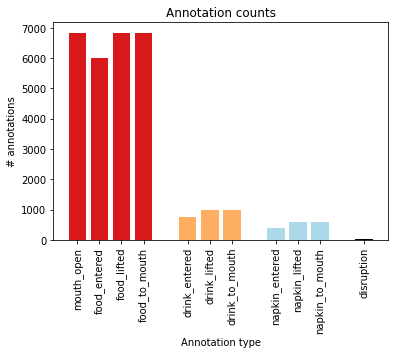

In [13]:
tier_names = [
    'mouth_open',

    'food_entered',
    'food_lifted',
    'food_to_mouth',

    'drink_entered',
    'drink_lifted',
    'drink_to_mouth',

    'napkin_entered',
    'napkin_lifted',
    'napkin_to_mouth',

    'disruption'
]

counts = defaultdict(int)
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)
    for tier_name in tier_names:
        counts[tier_name] += len(eaf_obj1.get_annotation_data_for_tier(tier_name))

print(f'Total number of annotations: {sum(counts.values())}')
print(json.dumps(counts, indent=4, default=str))

ind = [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 13]
plt.figure()
plt.bar(ind, [counts[tier_name] for tier_name in tier_names], color=['#d7191c'] * 4 + ['#fdae61'] * 3 + ['#abd9e9'] * 3 + ['black'])
plt.xticks(ind, tier_names, rotation=90)
plt.xlabel('Annotation type')
plt.ylabel('# annotations')
plt.title('Annotation counts')
plt.show()


## 1.2 By annotation value

Relevant for food_to_mouth, drink_to_mouth, and disruption annotation types.

In [76]:
tier_names = [
    # 'mouth_open',

    # 'food_entered',
    # 'food_lifted',
    'food_to_mouth',

    # 'drink_entered',
    # 'drink_lifted',
    'drink_to_mouth',

    # 'napkin_entered',
    # 'napkin_lifted',
    # 'napkin_to_mouth',

    'disruption'
]

value_counts = {tier_name: Counter() for tier_name in tier_names}
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)
    for tier_name in tier_names:
        value_counts[tier_name] += Counter(annotation_value for _, _, annotation_value in eaf_obj1.get_annotation_data_for_tier(tier_name))

print(json.dumps(value_counts, indent=4, default=str))


{
    "food_to_mouth": {
        "chopsticks": 2025,
        "spoon": 806,
        "hand": 1886,
        "fork": 2114,
        "knife": 2,
        "": 1
    },
    "drink_to_mouth": {
        "cup": 385,
        "bottle": 593
    },
    "disruption": {
        "light_off": 15,
        "participant_left": 1
    }
}


The empty label for food_to_mouth annotations is not visualized (only 1 such occurance) but it was included for calculation of percentages


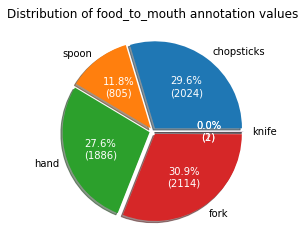

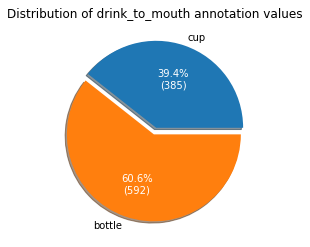

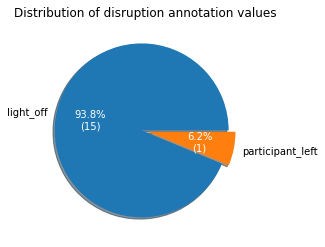

In [78]:
print("The empty label for food_to_mouth annotations is not visualized (only 1 such occurance) but it was included for calculation of percentages")
for tier_name in tier_names:
    # The empty label for food_to_mouth annotations is not visualized (only 1 such occurance) but it was included for calculation of percentages
    # labels = ['empty' if label == '' else label for label in value_counts[tier_name].keys()]
    labels = value_counts[tier_name].keys()
    sizes = value_counts[tier_name].values()
    plt.figure()
    _, _, autotexts = plt.pie(sizes, labels=labels, 
        autopct=lambda pct: "{:.1f}%\n({:d})".format(pct, int(sum(sizes) * pct/100.)),
        explode=[0.04] * len(sizes),
        # labeldistance=None,
        shadow=True)
    for autotext in autotexts:
        autotext.set_color('white')
        # autotext.set_fontsize(15)
    plt.title(f'Distribution of {tier_name} annotation values')
    plt.show()


# 2 Annotation durations

## 2.1 By annotation type

In [98]:
tier_names = [
    'mouth_open',

    # 'food_entered',
    # 'food_lifted',
    'food_to_mouth',

    # 'drink_entered',
    # 'drink_lifted',
    'drink_to_mouth',

    # 'napkin_entered',
    # 'napkin_lifted',
    'napkin_to_mouth',

    # 'disruption'
]

durations = defaultdict(list)
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)
    for tier_name in tier_names:
        # durations[tier_name].extend( [(end_time - start_time)/1000. for start_time, end_time, _ in eaf_obj1.get_annotation_data_for_tier(tier_name)] )
        # For a more detailed investigation of long annotation durations
        ds = []
        for start_time, end_time, v in eaf_obj1.get_annotation_data_for_tier(tier_name):
            d = (end_time - start_time)/1000.
            ds.append(d)
            if d > 10:
                print(annotation_file, tier_name, start_time, end_time, v, d)
        durations[tier_name].extend(ds)

for tier_name in tier_names:
    print(f'{tier_name}:     \t min = {min(durations[tier_name])} s \t max = {max(durations[tier_name])} s')

/home/janko/Desktop/social-dining/data/annotation/annotation-files/18_2.eaf drink_to_mouth 629819 643767 cup 13.948
/home/janko/Desktop/social-dining/data/annotation/annotation-files/18_2.eaf drink_to_mouth 1059514 1071401 cup 11.887
/home/janko/Desktop/social-dining/data/annotation/annotation-files/18_2.eaf drink_to_mouth 1860660 1878464 cup 17.804
/home/janko/Desktop/social-dining/data/annotation/annotation-files/18_2.eaf drink_to_mouth 1970312 1985741 cup 15.429
/home/janko/Desktop/social-dining/data/annotation/annotation-files/22_3.eaf napkin_to_mouth 2195470 2207026  11.556
/home/janko/Desktop/social-dining/data/annotation/annotation-files/28_1.eaf food_to_mouth 2272435 2286682 hand 14.247
/home/janko/Desktop/social-dining/data/annotation/annotation-files/28_1.eaf food_to_mouth 2314125 2324232 hand 10.107
/home/janko/Desktop/social-dining/data/annotation/annotation-files/28_1.eaf food_to_mouth 2574995 2588895 hand 13.9
/home/janko/Desktop/social-dining/data/annotation/annotation-f

Bin width: 0.05 s


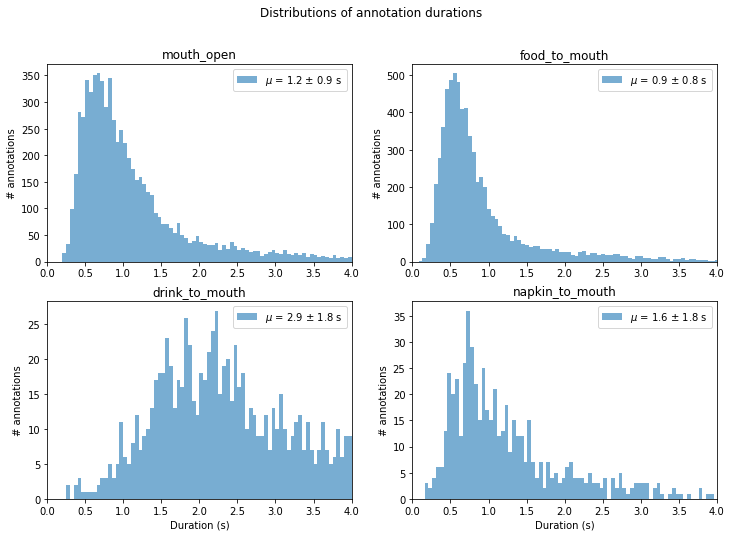

In [103]:
bin_width = 0.05 # in seconds
print(f"Bin width: {bin_width} s")
plt.figure(figsize=(12,8))
for i, tier_name in enumerate(tier_names):
    bins_range = np.arange(min(durations[tier_name]), max(durations[tier_name]) + bin_width, bin_width)
    plt.subplot(2, 2, i + 1)
    plt.hist(durations[tier_name],
             alpha=0.6, bins=bins_range,
             label=fr'$\mu$ = {np.mean(durations[tier_name]):.1f} $\pm$ {np.std(durations[tier_name]):.1f} s'
    )
    plt.xlim(0, 4)
    if i > 1:
        plt.xlabel('Duration (s)')
    # if i % 2 == 0:
    plt.ylabel('# annotations')
    plt.title(tier_name)
    plt.legend()

plt.suptitle('Distributions of annotation durations')
plt.show()


Bin width: 0.05 s


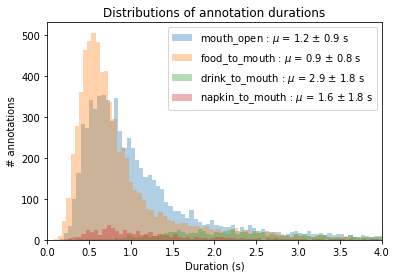

In [104]:
bin_width = 0.05 # in seconds
print(f"Bin width: {bin_width} s")
plt.figure()
for tier_name in tier_names:
    bins_range = np.arange(min(durations[tier_name]), max(durations[tier_name]) + bin_width, bin_width)
    plt.hist(durations[tier_name], alpha=0.35, bins=bins_range, 
             label=tier_name + fr' : $\mu$ = {np.mean(durations[tier_name]):.1f} $\pm$ {np.std(durations[tier_name]):.1f} s')
plt.xlim(0, 4)
plt.legend()
plt.xlabel('Duration (s)')
plt.ylabel('# annotations')
plt.title('Distributions of annotation durations')
plt.show()


## 2.2 By annotation value

In [156]:
tier_names = [
    'mouth_open',

    # 'food_entered',
    # 'food_lifted',
    'food_to_mouth',

    # 'drink_entered',
    # 'drink_lifted',
    'drink_to_mouth',

    # 'napkin_entered',
    # 'napkin_lifted',
    'napkin_to_mouth',

    # 'disruption'
]

durations_by_value = {}
for tier_name in tier_names:
    durations_by_value[tier_name] = defaultdict(list)
    
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)

    for ((mo_start_time, mo_end_time, _), 
         (ftm_start_time, ftm_end_time, annotation_value)) in zip(sorted(eaf_obj1.get_annotation_data_for_tier('mouth_open'), key=lambda x: x[0]),
                                                                  sorted(eaf_obj1.get_annotation_data_for_tier('food_to_mouth'), key=lambda x: x[0])):
        durations_by_value['mouth_open'][annotation_value].append( (mo_end_time - mo_start_time)/1000. )
        durations_by_value['food_to_mouth'][annotation_value].append( (ftm_end_time - ftm_start_time)/1000. )

    for tier_name in ['drink_to_mouth', 'napkin_to_mouth']:
        for start_time, end_time, annotation_value in eaf_obj1.get_annotation_data_for_tier(tier_name):
            durations_by_value[tier_name][annotation_value].append( (end_time - start_time)/1000. )

for tier_name in tier_names:
    print(f'{tier_name}:')
    for annotation_value in durations_by_value[tier_name].keys():
        print(f'\t {annotation_value:<10}: \t min = {min(durations_by_value[tier_name][annotation_value])} s \t max = {max(durations_by_value[tier_name][annotation_value])} s')


mouth_open:
	 chopsticks: 	 min = 0.2 s 	 max = 7.525 s
	 spoon     : 	 min = 0.352 s 	 max = 5.674 s
	 hand      : 	 min = 0.235 s 	 max = 8.8 s
	 fork      : 	 min = 0.24 s 	 max = 13.655 s
	 knife     : 	 min = 0.781 s 	 max = 0.96 s
	           : 	 min = 0.79 s 	 max = 0.79 s
food_to_mouth:
	 chopsticks: 	 min = 0.161 s 	 max = 6.05 s
	 spoon     : 	 min = 0.28 s 	 max = 5.802 s
	 hand      : 	 min = 0.14 s 	 max = 14.247 s
	 fork      : 	 min = 0.08 s 	 max = 5.92 s
	 knife     : 	 min = 0.56 s 	 max = 3.095 s
	           : 	 min = 0.48 s 	 max = 0.48 s
drink_to_mouth:
	 cup       : 	 min = 0.25 s 	 max = 17.804 s
	 bottle    : 	 min = 0.288 s 	 max = 12.953 s
napkin_to_mouth:
	           : 	 min = 0.16 s 	 max = 20.453 s


Bin width: 0.05 s
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


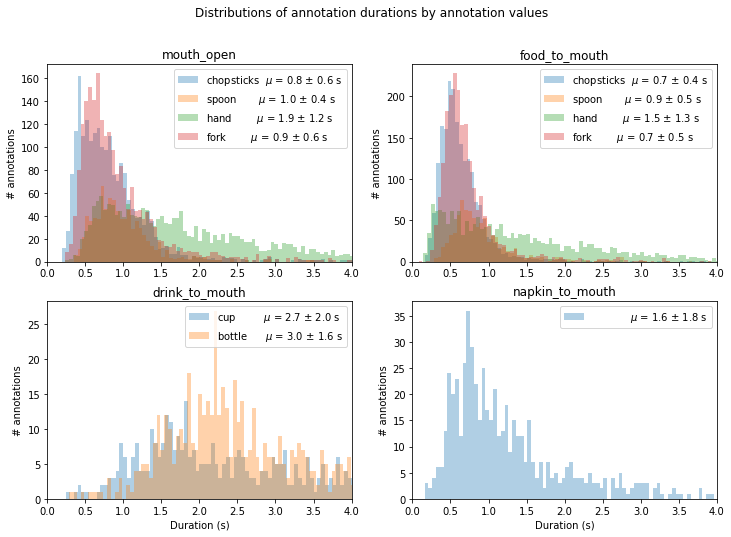

In [157]:
bin_width = 0.05 # in seconds
print(f"Bin width: {bin_width} s")
plt.figure(figsize=(12,8))
for i, tier_name in enumerate(tier_names):
    plt.subplot(2, 2, i + 1)
    for annotation_value in durations_by_value[tier_name].keys():
        # Skip 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and (tier_name == 'mouth_open' or tier_name == 'food_to_mouth')):
            print("Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations")
            continue
        bins_range = np.arange(min(durations_by_value[tier_name][annotation_value]), max(durations_by_value[tier_name][annotation_value]) + bin_width, bin_width)
        plt.hist(durations_by_value[tier_name][annotation_value],
                alpha=0.35, bins=bins_range,
                label=fr'{annotation_value:<11} $\mu$ = {np.mean(durations_by_value[tier_name][annotation_value]):.1f} $\pm$ {np.std(durations_by_value[tier_name][annotation_value]):.1f} s'
        )
    plt.xlim(0, 4)
    if i > 1:
        plt.xlabel('Duration (s)')
    # if i % 2 == 0:
    plt.ylabel('# annotations')
    plt.title(tier_name)
    plt.legend()

plt.suptitle('Distributions of annotation durations by annotation values')
plt.show()


# 3 Time between annotations

## 3.1 Of the same annotation type

### 3.1.1 By annotation type

In [96]:
tier_names = [
    'mouth_open',

    'food_entered',
    'food_lifted',
    'food_to_mouth',

    'drink_entered',
    'drink_lifted',
    'drink_to_mouth',

    'napkin_entered',
    'napkin_lifted',
    'napkin_to_mouth',

    # 'disruption'
]

spacings = defaultdict(list)
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)
    for tier_name in tier_names:
        spacings[tier_name].extend( np.diff([start_time / 1000. for start_time, _, _ in sorted(eaf_obj1.get_annotation_data_for_tier(tier_name), key=lambda x: x[0])]) )

for tier_name in tier_names:
    print(f'{tier_name}:     \t min = {min(spacings[tier_name])} s \t max = {max(spacings[tier_name])} s')


mouth_open:     	 min = 0.8659999999999854 s 	 max = 1189.4450000000002 s
food_entered:     	 min = 0.09499999999997044 s 	 max = 1189.423 s
food_lifted:     	 min = 0.6660000000000537 s 	 max = 1186.225 s
food_to_mouth:     	 min = 0.7769999999999868 s 	 max = 1189.421 s
drink_entered:     	 min = 3.9990000000000236 s 	 max = 2118.5249999999996 s
drink_lifted:     	 min = 2.0829999999998563 s 	 max = 2118.485 s
drink_to_mouth:     	 min = 1.4669999999999845 s 	 max = 2118.1569999999997 s
napkin_entered:     	 min = 2.9979999999999905 s 	 max = 1652.954 s
napkin_lifted:     	 min = 1.1390000000001237 s 	 max = 1620.506 s
napkin_to_mouth:     	 min = 1.0190000000000055 s 	 max = 1621.282 s


In [99]:
def plot_4_hist(data, tier_names, xmax=400):
    bin_width = 5. # in seconds
    print(f"Bin width: {bin_width} s")
    plt.figure(figsize=(12,8))
    for i, tier_name in enumerate(tier_names):
        bins_range = np.arange(min(data[tier_name]), max(data[tier_name]) + bin_width, bin_width)
        plt.subplot(2, 2, i + 1)
        plt.hist(data[tier_name],
                alpha=0.6, bins=bins_range,
                label=fr'$\mu$ = {np.mean(data[tier_name]):.1f} $\pm$ {np.std(data[tier_name]):.1f} s'
        )
        plt.xlim(0, xmax)
        if i > 1:
            plt.xlabel('Time between annotations (s)')
        # if i % 2 == 0:
        plt.ylabel('# annotations')
        plt.title(tier_name)
        plt.legend()

    plt.suptitle('Distributions of times between annotations of the same type')
    plt.show()

def plot_4_in_1_hist(data, tier_names, xmax=100):
    bin_width = 5. # in seconds
    print(f"Bin width: {bin_width} s")
    plt.figure()
    for tier_name in tier_names:
        bins_range = np.arange(min(data[tier_name]), max(data[tier_name]) + bin_width, bin_width)
        plt.hist(data[tier_name], alpha=0.35, bins=bins_range, 
                    label=tier_name + fr' : $\mu$ = {np.mean(data[tier_name]):.1f} $\pm$ {np.std(data[tier_name]):.1f} s')
    plt.xlim(0, xmax)
    plt.legend()
    plt.xlabel('Time between annotations (s)')
    plt.ylabel('# annotations')
    plt.title('Distributions of times between annotations of the same type')
    plt.show()


Bin width: 5.0 s


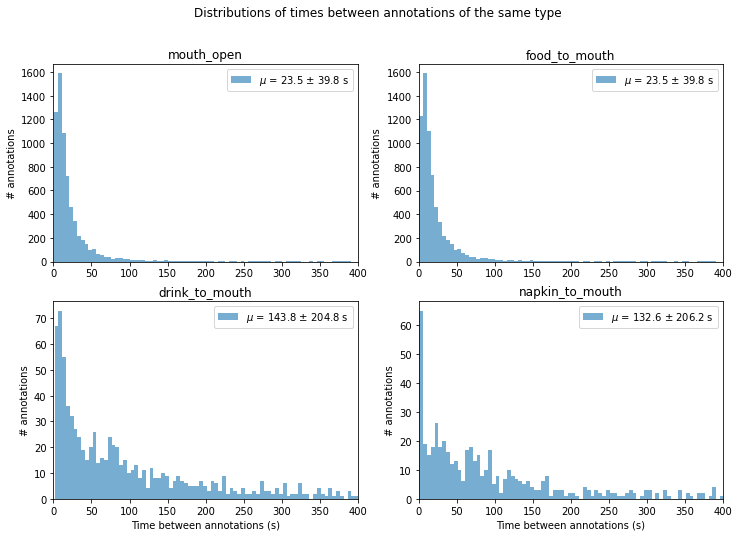

Bin width: 5.0 s


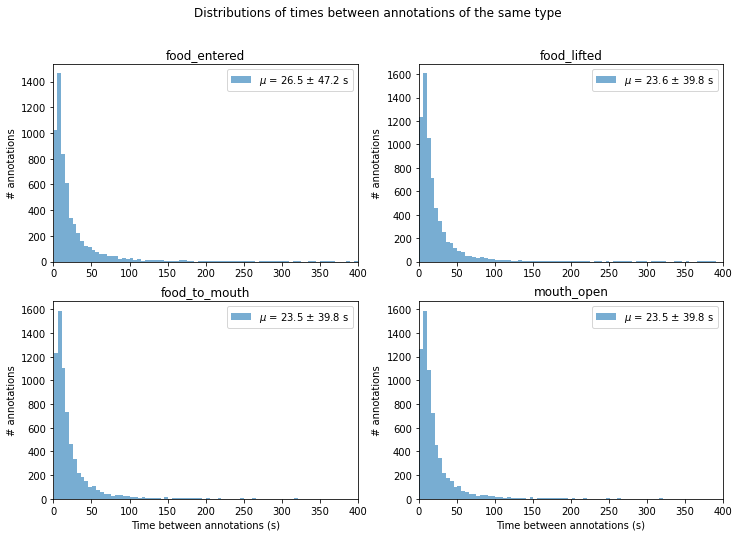

Bin width: 5.0 s


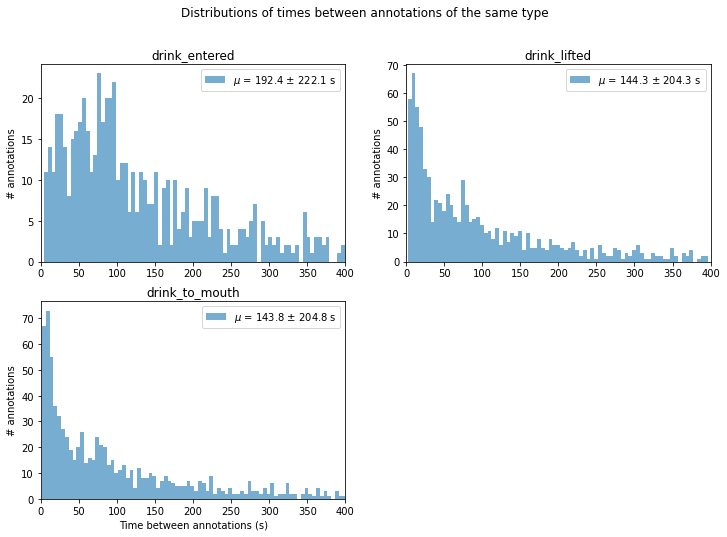

Bin width: 5.0 s


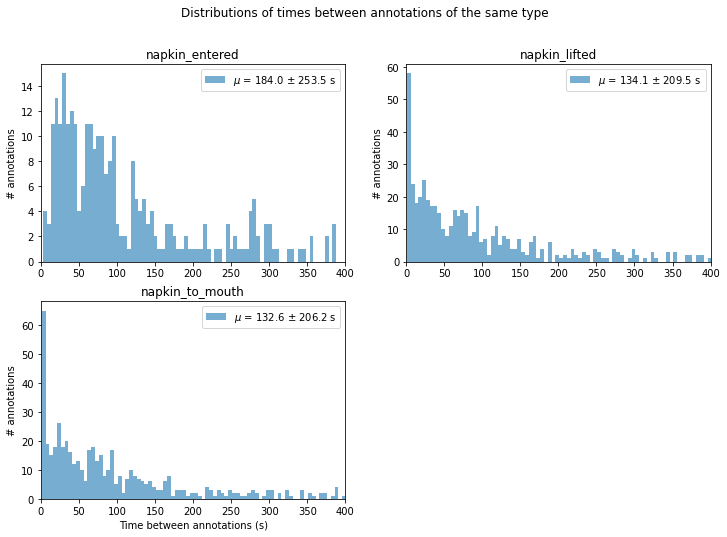

In [100]:
plot_4_hist(spacings, ['mouth_open', 'food_to_mouth', 'drink_to_mouth', 'napkin_to_mouth'])
plot_4_hist(spacings, ['food_entered', 'food_lifted', 'food_to_mouth', 'mouth_open'])
plot_4_hist(spacings, ['drink_entered', 'drink_lifted', 'drink_to_mouth'])
plot_4_hist(spacings, ['napkin_entered', 'napkin_lifted', 'napkin_to_mouth'])


Bin width: 5.0 s


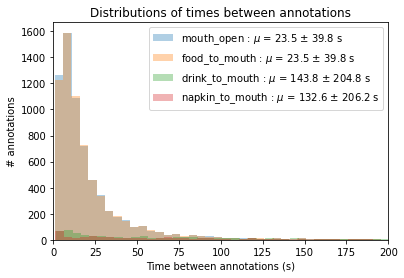

Bin width: 5.0 s


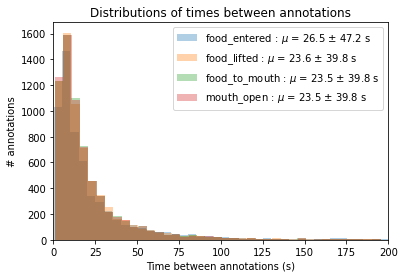

Bin width: 5.0 s


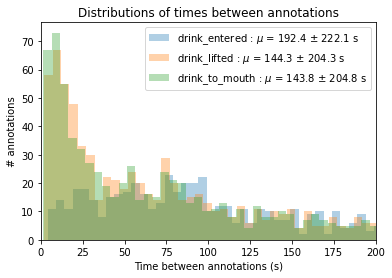

Bin width: 5.0 s


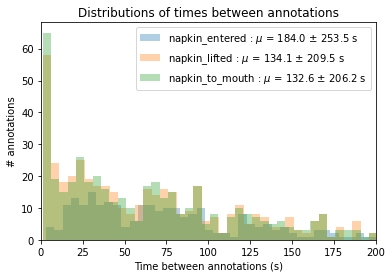

In [131]:
plot_4_in_1_hist(spacings, ['mouth_open', 'food_to_mouth', 'drink_to_mouth', 'napkin_to_mouth'], xmax=200)
plot_4_in_1_hist(spacings, ['food_entered', 'food_lifted', 'food_to_mouth', 'mouth_open'], xmax=200)
plot_4_in_1_hist(spacings, ['drink_entered', 'drink_lifted', 'drink_to_mouth'], xmax=200)
plot_4_in_1_hist(spacings, ['napkin_entered', 'napkin_lifted', 'napkin_to_mouth'], xmax=200)

### 3.1.2 By annotation value

In [133]:
tier_names = [
    'mouth_open',

    # 'food_entered',
    # 'food_lifted',
    'food_to_mouth',

    # 'drink_entered',
    # 'drink_lifted',
    'drink_to_mouth',

    # 'napkin_entered',
    # 'napkin_lifted',
    'napkin_to_mouth',

    # 'disruption'
]

spacings_by_value = {}
for tier_name in tier_names:
    spacings_by_value[tier_name] = defaultdict(list)
    
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)

    prev_mo_start_time = -1
    prev_ftm_start_time = -1
    for ((mo_start_time, _, _), 
         (ftm_start_time, _, annotation_value)) in zip(sorted(eaf_obj1.get_annotation_data_for_tier('mouth_open'), key=lambda x: x[0]),
                                                       sorted(eaf_obj1.get_annotation_data_for_tier('food_to_mouth'), key=lambda x: x[0])):
        if prev_mo_start_time != -1:
            spacings_by_value['mouth_open'][annotation_value].append( (mo_start_time - prev_mo_start_time) / 1000. )
            spacings_by_value['food_to_mouth'][annotation_value].append( (ftm_start_time - prev_ftm_start_time) / 1000. )
        prev_mo_start_time = mo_start_time
        prev_ftm_start_time = ftm_start_time

    for tier_name in ['drink_to_mouth', 'napkin_to_mouth']:
        prev_start_time = -1
        for start_time, _, annotation_value in sorted(eaf_obj1.get_annotation_data_for_tier(tier_name), key=lambda x: x[0]):
            if prev_start_time != -1:
                spacings_by_value[tier_name][annotation_value].append( (start_time - prev_start_time) / 1000. )
            prev_start_time = start_time

for tier_name in tier_names:
    print(f'{tier_name}:')
    for annotation_value in spacings_by_value[tier_name].keys():
        print(f'\t {annotation_value:<10}: \t min = {min(spacings_by_value[tier_name][annotation_value])} s   \t max = {max(spacings_by_value[tier_name][annotation_value])} s')


mouth_open:
	 chopsticks: 	 min = 1.29 s   	 max = 609.829 s
	 spoon     : 	 min = 1.407 s   	 max = 620.498 s
	 hand      : 	 min = 0.866 s   	 max = 580.612 s
	 fork      : 	 min = 1.794 s   	 max = 1189.445 s
	 knife     : 	 min = 11.616 s   	 max = 109.163 s
	           : 	 min = 19.241 s   	 max = 19.241 s
food_to_mouth:
	 chopsticks: 	 min = 1.333 s   	 max = 609.771 s
	 spoon     : 	 min = 1.31 s   	 max = 620.821 s
	 hand      : 	 min = 0.777 s   	 max = 580.87 s
	 fork      : 	 min = 1.674 s   	 max = 1189.421 s
	 knife     : 	 min = 11.816 s   	 max = 109.125 s
	           : 	 min = 19.232 s   	 max = 19.232 s
drink_to_mouth:
	 cup       : 	 min = 1.467 s   	 max = 2118.157 s
	 bottle    : 	 min = 2.236 s   	 max = 1310.337 s
napkin_to_mouth:
	           : 	 min = 1.019 s   	 max = 1621.282 s


Bin width: 1 s
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


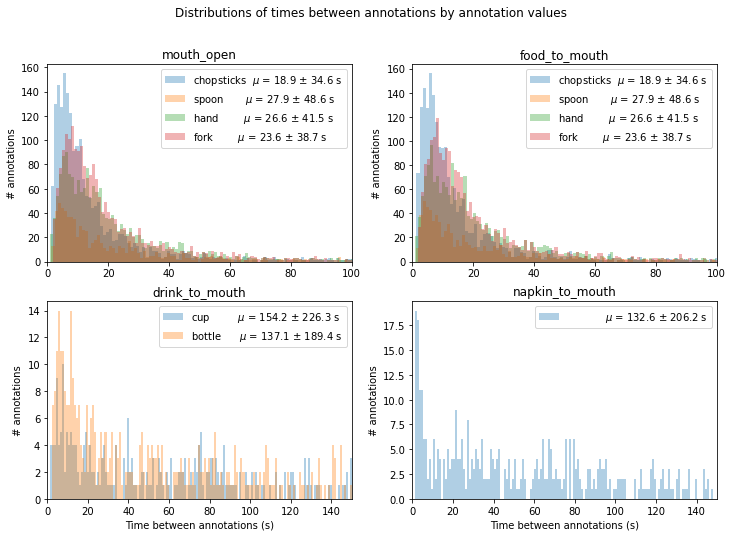

In [138]:
bin_width = 1 # in seconds
print(f"Bin width: {bin_width} s")
plt.figure(figsize=(12,8))
for i, tier_name in enumerate(tier_names):
    plt.subplot(2, 2, i + 1)
    for annotation_value in spacings_by_value[tier_name].keys():
        # Skip 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and (tier_name == 'mouth_open' or tier_name == 'food_to_mouth')):
            print("Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations")
            continue
        bins_range = np.arange(min(spacings_by_value[tier_name][annotation_value]), max(spacings_by_value[tier_name][annotation_value]) + bin_width, bin_width)
        plt.hist(spacings_by_value[tier_name][annotation_value],
                alpha=0.35, bins=bins_range,
                label=fr'{annotation_value:<11} $\mu$ = {np.mean(spacings_by_value[tier_name][annotation_value]):.1f} $\pm$ {np.std(spacings_by_value[tier_name][annotation_value]):.1f} s'
        )
    if tier_name == 'drink_to_mouth' or tier_name == 'napkin_to_mouth':
        plt.xlim(0, 150)
    else:
         plt.xlim(0, 100)
    if i > 1:
        plt.xlabel('Time between annotations (s)')
    # if i % 2 == 0:
    plt.ylabel('# annotations')
    plt.title(tier_name)
    plt.legend()

plt.suptitle('Distributions of times between annotations of the same type by annotation values')
plt.show()


## 3.2 Of a different annotation type

### 3.2.1 By annotation type

In [140]:
tier_names = [
    'mouth_open',
    'food_lifted',
    'food_to_mouth',

    'drink_lifted',
    'drink_to_mouth',

    'napkin_lifted',
    'napkin_to_mouth'
]

delays = defaultdict(list)
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)

    annotations = {}
    for tier_name in tier_names:
        annotations[tier_name] = sorted(eaf_obj1.get_annotation_data_for_tier(tier_name), key=lambda x: x[0])

    # The food_lifted annotation must precede the food_to_mouth annotation unless the food is already lifted at the beginning of the video
    # The mouth_open annotation must precede the food_to_mouth annotation
    i1, i2 = 0, 0
    while i2 < len(annotations['food_to_mouth']):
        if not (i1 == 0 and annotations['food_lifted'][i1][0] > annotations['food_to_mouth'][i2][0]):
            delays['fl->ftm'].append( (annotations['food_to_mouth'][i2][0] - annotations['food_lifted'][i1][0]) / 1000. )
            i1 += 1
        delays['mo->ftm'].append( (annotations['food_to_mouth'][i2][0] - annotations['mouth_open'][i2][0]) / 1000. )
        i2 += 1

    # The drink_lifted annotation must precede the drink_to_mouth annotation unless the drink is already lifted at the beginning of the video
    i1, i2 = 0, 0
    while i2 < len(annotations['drink_to_mouth']):
        if not (i1 == 0 and annotations['drink_lifted'][i1][0] > annotations['drink_to_mouth'][i2][0]):
            delays['dl->dtm'].append( (annotations['drink_to_mouth'][i2][0] - annotations['drink_lifted'][i1][0]) / 1000. )
            i1 += 1
        i2 += 1

    # The napkin_lifted annotation must precede the napkin_to_mouth annotation unless the napkin is already lifted at the beginning of the video.    
    i1, i2 = 0, 0
    while i2 < len(annotations['napkin_to_mouth']):
        if not (i1 == 0 and annotations['napkin_lifted'][i1][0] > annotations['napkin_to_mouth'][i2][0]):
            delays['nl->ntm'].append( (annotations['napkin_to_mouth'][i2][0] - annotations['napkin_lifted'][i1][0]) / 1000. )
            i1 += 1
        i2 += 1


Bin width: 0.1 s
fl->ftm : 	 Histogram maximum at: 0.624 s
mo->ftm : 	 Histogram maximum at: 0.263 s
dl->dtm : 	 Histogram maximum at: 0.9780000000000001 s
Multiple histogram maxima found! Calculating average position between the two most distant maxima ...
nl->ntm : 	 Histogram maximum at: 0.5100000000000001 s


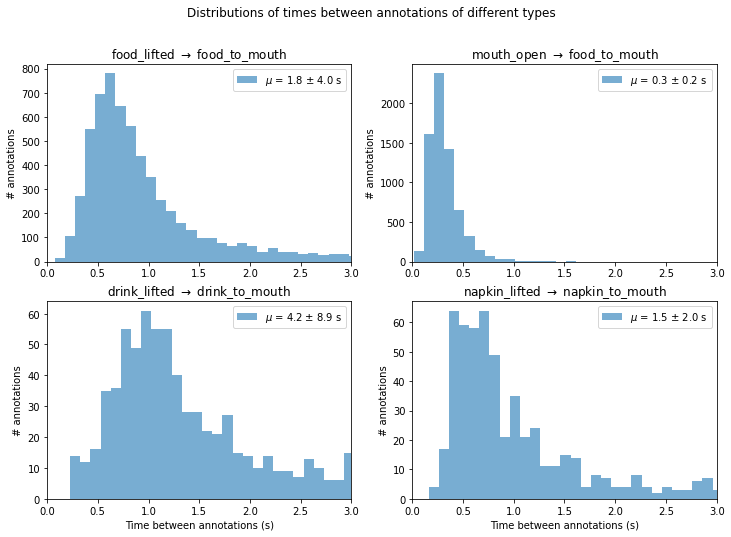

In [155]:
delay_labels = {
    'fl->ftm': fr'food_lifted $\rightarrow$ food_to_mouth',
    'mo->ftm': fr'mouth_open $\rightarrow$ food_to_mouth',
    'dl->dtm': fr'drink_lifted $\rightarrow$ drink_to_mouth',
    'nl->ntm': fr'napkin_lifted $\rightarrow$ napkin_to_mouth',
}

bin_width = 0.1 # in seconds
print(f"Bin width: {bin_width} s")
plt.figure(figsize=(12,8))
for i, delay_label_key in enumerate(delay_labels.keys()):
    bins_range = np.arange(min(delays[delay_label_key]), max(delays[delay_label_key]) + bin_width, bin_width)
    plt.subplot(2, 2, i + 1)
    y, x, _ = plt.hist(delays[delay_label_key],
            alpha=0.6, bins=bins_range,
            label=fr'$\mu$ = {np.mean(delays[delay_label_key]):.1f} $\pm$ {np.std(delays[delay_label_key]):.1f} s'
    )
    plt.xlim(0, 3)
    if i > 1:
        plt.xlabel('Time between annotations (s)')
    # if i % 2 == 0:
    plt.ylabel('# annotations')
    plt.title(delay_labels[delay_label_key])
    plt.legend()
    compute_hist_maximum(x, y, delay_label_key, bin_width)

plt.suptitle('Distributions of times between annotations of different types')
plt.show()


### 3.2.2 By annotation value

In [4]:
tier_names = [
    'mouth_open',
    'food_lifted',
    'food_to_mouth',

    'drink_lifted',
    'drink_to_mouth',

    'napkin_lifted',
    'napkin_to_mouth'
]
delay_labels = {
    'fl->ftm': fr'food_lifted $\rightarrow$ food_to_mouth',
    'mo->ftm': fr'mouth_open $\rightarrow$ food_to_mouth',
    'dl->dtm': fr'drink_lifted $\rightarrow$ drink_to_mouth',
    'nl->ntm': fr'napkin_lifted $\rightarrow$ napkin_to_mouth',
}

delays_by_value = {}
for delay_label_key in delay_labels.keys():
    delays_by_value[delay_label_key] = defaultdict(list)

for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)

    annotations = {}
    for tier_name in tier_names:
        annotations[tier_name] = sorted(eaf_obj1.get_annotation_data_for_tier(tier_name), key=lambda x: x[0])

    # The food_lifted annotation must precede the food_to_mouth annotation unless the food is already lifted at the beginning of the video
    # The mouth_open annotation must precede the food_to_mouth annotation
    i1, i2 = 0, 0
    while i2 < len(annotations['food_to_mouth']):
        annotation_value = annotations['food_to_mouth'][i2][2]
        if not (i1 == 0 and annotations['food_lifted'][i1][0] > annotations['food_to_mouth'][i2][0]):
            delays_by_value['fl->ftm'][annotation_value].append( (annotations['food_to_mouth'][i2][0] - annotations['food_lifted'][i1][0]) / 1000. )
            i1 += 1
        delays_by_value['mo->ftm'][annotation_value].append( (annotations['food_to_mouth'][i2][0] - annotations['mouth_open'][i2][0]) / 1000. )
        i2 += 1

    # The drink_lifted annotation must precede the drink_to_mouth annotation unless the drink is already lifted at the beginning of the video
    i1, i2 = 0, 0
    while i2 < len(annotations['drink_to_mouth']):
        annotation_value = annotations['drink_to_mouth'][i2][2]
        if not (i1 == 0 and annotations['drink_lifted'][i1][0] > annotations['drink_to_mouth'][i2][0]):
            delays_by_value['dl->dtm'][annotation_value].append( (annotations['drink_to_mouth'][i2][0] - annotations['drink_lifted'][i1][0]) / 1000. )
            i1 += 1
        i2 += 1

    # The napkin_lifted annotation must precede the napkin_to_mouth annotation unless the napkin is already lifted at the beginning of the video.    
    i1, i2 = 0, 0
    while i2 < len(annotations['napkin_to_mouth']):
        annotation_value = annotations['napkin_to_mouth'][i2][2]
        if not (i1 == 0 and annotations['napkin_lifted'][i1][0] > annotations['napkin_to_mouth'][i2][0]):
            delays_by_value['nl->ntm'][annotation_value].append( (annotations['napkin_to_mouth'][i2][0] - annotations['napkin_lifted'][i1][0]) / 1000. )
            i1 += 1
        i2 += 1

for delay_label_key in delay_labels.keys():
    print(f'{delay_label_key}:')
    for annotation_value in delays_by_value[delay_label_key].keys():
        print(f'\t {annotation_value:<10}: \t min = {min(delays_by_value[delay_label_key][annotation_value])} s   \t max = {max(delays_by_value[delay_label_key][annotation_value])} s')


fl->ftm:
	 chopsticks: 	 min = 0.154 s   	 max = 31.133 s
	 spoon     : 	 min = 0.074 s   	 max = 43.042 s
	 hand      : 	 min = 0.146 s   	 max = 80.195 s
	 fork      : 	 min = 0.105 s   	 max = 111.155 s
	 knife     : 	 min = 1.677 s   	 max = 3.511 s
	           : 	 min = 1.652 s   	 max = 1.652 s
mo->ftm:
	 chopsticks: 	 min = 0.07 s   	 max = 1.278 s
	 spoon     : 	 min = 0.035 s   	 max = 1.016 s
	 hand      : 	 min = 0.013 s   	 max = 1.603 s
	 fork      : 	 min = 0.04 s   	 max = 7.658 s
	 knife     : 	 min = 0.221 s   	 max = 0.32 s
	           : 	 min = 0.302 s   	 max = 0.302 s
dl->dtm:
	 cup       : 	 min = 0.238 s   	 max = 55.496 s
	 bottle    : 	 min = 0.228 s   	 max = 117.141 s
nl->ntm:
	           : 	 min = 0.16 s   	 max = 23.928 s


Bin width: 0.05 s
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


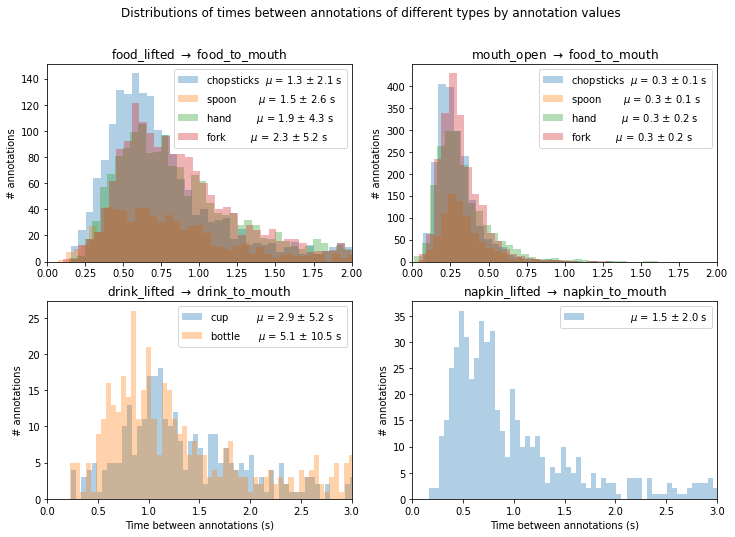

In [9]:
delay_labels = {
    'fl->ftm': fr'food_lifted $\rightarrow$ food_to_mouth',
    'mo->ftm': fr'mouth_open $\rightarrow$ food_to_mouth',
    'dl->dtm': fr'drink_lifted $\rightarrow$ drink_to_mouth',
    'nl->ntm': fr'napkin_lifted $\rightarrow$ napkin_to_mouth',
}

bin_width = 0.05 # in seconds
print(f"Bin width: {bin_width} s")
plt.figure(figsize=(12,8))
for i, delay_label_key in enumerate(delay_labels.keys()):
    plt.subplot(2, 2, i + 1)
    for annotation_value in delays_by_value[delay_label_key].keys():
        # Skip 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and (delay_label_key == 'fl->ftm' or delay_label_key == 'mo->ftm')):
            print("Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations")
            continue
        bins_range = np.arange(min(delays_by_value[delay_label_key][annotation_value]), max(delays_by_value[delay_label_key][annotation_value]) + bin_width, bin_width)
        plt.hist(delays_by_value[delay_label_key][annotation_value],
                alpha=0.35, bins=bins_range,
                label=fr'{annotation_value:<11} $\mu$ = {np.mean(delays_by_value[delay_label_key][annotation_value]):.1f} $\pm$ {np.std(delays_by_value[delay_label_key][annotation_value]):.1f} s'
        )
    if delay_label_key == 'fl->ftm' or delay_label_key == 'mo->ftm':
        plt.xlim(0, 2)
    else:
        plt.xlim(0, 3)
    if i > 1:
        plt.xlabel('Time between annotations (s)')
    # if i % 2 == 0:
    plt.ylabel('# annotations')
    plt.title(delay_labels[delay_label_key])
    plt.legend()

plt.suptitle('Distributions of times between annotations of different types by annotation values')
plt.show()


# 4 Per-video/per-participant statistics

In all what follows, the term 'video' can be substituted by 'participant'.

## 4.1 Number of annotations 

### 4.1.1 Overall

In [131]:
tier_names = [
    'mouth_open',

    'food_entered',
    'food_lifted',
    'food_to_mouth',

    'drink_entered',
    'drink_lifted',
    'drink_to_mouth',

    'napkin_entered',
    'napkin_lifted',
    'napkin_to_mouth',

    'disruption'
]

video_ids = []
counts_by_video = defaultdict(int)
for annotation_file in sorted(glob.glob(f'{annotations_folder}/*.eaf')):
    video_id = annotation_file.split('/')[-1].split('.')[0]
    video_ids.append(video_id)

    eaf_obj1 = pympi.Elan.Eaf(annotation_file)
    counts_by_video[video_id] = sum( len(eaf_obj1.get_annotation_data_for_tier(tier_name)) for tier_name in tier_names )

print(f'Total number of annotations: {sum(counts_by_video.values())}')
print(json.dumps(counts_by_video, indent=4, default=str))


Total number of annotations: 30806
{
    "01_1": 228,
    "01_2": 337,
    "01_3": 292,
    "02_1": 107,
    "02_2": 279,
    "02_3": 354,
    "03_1": 195,
    "03_2": 349,
    "03_3": 164,
    "04_1": 361,
    "04_2": 240,
    "04_3": 572,
    "05_1": 150,
    "05_2": 199,
    "05_3": 157,
    "06_1": 155,
    "06_2": 303,
    "06_3": 347,
    "07_1": 184,
    "07_2": 161,
    "07_3": 164,
    "08_1": 383,
    "08_2": 121,
    "08_3": 236,
    "09_1": 287,
    "09_2": 488,
    "09_3": 438,
    "10_1": 890,
    "10_2": 647,
    "10_3": 715,
    "11_1": 350,
    "11_2": 290,
    "11_3": 332,
    "12_1": 118,
    "12_2": 454,
    "12_3": 194,
    "13_1": 337,
    "13_2": 1593,
    "13_3": 1233,
    "14_1": 257,
    "14_2": 664,
    "14_3": 379,
    "15_1": 202,
    "15_2": 341,
    "15_3": 405,
    "16_1": 247,
    "16_2": 131,
    "16_3": 481,
    "17_1": 147,
    "17_2": 264,
    "17_3": 362,
    "18_1": 675,
    "18_2": 310,
    "18_3": 384,
    "19_1": 324,
    "19_2": 228,
    "19_3

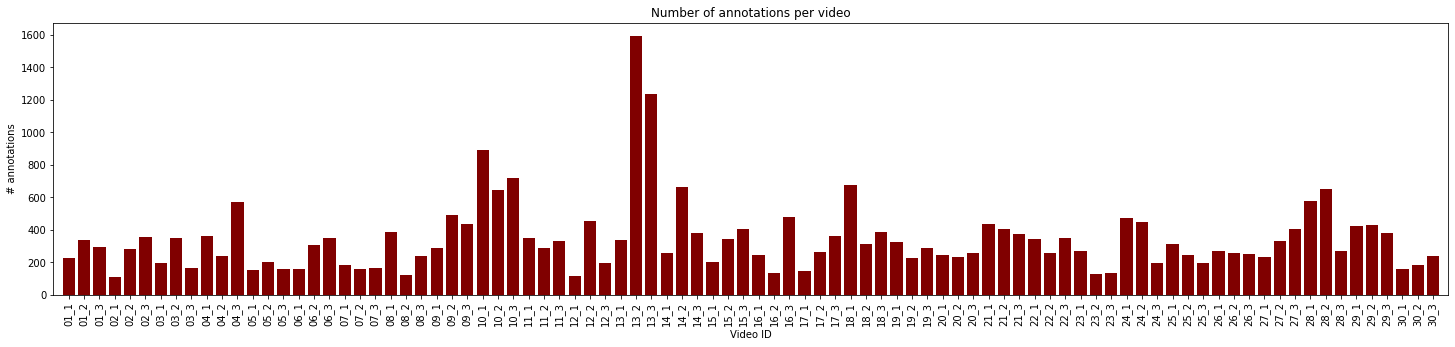

In [132]:
ind = np.arange(len(video_ids))
plt.figure(figsize=(25,5))
plt.bar(ind, [counts_by_video[video_id] for video_id in video_ids], color='maroon')
plt.xticks(ind, video_ids, rotation=90)
plt.xlim(-1, 90)
plt.xlabel('Video ID')
plt.ylabel('# annotations')
plt.title('Number of annotations per video')
plt.show()


Bin width: 20 annotations


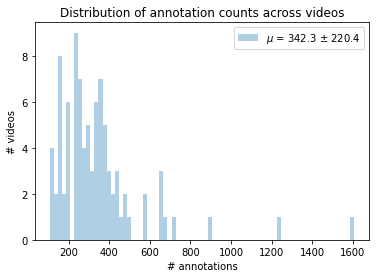

In [133]:
bin_width = 20 # in number of annotations
print(f"Bin width: {bin_width} annotations")
plt.figure()
bins_range = np.arange(min(counts_by_video.values()), max(counts_by_video.values()) + bin_width, bin_width)
plt.hist(counts_by_video.values(), alpha=0.35, bins=bins_range, 
         label=fr'$\mu$ = {np.mean(list(counts_by_video.values())):.1f} $\pm$ {np.std(list(counts_by_video.values())):.1f}')
# plt.xlim(0, 4)
plt.legend()
plt.xlabel('# annotations')
plt.ylabel('# videos')
plt.title('Distribution of annotation counts across videos')
plt.show()

### 4.1.2 By annotation type

In [15]:
tier_names = [
    # 'mouth_open',

    # 'food_entered',
    # 'food_lifted',
    'food_to_mouth',

    # 'drink_entered',
    # 'drink_lifted',
    'drink_to_mouth',

    # 'napkin_entered',
    # 'napkin_lifted',
    'napkin_to_mouth',

    'disruption'
]

video_ids = []
counts_by_video_by_type = {}
for annotation_file in sorted(glob.glob(f'{annotations_folder}/*.eaf')):
    video_id = annotation_file.split('/')[-1].split('.')[0]
    video_ids.append(video_id)

    eaf_obj1 = pympi.Elan.Eaf(annotation_file)
    counts_by_video_by_type[video_id] = { tier_name: len(eaf_obj1.get_annotation_data_for_tier(tier_name)) for tier_name in tier_names }


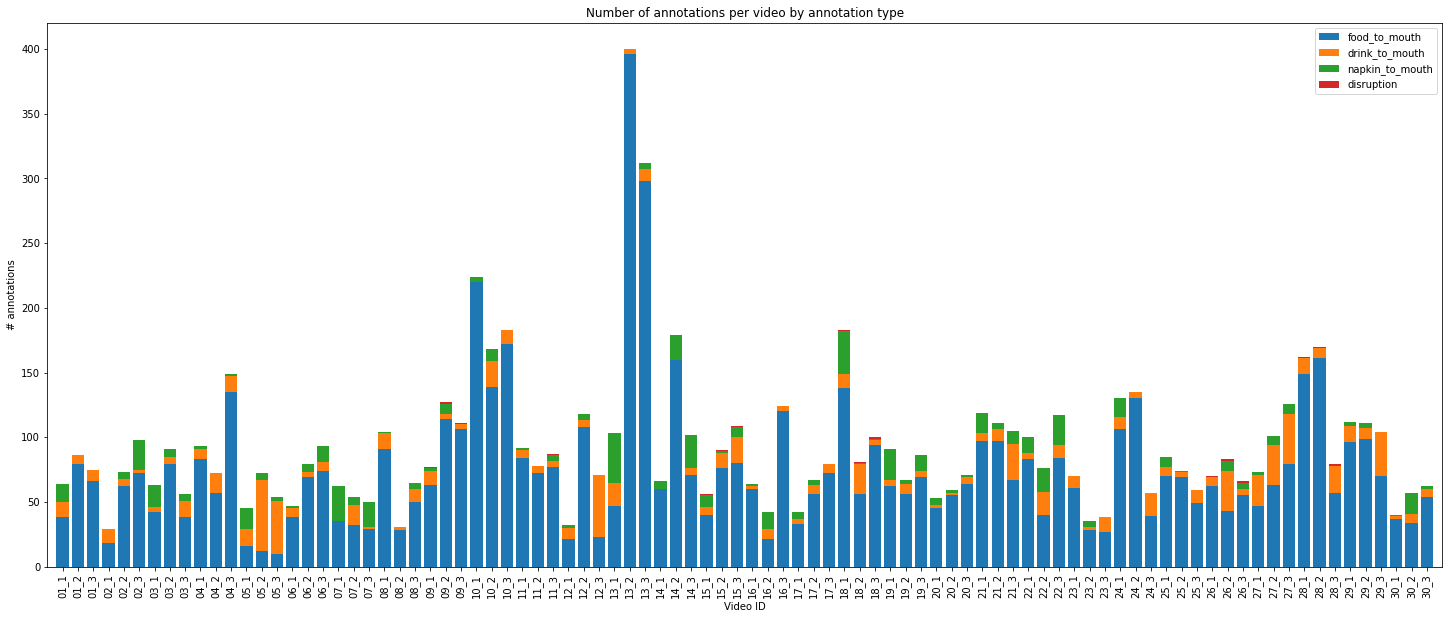

In [16]:
ind = np.arange(len(video_ids))
plt.figure(figsize=(25,10))
prev_y = 0
for tier_name in tier_names:
    y = np.array([ counts_by_video_by_type[video_id][tier_name] for video_id in video_ids ])
    plt.bar(ind, y, bottom=prev_y, label=tier_name)
    prev_y += y
plt.xticks(ind, video_ids, rotation=90)
plt.xlim(-1, 90)
plt.ylim(0, max(prev_y) + 20)
plt.xlabel('Video ID')
plt.ylabel('# annotations')
plt.title('Number of annotations per video by annotation type')
plt.legend()
# leg = plt.legend(title='Annotation type')
# leg._legend_box.align = "left"
plt.show()


Bin width: 3 annotations


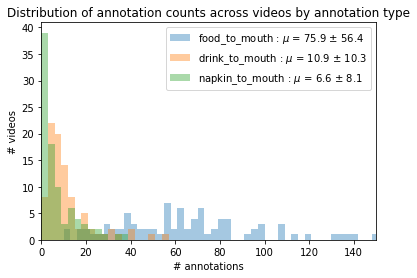

In [17]:
bin_width = 3 # in number of annotations
print(f"Bin width: {bin_width} annotations")
plt.figure()
for tier_name in tier_names[:-1]:
    y = np.array([ counts_by_video_by_type[video_id][tier_name] for video_id in video_ids ])
    bins_range = np.arange(min(y), max(y) + bin_width, bin_width)
    plt.hist(y, alpha=0.4, bins=bins_range, 
            label=fr'{tier_name} : $\mu$ = {np.mean(y):.1f} $\pm$ {np.std(y):.1f}')
plt.xlim(0, 150)
plt.legend()
plt.xlabel('# annotations')
plt.ylabel('# videos')
plt.title('Distribution of annotation counts across videos by annotation type')
plt.show()


Excluding videos with no annotations of that annotation type:
Bin width: 3 annotations


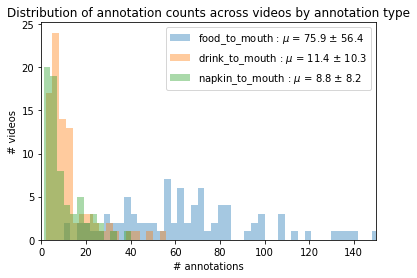

In [18]:
###########################################################################
print(f"Excluding videos with no annotations of that annotation type:")
###########################################################################
bin_width = 3 # in number of annotations
print(f"Bin width: {bin_width} annotations")
plt.figure()
for tier_name in tier_names[:-1]:
    y = np.array([ counts_by_video_by_type[video_id][tier_name] for video_id in video_ids if counts_by_video_by_type[video_id][tier_name] > 0 ])
    bins_range = np.arange(min(y), max(y) + bin_width, bin_width)
    plt.hist(y, alpha=0.4, bins=bins_range, 
            label=fr'{tier_name} : $\mu$ = {np.mean(y):.1f} $\pm$ {np.std(y):.1f}')
plt.xlim(0, 150)
plt.legend()
plt.xlabel('# annotations')
plt.ylabel('# videos')
plt.title('Distribution of annotation counts across videos by annotation type')
plt.show()


### 4.1.3 By annotation value

In [19]:
tier_names = [
    # 'mouth_open',

    # 'food_entered',
    # 'food_lifted',
    'food_to_mouth',

    # 'drink_entered',
    # 'drink_lifted',
    'drink_to_mouth',

    # 'napkin_entered',
    # 'napkin_lifted',
    # 'napkin_to_mouth',

    # 'disruption'
]

video_ids = []
annotation_values = { tier_name: set() for tier_name in tier_names }
counts_by_video_by_value = {}
for annotation_file in sorted(glob.glob(f'{annotations_folder}/*.eaf')):
    video_id = annotation_file.split('/')[-1].split('.')[0]
    video_ids.append(video_id)

    eaf_obj1 = pympi.Elan.Eaf(annotation_file)
    counts_by_video_by_value[video_id] = {}
    for tier_name in tier_names:
        counts_by_video_by_value[video_id][tier_name] = Counter( annotation_value for _, _, annotation_value in eaf_obj1.get_annotation_data_for_tier(tier_name) )
        annotation_values[tier_name].update(counts_by_video_by_value[video_id][tier_name].keys())


Skipping 'knife' and empty annotation values for food_to_mouth annotations
Skipping 'knife' and empty annotation values for food_to_mouth annotations


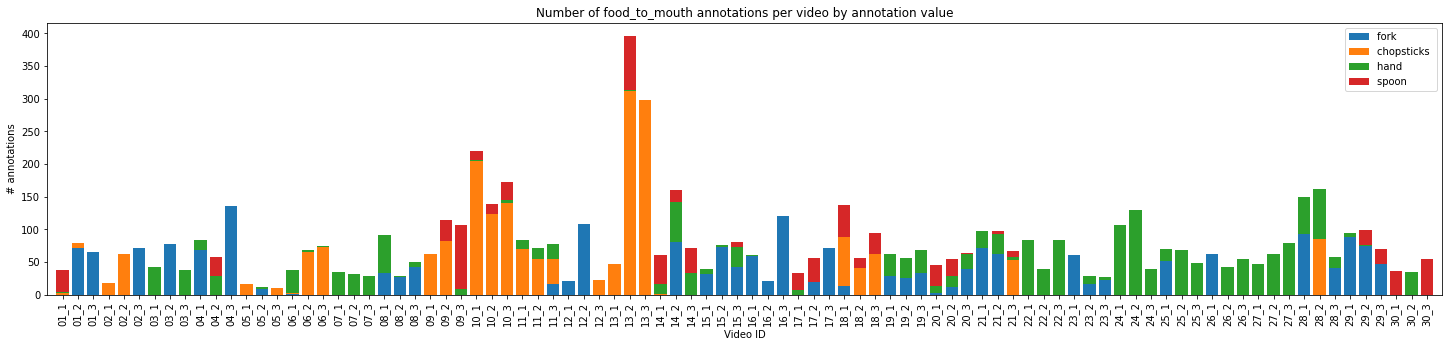

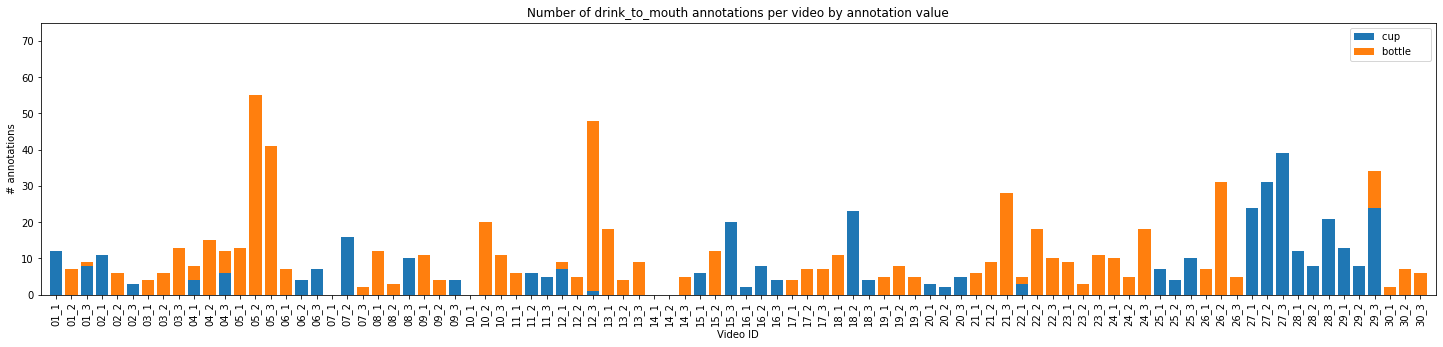

In [20]:
ind = np.arange(len(video_ids))
for tier_name in tier_names:
    plt.figure(figsize=(25,5))
    prev_y = 0
    for annotation_value in annotation_values[tier_name]:
        # Skip 'knife' and empty annotation values for food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and tier_name == 'food_to_mouth'):
            print("Skipping 'knife' and empty annotation values for food_to_mouth annotations")
            continue
        y = np.array([ counts_by_video_by_value[video_id][tier_name][annotation_value] for video_id in video_ids ])
        plt.bar(ind, y, bottom=prev_y, label=fr'{annotation_value:<11}')
        prev_y += y
    plt.xticks(ind, video_ids, rotation=90)
    plt.xlim(-1, 90)
    plt.ylim(0, max(prev_y) + 20)
    plt.xlabel('Video ID')
    plt.ylabel('# annotations')
    plt.title(f'Number of {tier_name} annotations per video by annotation value')
    plt.legend()
    # leg = plt.legend(title='Annotation type')
    # leg._legend_box.align = "left"
    plt.show()


Bin width: 1 annotations
Skipping 'knife' and empty annotation values for food_to_mouth annotations
Skipping 'knife' and empty annotation values for food_to_mouth annotations


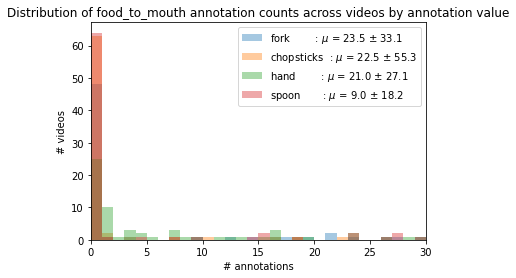

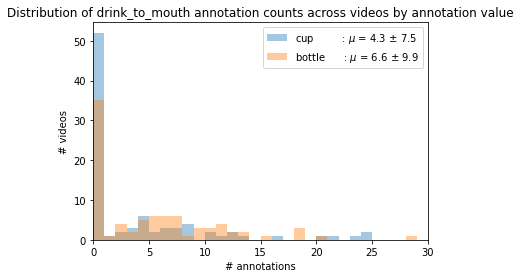

In [21]:
bin_width = 1 # in number of annotations
print(f"Bin width: {bin_width} annotations")
for tier_name in tier_names:
    plt.figure()
    for annotation_value in annotation_values[tier_name]:
        # Skip 'knife' and empty annotation values for food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and tier_name == 'food_to_mouth'):
            print("Skipping 'knife' and empty annotation values for food_to_mouth annotations")
            continue
        y = np.array([ counts_by_video_by_value[video_id][tier_name][annotation_value] for video_id in video_ids ])
        bins_range = np.arange(min(y), max(y) + bin_width, bin_width)
        plt.hist(y, alpha=0.4, bins=bins_range, 
                label=fr'{annotation_value:<11} : $\mu$ = {np.mean(y):.1f} $\pm$ {np.std(y):.1f}')
    plt.xlim(0, 30)
    plt.legend()
    plt.xlabel('# annotations')
    plt.ylabel('# videos')
    plt.title(f'Distribution of {tier_name} annotation counts across videos by annotation value')
    plt.show()


Excluding videos with no annotations with that annotation value:
Bin width: 1 annotations
Skipping 'knife' and empty annotation values for food_to_mouth annotations
Skipping 'knife' and empty annotation values for food_to_mouth annotations


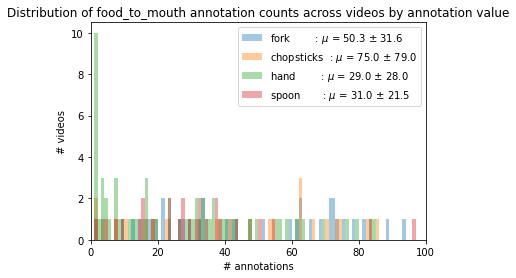

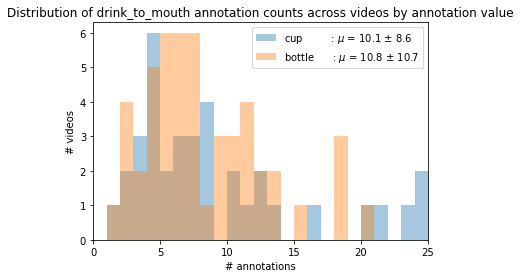

In [24]:
###########################################################################
print(f"Excluding videos with no annotations with that annotation value:")
###########################################################################
bin_width = 1 # in number of annotations
print(f"Bin width: {bin_width} annotations")
for tier_name, xmax in zip(tier_names, [100, 25]):
    plt.figure()
    for annotation_value in annotation_values[tier_name]:
        # Skip 'knife' and empty annotation values for food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and tier_name == 'food_to_mouth'):
            print("Skipping 'knife' and empty annotation values for food_to_mouth annotations")
            continue
        y = np.array([ counts_by_video_by_value[video_id][tier_name][annotation_value] for video_id in video_ids if counts_by_video_by_value[video_id][tier_name][annotation_value] > 0 ])
        bins_range = np.arange(min(y), max(y) + bin_width, bin_width)
        plt.hist(y, alpha=0.4, bins=bins_range, 
                label=fr'{annotation_value:<11} : $\mu$ = {np.mean(y):.1f} $\pm$ {np.std(y):.1f}')
    plt.xlim(0, xmax)
    plt.legend()
    plt.xlabel('# annotations')
    plt.ylabel('# videos')
    plt.title(f'Distribution of {tier_name} annotation counts across videos by annotation value')
    plt.show()


## 4.2 Video durations

In [161]:
video_ids = []
video_durations = []
for video_file in sorted(glob.glob(f'{videos_folder}/*_[1-3].mp4')):
    video_id = video_file.split('/')[-1].split('.')[0]
    video_ids.append(video_id)

    video_data = cv2.VideoCapture(video_file)
    video_durations.append( video_data.get(cv2.CAP_PROP_FRAME_COUNT) / video_data.get(cv2.CAP_PROP_FPS) / 60 )

total_video_duration = sum(video_durations)
print(f'Total duration of all videos: {datetime.timedelta(minutes=total_video_duration)} = {total_video_duration / 60} hours = {total_video_duration} minutes')


Total duration of all videos: 2 days, 6:52:26.700000 = 54.87408333333334 hours = 3292.445 minutes


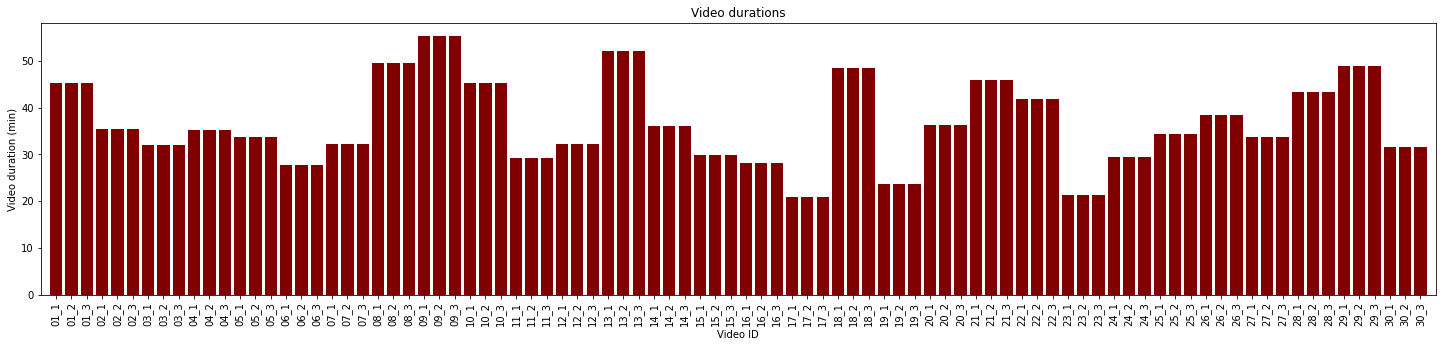

In [162]:
ind = np.arange(len(video_ids))
plt.figure(figsize=(25,5))
plt.bar(ind, video_durations, color='maroon')
plt.xticks(ind, video_ids, rotation=90)
plt.xlim(-1, 90)
plt.xlabel('Video ID')
plt.ylabel('Video duration (min)')
plt.title('Video durations')
plt.show()


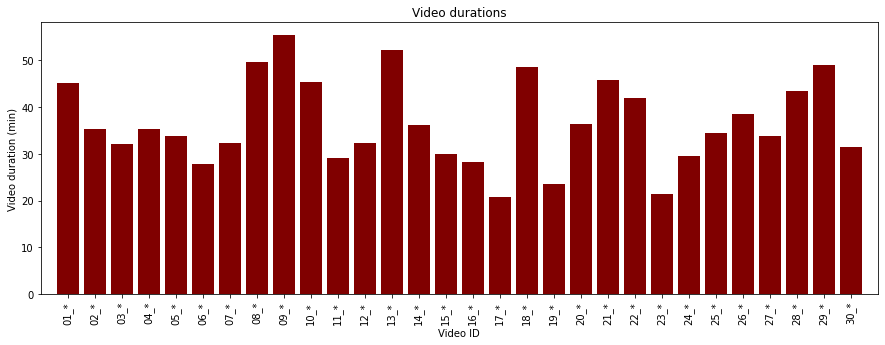

In [167]:
ind = np.arange(len(video_ids[::3]))
plt.figure(figsize=(15,5))
plt.bar(ind, video_durations[::3], color='maroon')
plt.xticks(ind, [video_id[:-1] + '*' for video_id in video_ids[::3]], rotation=90)
plt.xlim(-1, 30)
plt.xlabel('Video ID')
plt.ylabel('Video duration (min)')
plt.title('Video durations')
plt.show()


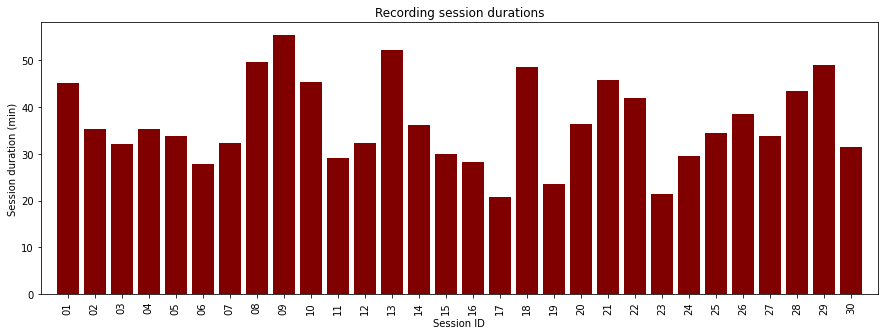

In [168]:
ind = np.arange(len(video_ids[::3]))
plt.figure(figsize=(15,5))
plt.bar(ind, video_durations[::3], color='maroon')
plt.xticks(ind, [video_id[:-2] for video_id in video_ids[::3]], rotation=90)
plt.xlim(-1, 30)
plt.xlabel('Session ID')
plt.ylabel('Session duration (min)')
plt.title('Recording session durations')
plt.show()


Bin width: 2 minutes


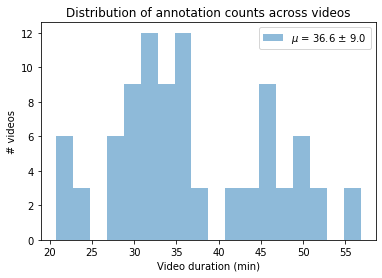

In [169]:
bin_width = 2 # in minutes
print(f"Bin width: {bin_width} minutes")
plt.figure()
bins_range = np.arange(min(video_durations), max(video_durations) + bin_width, bin_width)
plt.hist(video_durations, alpha=0.5, bins=bins_range, 
         label=fr'$\mu$ = {np.mean(video_durations):.1f} $\pm$ {np.std(video_durations):.1f}')
# plt.xlim(0, 4)
plt.legend()
plt.xlabel('Video duration (min)')
plt.ylabel('# videos')
plt.title('Distribution of annotation counts across videos')
plt.show()

## 4.3 Annotation frequency

### 4.3.1 Overall 

In [25]:
tier_names = [
    'mouth_open',

    'food_entered',
    'food_lifted',
    'food_to_mouth',

    'drink_entered',
    'drink_lifted',
    'drink_to_mouth',

    'napkin_entered',
    'napkin_lifted',
    'napkin_to_mouth',

    'disruption'
]

video_ids = []
annotation_frequencies = []
for video_file in sorted(glob.glob(f'{videos_folder}/*_[1-3].mp4')):
    video_id = video_file.split('/')[-1].split('.')[0]
    video_ids.append(video_id)

    video_data = cv2.VideoCapture(video_file)
    duration = video_data.get(cv2.CAP_PROP_FRAME_COUNT) / video_data.get(cv2.CAP_PROP_FPS) / 60

    eaf_obj1 = pympi.Elan.Eaf(f'{annotations_folder}/{video_id}.eaf')
    num_annotations = sum( len(eaf_obj1.get_annotation_data_for_tier(tier_name)) for tier_name in tier_names )
    annotation_frequencies.append( num_annotations / duration )

print(f'Annotation frequencies:')
print(f'\t min = {min(annotation_frequencies)} annotations per min, \t video ID = {video_ids[np.argmin(annotation_frequencies)]}')
print(f'\t max = {max(annotation_frequencies)} annotations per min, \t video ID = {video_ids[np.argmax(annotation_frequencies)]}')
print(f'\t mean = {np.mean(annotation_frequencies)} annotations per min')
print(f'\t std = {np.std(annotation_frequencies)} annotations per min')


Annotation frequencies:
	 min = 2.4429912622121517 annotations per min, 	 video ID = 08_2
	 max = 30.55008043980865 annotations per min, 	 video ID = 13_2
	 mean = 9.317759869509914 annotations per min
	 std = 4.638698129921756 annotations per min


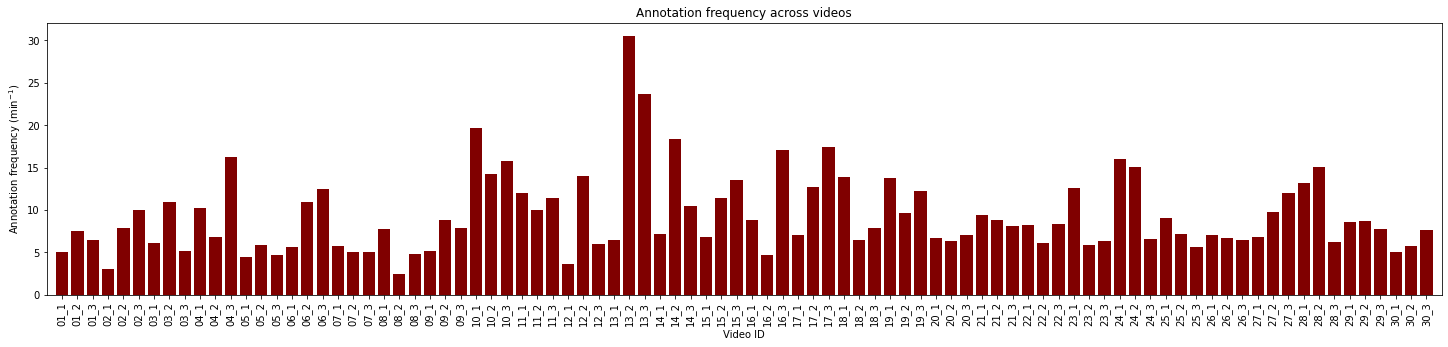

In [175]:
ind = np.arange(len(video_ids))
plt.figure(figsize=(25,5))
plt.bar(ind, annotation_frequencies, color='maroon')
plt.xticks(ind, video_ids, rotation=90)
plt.xlim(-1, 90)
plt.xlabel('Video ID')
plt.ylabel(r'Annotation frequency (min$^{-1}$)')
plt.title('Annotation frequency across videos')
plt.show()


Bin width: 1 minutes


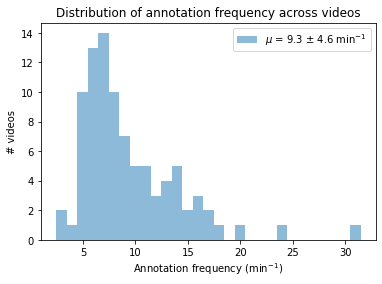

In [180]:
bin_width = 1 # in minutes^-1
print(f"Bin width: {bin_width} minutes")
plt.figure()
bins_range = np.arange(min(annotation_frequencies), max(annotation_frequencies) + bin_width, bin_width)
plt.hist(annotation_frequencies, alpha=0.5, bins=bins_range, 
         label=fr'$\mu$ = {np.mean(annotation_frequencies):.1f} $\pm$ {np.std(annotation_frequencies):.1f} min$^{{-1}}$')
# plt.xlim(0, 4)
plt.legend()
plt.xlabel(r'Annotation frequency (min$^{-1}$)')
plt.ylabel('# videos')
plt.title('Distribution of annotation frequency across videos')
plt.show()

### 4.3.2 By annotation type

In [28]:
tier_names = [
    # 'mouth_open',

    # 'food_entered',
    # 'food_lifted',
    'food_to_mouth',

    # 'drink_entered',
    # 'drink_lifted',
    'drink_to_mouth',

    # 'napkin_entered',
    # 'napkin_lifted',
    'napkin_to_mouth',

    'disruption'
]

video_ids = []
annotation_frequencies_by_type = {}
for video_file in sorted(glob.glob(f'{videos_folder}/*_[1-3].mp4')):
    video_id = video_file.split('/')[-1].split('.')[0]
    video_ids.append(video_id)

    video_data = cv2.VideoCapture(video_file)
    duration = video_data.get(cv2.CAP_PROP_FRAME_COUNT) / video_data.get(cv2.CAP_PROP_FPS) / 60

    eaf_obj1 = pympi.Elan.Eaf(f'{annotations_folder}/{video_id}.eaf')
    annotation_frequencies_by_type[video_id] = { tier_name: len(eaf_obj1.get_annotation_data_for_tier(tier_name)) / duration 
                                                 for tier_name in tier_names }


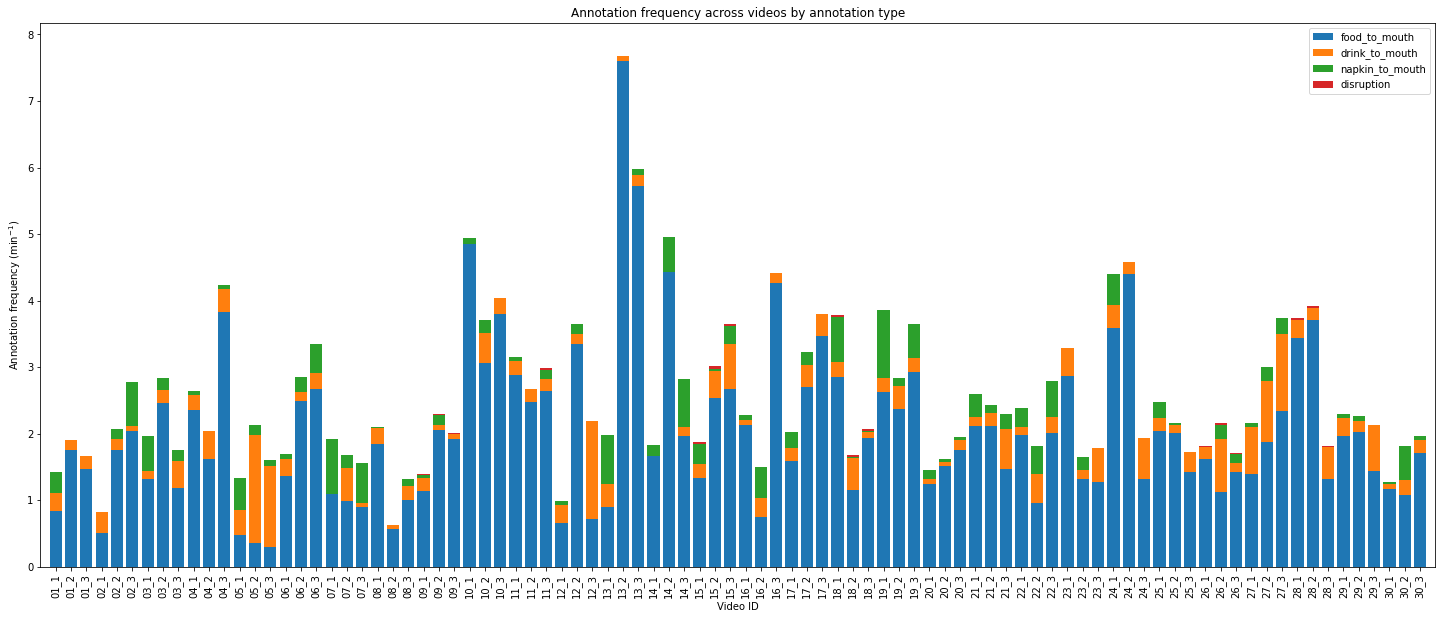

In [29]:
ind = np.arange(len(video_ids))
plt.figure(figsize=(25,10))
prev_y = 0
for tier_name in tier_names:
    y = np.array([ annotation_frequencies_by_type[video_id][tier_name] for video_id in video_ids ])
    plt.bar(ind, y, bottom=prev_y, label=tier_name)
    prev_y += y
plt.xticks(ind, video_ids, rotation=90)
plt.xlim(-1, 90)
plt.ylim(0, max(prev_y) + 0.5)
plt.xlabel('Video ID')
plt.ylabel(r'Annotation frequency (min$^{-1}$)')
plt.title('Annotation frequency across videos by annotation type')
plt.legend()
plt.show()


Bin width: 0.05 annotations


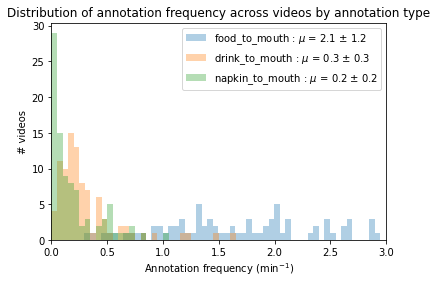

In [30]:
bin_width = 0.05 # in number of annotations
print(f"Bin width: {bin_width} annotations")
plt.figure()
for tier_name in tier_names[:-1]:
    y = np.array([ annotation_frequencies_by_type[video_id][tier_name] for video_id in video_ids ])
    bins_range = np.arange(min(y), max(y) + bin_width, bin_width)
    plt.hist(y, alpha=0.35, bins=bins_range, 
            label=fr'{tier_name} : $\mu$ = {np.mean(y):.1f} $\pm$ {np.std(y):.1f}')
plt.xlim(0, 3)
plt.legend()
plt.xlabel(r'Annotation frequency (min$^{-1}$)')
plt.ylabel('# videos')
plt.title('Distribution of annotation frequency across videos by annotation type')
plt.show()


Excluding videos with no annotations of that annotation type:
Bin width: 0.05 annotations


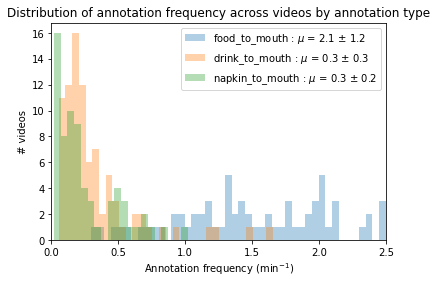

In [32]:
###########################################################################
print(f"Excluding videos with no annotations of that annotation type:")
###########################################################################
bin_width = 0.05 # in number of annotations
print(f"Bin width: {bin_width} annotations")
plt.figure()
for tier_name in tier_names[:-1]:
    y = np.array([ annotation_frequencies_by_type[video_id][tier_name] for video_id in video_ids if annotation_frequencies_by_type[video_id][tier_name] > 0 ])
    bins_range = np.arange(min(y), max(y) + bin_width, bin_width)
    plt.hist(y, alpha=0.35, bins=bins_range, 
            label=fr'{tier_name} : $\mu$ = {np.mean(y):.1f} $\pm$ {np.std(y):.1f}')
plt.xlim(0, 2.5)
plt.legend()
plt.xlabel(r'Annotation frequency (min$^{-1}$)')
plt.ylabel('# videos')
plt.title('Distribution of annotation frequency across videos by annotation type')
plt.show()


### 4.3.3 By annotation value

In [33]:
tier_names = [
    # 'mouth_open',

    # 'food_entered',
    # 'food_lifted',
    'food_to_mouth',

    # 'drink_entered',
    # 'drink_lifted',
    'drink_to_mouth',

    # 'napkin_entered',
    # 'napkin_lifted',
    # 'napkin_to_mouth',

    # 'disruption'
]

video_ids = []
annotation_values = { tier_name: set() for tier_name in tier_names }
annotation_frequencies_by_value = {}
for video_file in sorted(glob.glob(f'{videos_folder}/*_[1-3].mp4')):
    video_id = video_file.split('/')[-1].split('.')[0]
    video_ids.append(video_id)

    video_data = cv2.VideoCapture(video_file)
    duration = video_data.get(cv2.CAP_PROP_FRAME_COUNT) / video_data.get(cv2.CAP_PROP_FPS) / 60

    eaf_obj1 = pympi.Elan.Eaf(f'{annotations_folder}/{video_id}.eaf')
    annotation_frequencies_by_value[video_id] = {}
    for tier_name in tier_names:
        counter = Counter( annotation_value for _, _, annotation_value in eaf_obj1.get_annotation_data_for_tier(tier_name) )
        annotation_frequencies_by_value[video_id][tier_name] = Counter({ k: counter[k] / duration for k in counter.keys() })
        annotation_values[tier_name].update(annotation_frequencies_by_value[video_id][tier_name].keys())


Skipping 'knife' and empty annotation values for food_to_mouth annotations
Skipping 'knife' and empty annotation values for food_to_mouth annotations


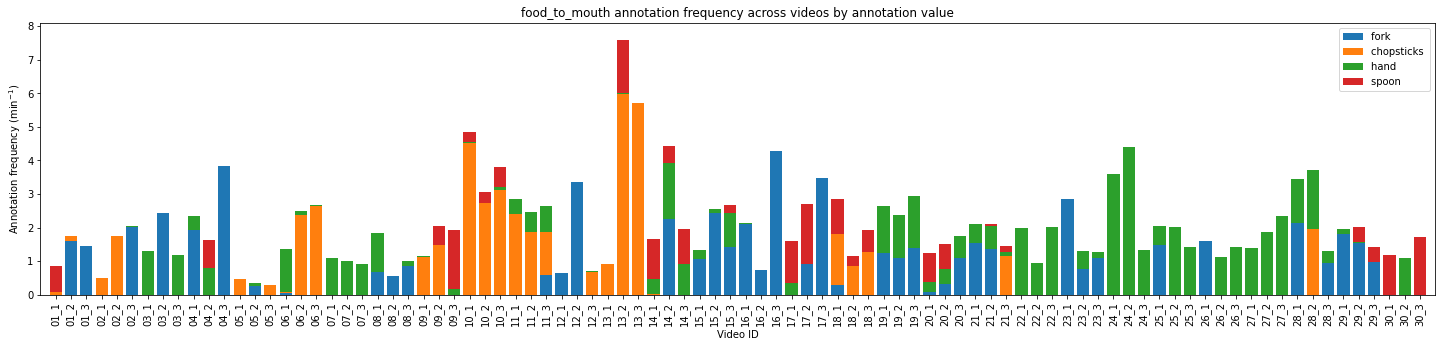

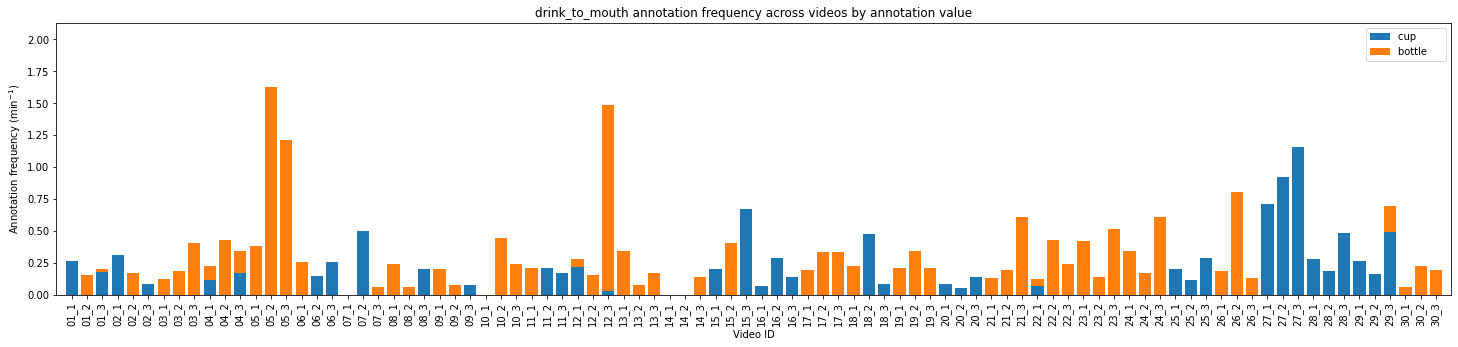

In [34]:
ind = np.arange(len(video_ids))
for tier_name in tier_names:
    plt.figure(figsize=(25,5))
    prev_y = 0
    for annotation_value in annotation_values[tier_name]:
        # Skip 'knife' and empty annotation values for food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and tier_name == 'food_to_mouth'):
            print("Skipping 'knife' and empty annotation values for food_to_mouth annotations")
            continue
        y = np.array([ annotation_frequencies_by_value[video_id][tier_name][annotation_value] for video_id in video_ids ])
        plt.bar(ind, y, bottom=prev_y, label=fr'{annotation_value:<11}')
        prev_y += y
    plt.xticks(ind, video_ids, rotation=90)
    plt.xlim(-1, 90)
    plt.ylim(0, max(prev_y) + 0.5)
    plt.xlabel('Video ID')
    plt.ylabel(r'Annotation frequency (min$^{-1}$)')
    plt.title(f'{tier_name} annotation frequency across videos by annotation value')
    plt.legend()
    plt.show()


Bin width: 0.01 annotations
Skipping 'knife' and empty annotation values for food_to_mouth annotations
Skipping 'knife' and empty annotation values for food_to_mouth annotations


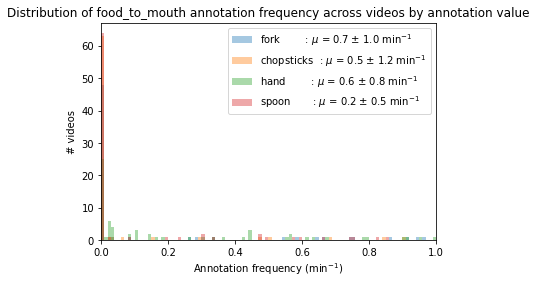

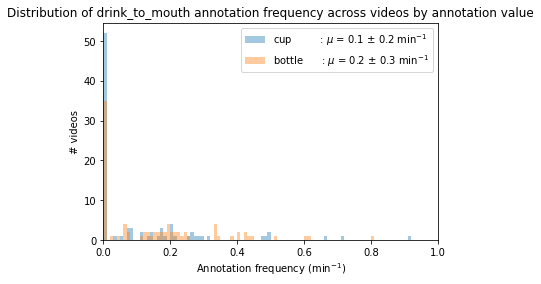

In [35]:
bin_width = 0.01 # in number of annotations
print(f"Bin width: {bin_width} annotations")
for tier_name in tier_names:
    plt.figure()
    for annotation_value in annotation_values[tier_name]:
        # Skip 'knife' and empty annotation values for food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and tier_name == 'food_to_mouth'):
            print("Skipping 'knife' and empty annotation values for food_to_mouth annotations")
            continue
        y = np.array([ annotation_frequencies_by_value[video_id][tier_name][annotation_value] for video_id in video_ids ])
        bins_range = np.arange(min(y), max(y) + bin_width, bin_width)
        plt.hist(y, alpha=0.4, bins=bins_range, 
                label=fr'{annotation_value:<11} : $\mu$ = {np.mean(y):.1f} $\pm$ {np.std(y):.1f} min$^{{-1}}$')
    plt.xlim(0, 1)
    plt.legend()
    plt.xlabel(r'Annotation frequency (min$^{-1}$)')
    plt.ylabel('# videos')
    plt.title(f'Distribution of {tier_name} annotation frequency across videos by annotation value')
    plt.show()


Excluding videos with no annotations with that annotation value:
Bin width: 0.05 annotations
Skipping 'knife' and empty annotation values for food_to_mouth annotations
Skipping 'knife' and empty annotation values for food_to_mouth annotations


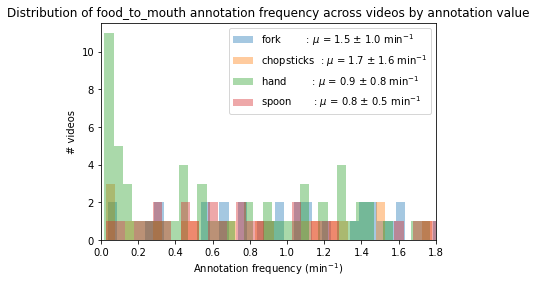

Bin width: 0.01 annotations


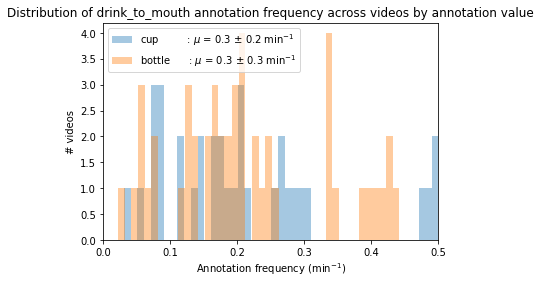

In [41]:
###########################################################################
print(f"Excluding videos with no annotations with that annotation value:")
###########################################################################
for tier_name, xmax, bin_width in zip(tier_names, [1.8, 0.5], [0.05, 0.01]):
    print(f"Bin width: {bin_width} annotations")
    plt.figure()
    for annotation_value in annotation_values[tier_name]:
        # Skip 'knife' and empty annotation values for food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and tier_name == 'food_to_mouth'):
            print("Skipping 'knife' and empty annotation values for food_to_mouth annotations")
            continue
        y = np.array([ annotation_frequencies_by_value[video_id][tier_name][annotation_value] for video_id in video_ids if annotation_frequencies_by_value[video_id][tier_name][annotation_value] > 0 ])
        bins_range = np.arange(min(y), max(y) + bin_width, bin_width)
        plt.hist(y, alpha=0.4, bins=bins_range, 
                label=fr'{annotation_value:<11} : $\mu$ = {np.mean(y):.1f} $\pm$ {np.std(y):.1f} min$^{{-1}}$')
    plt.xlim(0, xmax)
    plt.legend()
    plt.xlabel(r'Annotation frequency (min$^{-1}$)')
    plt.ylabel('# videos')
    plt.title(f'Distribution of {tier_name} annotation frequency across videos by annotation value')
    plt.show()


## 4.4 Food types

In [88]:
food_types_df = pd.read_csv(annotation_food_types_file, delimiter='\t')
food_types_counter = Counter( food_type for food_types_per_video in food_types_df['Food types'] for food_type in food_types_per_video.split(', ') )
food_types, food_types_counts = zip(*reversed(food_types_counter.most_common()))


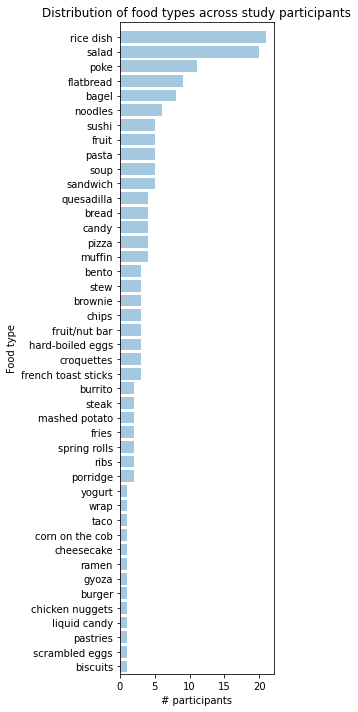

In [107]:
# plt.figure()
plt.figure(figsize=(4,10))
plt.barh(food_types, food_types_counts, alpha=0.4)
# plt.xlabel('# videos')
plt.xlabel('# participants')
plt.ylabel('Food type')
plt.ylim(-0.5, len(food_types))
# plt.title(f'Distribution of food types across videos')
plt.title(f'Distribution of food types across study participants')
plt.tight_layout()
plt.show()


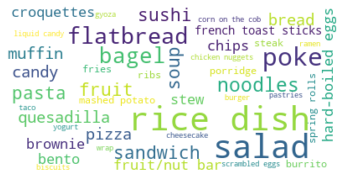

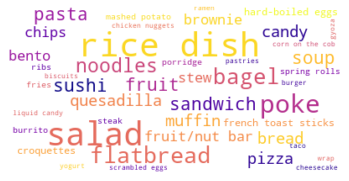

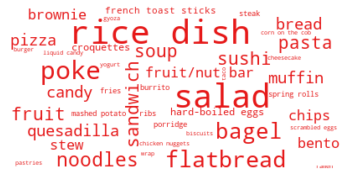

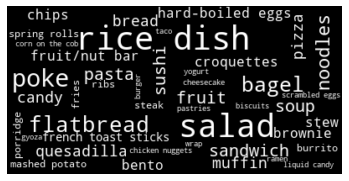

In [142]:
wordcloud = WordCloud(max_font_size=40, background_color='white').generate_from_frequencies(food_types_counter)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud = WordCloud(max_font_size=40, background_color='white', colormap="plasma").generate_from_frequencies(food_types_counter)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Perhaps set the color based on the frequency/term font size
def frequency_color_func(word, **kwargs):
     return "hsl(%d, 80%%, 50%%)" % (360 * food_types_counter[word])
wordcloud = WordCloud(max_font_size=40, background_color='white', color_func=frequency_color_func).generate_from_frequencies(food_types_counter)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud = WordCloud(max_font_size=40, background_color='black', color_func=lambda *args, **kwargs: "white").generate_from_frequencies(food_types_counter)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# 5 Dining time-dependent statistics

## 5.1 Number of annotations

### 5.1.1 Overall

In [58]:
tier_names = [
    'mouth_open',

    'food_entered',
    'food_lifted',
    'food_to_mouth',

    'drink_entered',
    'drink_lifted',
    'drink_to_mouth',

    'napkin_entered',
    'napkin_lifted',
    'napkin_to_mouth',

    'disruption'
]

video_ids = []
start_times = {}
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    video_id = annotation_file.split('/')[-1].split('.')[0]
    video_ids.append(video_id)

    eaf_obj1 = pympi.Elan.Eaf(annotation_file)
    start_times[video_id] = [ start_time / 60000. for tier_name in tier_names for start_time, _, _ in eaf_obj1.get_annotation_data_for_tier(tier_name) ]


Bin width: 1 min


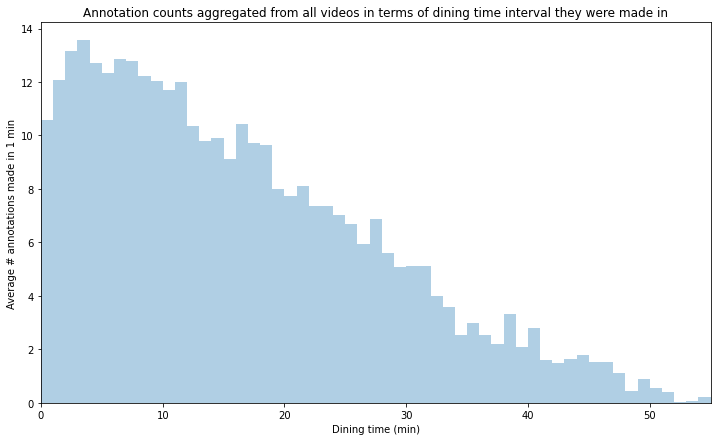

In [63]:
start_times_flattened = [ t for video_start_times in start_times.values() for t in video_start_times ]

bin_width = 1 # in minutes
print(f"Bin width: {bin_width} min")
plt.figure(figsize=(12,7))
bins_range = np.arange(min(start_times_flattened), max(start_times_flattened) + bin_width, bin_width)
y, _ = np.histogram(start_times_flattened, bins=bins_range)
plt.bar(bins_range[:-1], y / len(video_ids), width=bin_width, alpha=0.35, align='edge')
# plt.hist(start_times_flattened / len(video_ids), alpha=0.35, bins=bins_range)
plt.xlim(0, bins_range[-1])
plt.xlabel('Dining time (min)')
plt.ylabel(f'Average # annotations made in {bin_width} min')
plt.title('Annotation counts aggregated from all videos in terms of dining time interval they were made in')
plt.show()


In [320]:
def plot_boxplot(bin_width, normalize):
    #bin_width = 1 # in minutes
    print(f"Bin width: {bin_width} minutes")
    all_video_bin_counts = []
    for video_id in video_ids:
        bins_range = np.arange(0, max(start_times[video_id]) + bin_width, bin_width)
        bin_counts, _ = np.histogram(start_times[video_id], bins=bins_range)
        if normalize:
            # Normalize by the total annotation count in that video
            all_video_bin_counts.append(bin_counts / len(start_times[video_id]))
        else:
            all_video_bin_counts.append(bin_counts)

    aggregated_bin_counts = list(zip_longest(*all_video_bin_counts, fillvalue=0))
    x_positions = (bin_width / 2) + np.arange(0, len(aggregated_bin_counts) * bin_width, step=bin_width)
    x_ticks = np.arange(0, (1 + len(aggregated_bin_counts)) * bin_width, step=bin_width)
    c = 'blue'
    plt.figure(figsize=(20,5))
    plt.boxplot(aggregated_bin_counts,
        positions=x_positions,
        widths=bin_width,
        # meanline=True, 
        showmeans=True,
        notch=True,
        showfliers=False,
        patch_artist=True,
        boxprops=dict(facecolor=c, color=c, alpha=0.2),
        capprops=dict(color=c),
        whiskerprops=dict(color=c),
        flierprops=dict(color=c, markeredgecolor=c),
        medianprops=dict(color=c),
        # meanprops=dict(marker='+')
    )
    plt.xticks(x_ticks, x_ticks)
    plt.xlabel('Dining time (min)')
    if normalize:
        plt.ylabel(f'Fraction of video annotations made in {bin_width} min')
        plt.title('Distributions of annotation counts from all videos in terms of dining time interval they were made in, normalized by total annotation count in video')
    else:
        plt.ylabel(f'# annotations made in {bin_width} min')
        plt.title('Distributions of annotation counts from all videos in terms of dining time interval they were made in')
    plt.show()


Bin width: 1 minutes


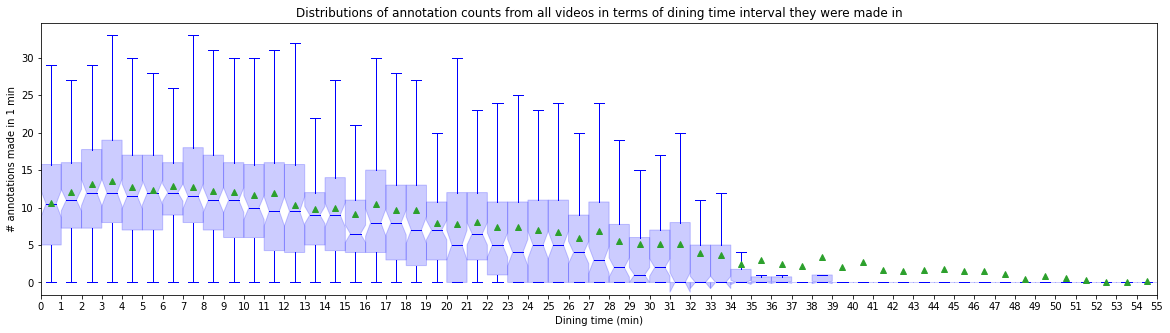

Bin width: 1 minutes


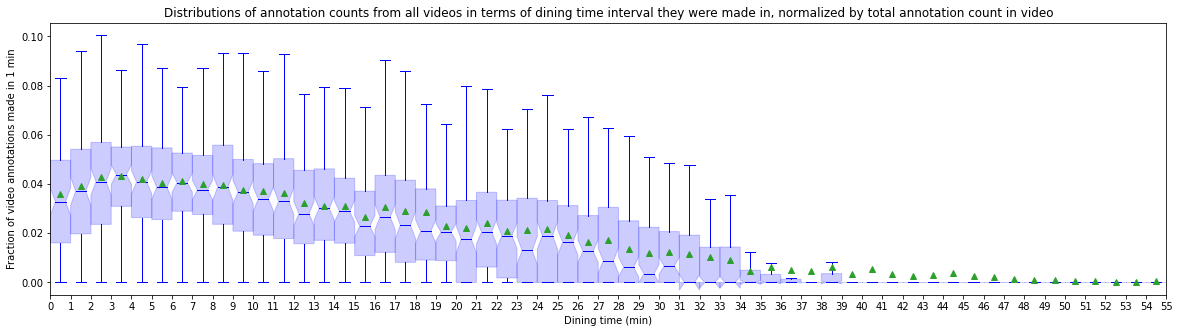

In [321]:
plot_boxplot(bin_width=1, normalize=False)
plot_boxplot(bin_width=1, normalize=True)


Bin width: 0.25 minutes


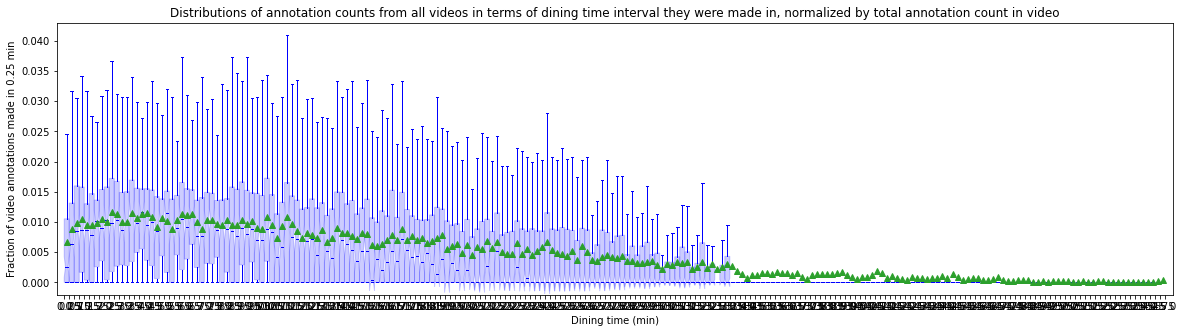

Bin width: 0.5 minutes


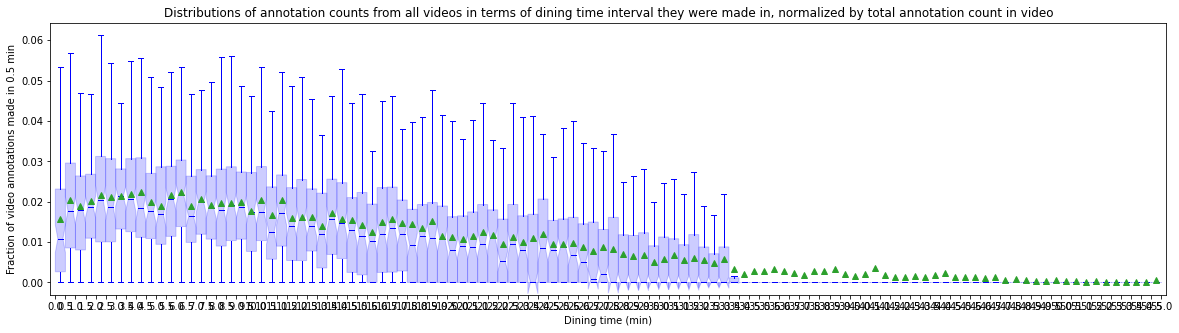

Bin width: 0.75 minutes


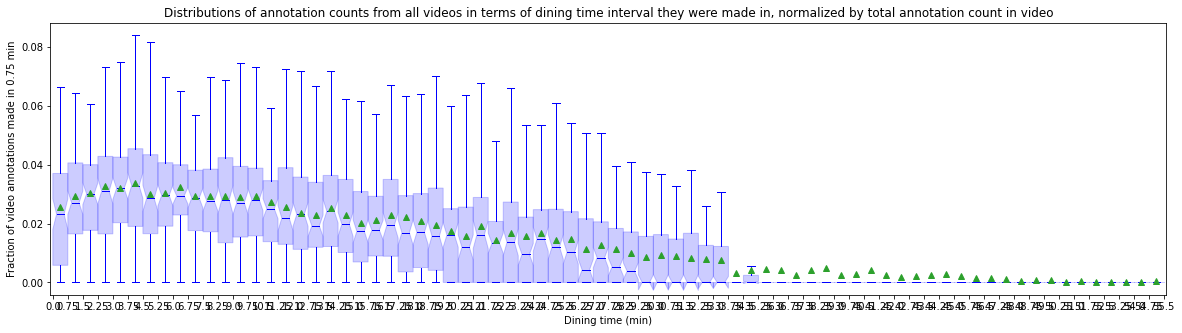

Bin width: 1 minutes


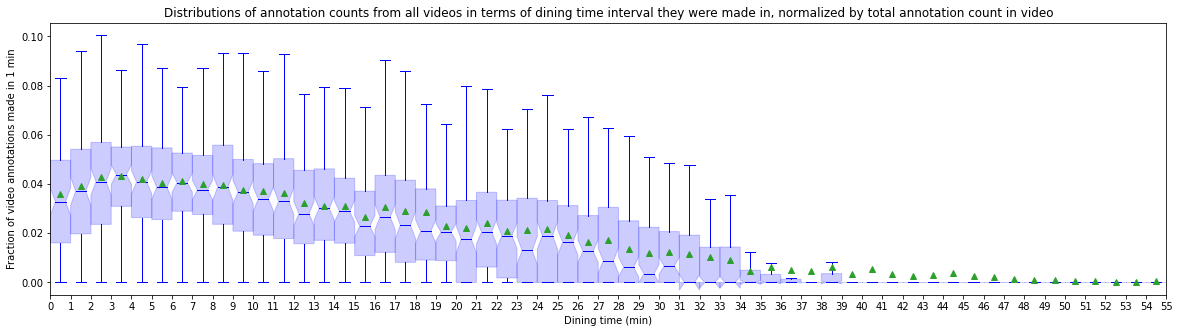

Bin width: 1.5 minutes


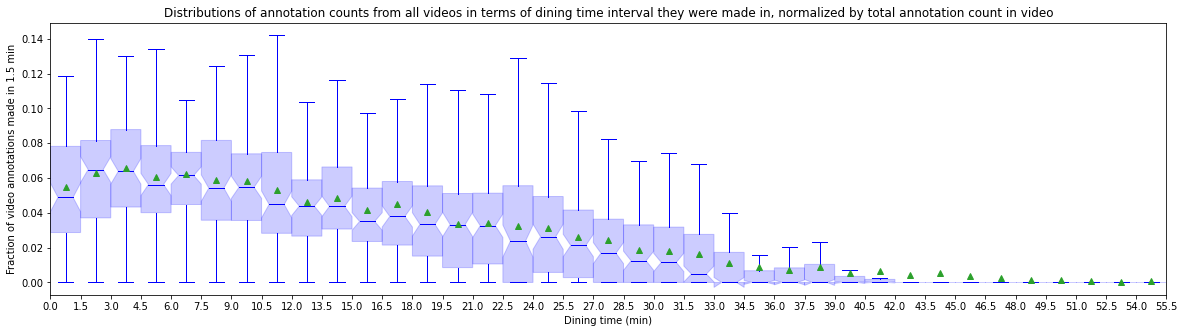

Bin width: 2 minutes


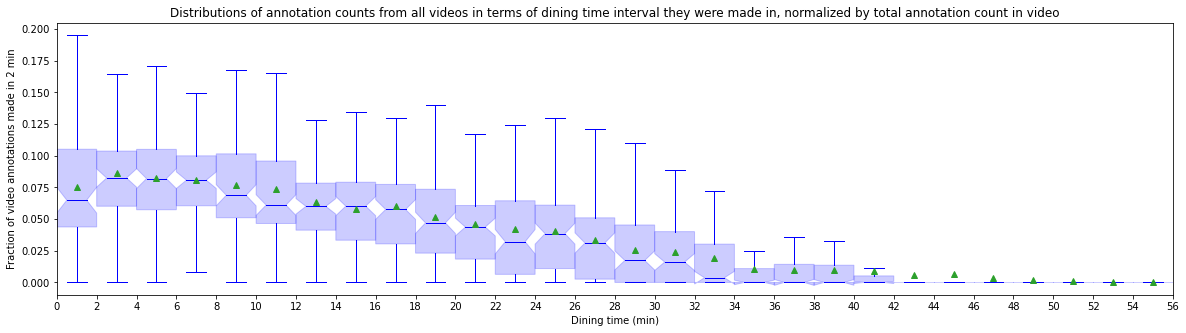

Bin width: 5 minutes


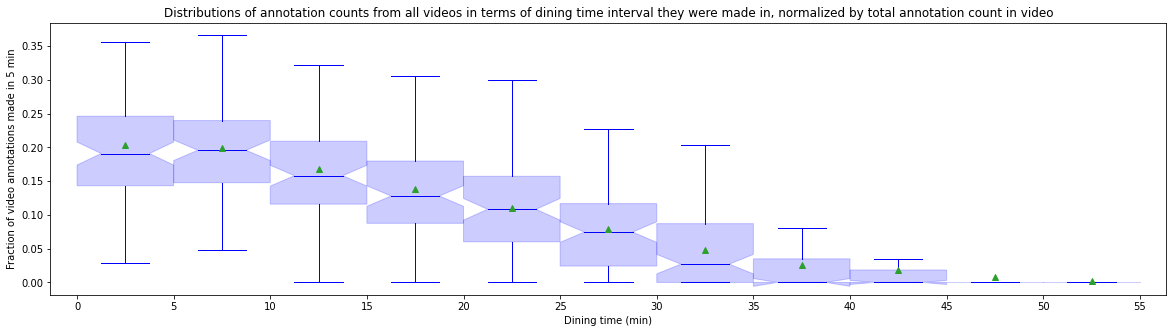

Bin width: 7 minutes


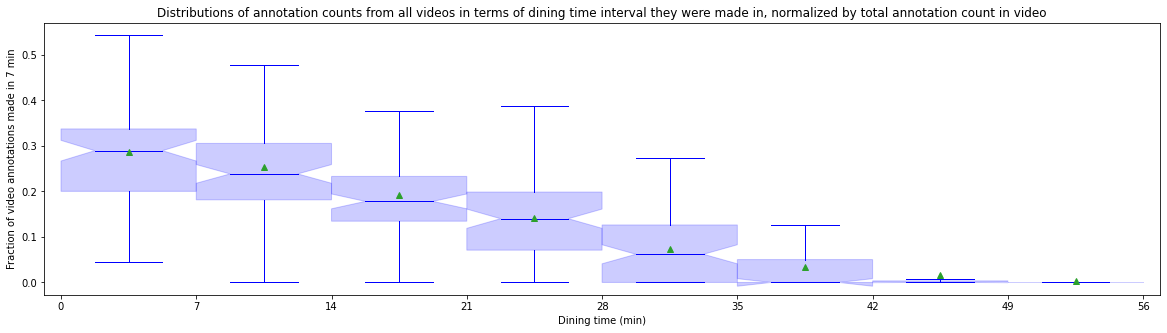

In [325]:
for bin_width in [0.25, 0.5, 0.75, 1, 1.5, 2, 5, 7]:
    plot_boxplot(bin_width=bin_width, normalize=True)
# => bin_width=1 is a good choice


x bin width: 1 minutes
y bin width: 1.0 % of video annotations made in 1 minutes


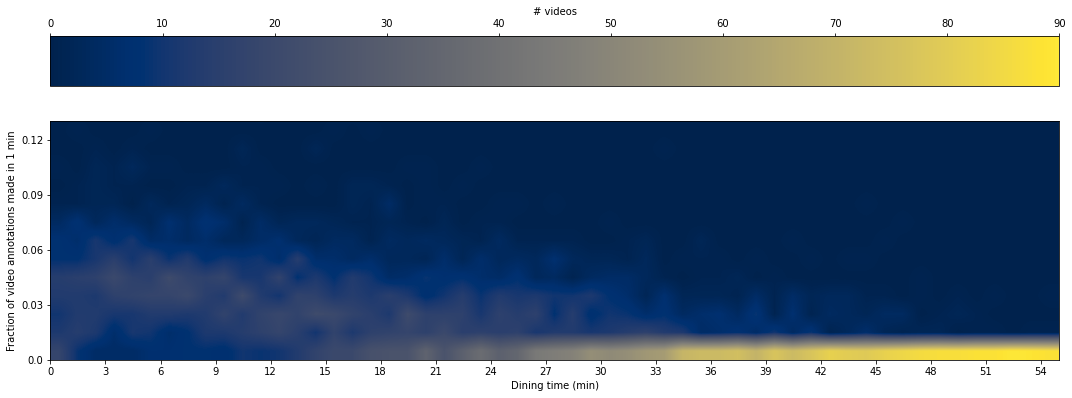

In [53]:
x_bin_width = 1 # in minutes
print(f"x bin width: {x_bin_width} minutes")
all_video_x_bin_counts = []
for video_id in video_ids:
    x_bins_range = np.arange(0, max(start_times[video_id]) + x_bin_width, x_bin_width)
    x_bin_counts, _ = np.histogram(start_times[video_id], bins=x_bins_range)
    # Normalize by the total annotation count in that video
    all_video_x_bin_counts.append(x_bin_counts / len(start_times[video_id]))
aggregated_x_bin_counts = np.array(list(zip_longest(*all_video_x_bin_counts, fillvalue=0)))

y_bin_width = 0.01 # as a raction of video annotations made in {x_bin_width} minutes
print(f"y bin width: {y_bin_width * 100} % of video annotations made in {x_bin_width} minutes")
y_bins_range = np.arange(0, np.max(aggregated_x_bin_counts) + y_bin_width, y_bin_width)
heatmap_data = []
for a in aggregated_x_bin_counts:
    y_bin_counts, _ = np.histogram(a, bins=y_bins_range)
    heatmap_data.append(y_bin_counts)
heatmap_data = np.array(heatmap_data)

plt.figure(figsize=(15, 10))
plt.imshow(heatmap_data.T, cmap='cividis', origin='lower', 
    interpolation='bilinear'
)
plt.colorbar(label='# videos', orientation='horizontal', location='top')
xticks_step = 3
plt.xticks(np.arange(len(aggregated_x_bin_counts) + 1, step=xticks_step) - 0.5, np.arange(0, (len(aggregated_x_bin_counts) + 1) * x_bin_width, step=xticks_step * x_bin_width))
yticks_step = 3
plt.yticks(np.arange(len(y_bins_range), step=yticks_step) - 0.5, np.arange(0, len(y_bins_range) * y_bin_width, step=yticks_step * y_bin_width))
plt.ylim(-0.5, len(y_bins_range)/2)
plt.xlabel('Dining time (min)')
plt.ylabel(f'Fraction of video annotations made in {x_bin_width} min')
plt.tight_layout()
plt.show()


### 5.1.2 By annotation type

In [48]:
tier_names = [
    # 'mouth_open',

    # 'food_entered',
    # 'food_lifted',
    'food_to_mouth',

    # 'drink_entered',
    # 'drink_lifted',
    'drink_to_mouth',

    # 'napkin_entered',
    # 'napkin_lifted',
    'napkin_to_mouth',

    # 'disruption'
]

video_ids = []
start_times_by_type = {}
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    video_id = annotation_file.split('/')[-1].split('.')[0]
    video_ids.append(video_id)

    eaf_obj1 = pympi.Elan.Eaf(annotation_file)
    start_times_by_type[video_id] = {}
    for tier_name in tier_names:
        start_times_by_type[video_id][tier_name] = [ start_time / 60000. for start_time, _, _ in eaf_obj1.get_annotation_data_for_tier(tier_name) ]


Bin width: 1 minutes


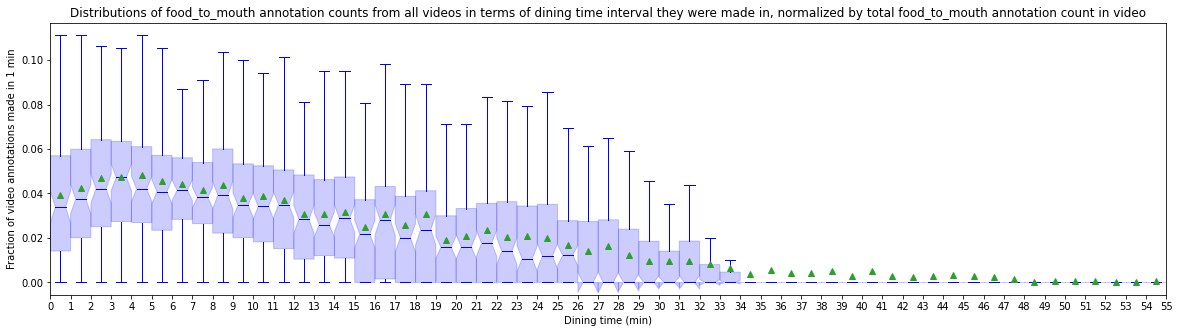

In [51]:
tier_name = 'food_to_mouth'
normalize = True
bin_width = 1 # in minutes
print(f"Bin width: {bin_width} minutes")
all_video_bin_counts = []
for video_id in video_ids:
    bins_range = np.arange(0, max(start_times_by_type[video_id][tier_name], default=0) + bin_width, bin_width)
    bin_counts, _ = np.histogram(start_times_by_type[video_id][tier_name], bins=bins_range)
    if normalize:
        # Normalize by the total annotation count in that video
        all_video_bin_counts.append(bin_counts / len(start_times_by_type[video_id][tier_name]))
    else:
        all_video_bin_counts.append(bin_counts)

aggregated_bin_counts = list(zip_longest(*all_video_bin_counts, fillvalue=0))
x_positions = (bin_width / 2) + np.arange(0, len(aggregated_bin_counts) * bin_width, step=bin_width)
x_ticks = np.arange(0, (1 + len(aggregated_bin_counts)) * bin_width, step=bin_width)
c = 'blue'
plt.figure(figsize=(20,5))
plt.boxplot(aggregated_bin_counts,
    positions=x_positions,
    widths=bin_width,
    # meanline=True, 
    showmeans=True,
    notch=True,
    showfliers=False,
    patch_artist=True,
    boxprops=dict(facecolor=c, color=c, alpha=0.2),
    capprops=dict(color=c),
    whiskerprops=dict(color=c),
    flierprops=dict(color=c, markeredgecolor=c),
    medianprops=dict(color=c),
    # meanprops=dict(marker='+')
)
plt.xticks(x_ticks, x_ticks)
plt.xlabel('Dining time (min)')
if normalize:
    plt.ylabel(f'Fraction of video annotations made in {bin_width} min')
    plt.title(f'Distributions of {tier_name} annotation counts from all videos in terms of dining time interval they were made in, normalized by total {tier_name} annotation count in video')
else:
    plt.ylabel(f'# annotations made in {bin_width} min')
    plt.title(f'Distributions of {tier_name} annotation counts from all videos in terms of dining time interval they were made in')
plt.show()


Bin width: 1 minutes


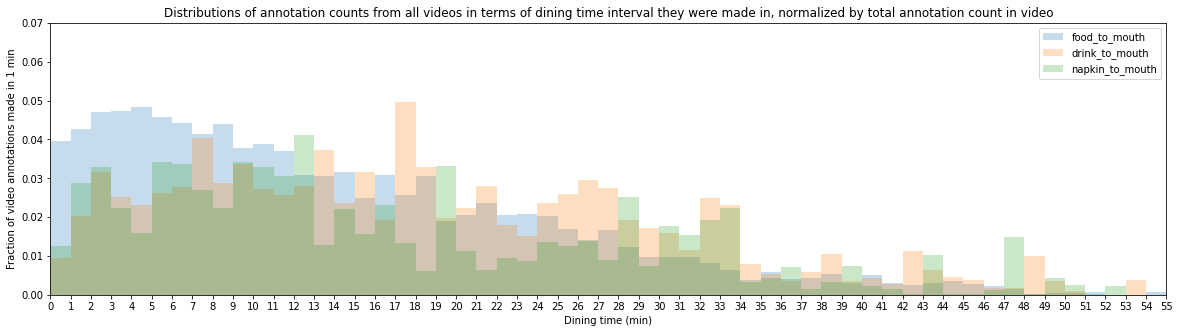

In [53]:
normalize = True
bin_width = 1 # in minutes
print(f"Bin width: {bin_width} minutes")
x_ticks = []
plt.figure(figsize=(20,5))
for tier_name in tier_names:
    all_video_bin_counts = []
    for video_id in video_ids:
        bins_range = np.arange(0, max(start_times_by_type[video_id][tier_name], default=0) + bin_width, bin_width)
        bin_counts, _ = np.histogram(start_times_by_type[video_id][tier_name], bins=bins_range)
        if normalize:
            # Normalize by the total annotation count in that video
            all_video_bin_counts.append(bin_counts / len(start_times_by_type[video_id][tier_name]))
        else:
            all_video_bin_counts.append(bin_counts)

    aggregated_bin_counts = list(zip_longest(*all_video_bin_counts, fillvalue=0))
    x_positions = (bin_width / 2) + np.arange(0, len(aggregated_bin_counts) * bin_width, step=bin_width)
    if 1 + len(aggregated_bin_counts) > len(x_ticks):
        x_ticks = np.arange(0, (1 + len(aggregated_bin_counts)) * bin_width, step=bin_width)
    plt.bar(x_positions, np.mean(aggregated_bin_counts, axis=1), width=bin_width, alpha=0.25, label=tier_name)
plt.xticks(x_ticks, x_ticks)
plt.xlabel('Dining time (min)')
plt.xlim(0, x_ticks[-1])
if normalize:
    plt.ylabel(f'Fraction of video annotations made in {bin_width} min')
    plt.title('Distributions of annotation counts from all videos in terms of dining time interval they were made in, normalized by total annotation count in video')
else:
    plt.ylabel(f'# annotations made in {bin_width} min')
    plt.title('Distributions of annotation counts from all videos in terms of dining time interval they were made in')
plt.ylim(0, 0.07)
plt.legend()
plt.show()


Bin width: 1 minutes
Error bars correspond to 1 std


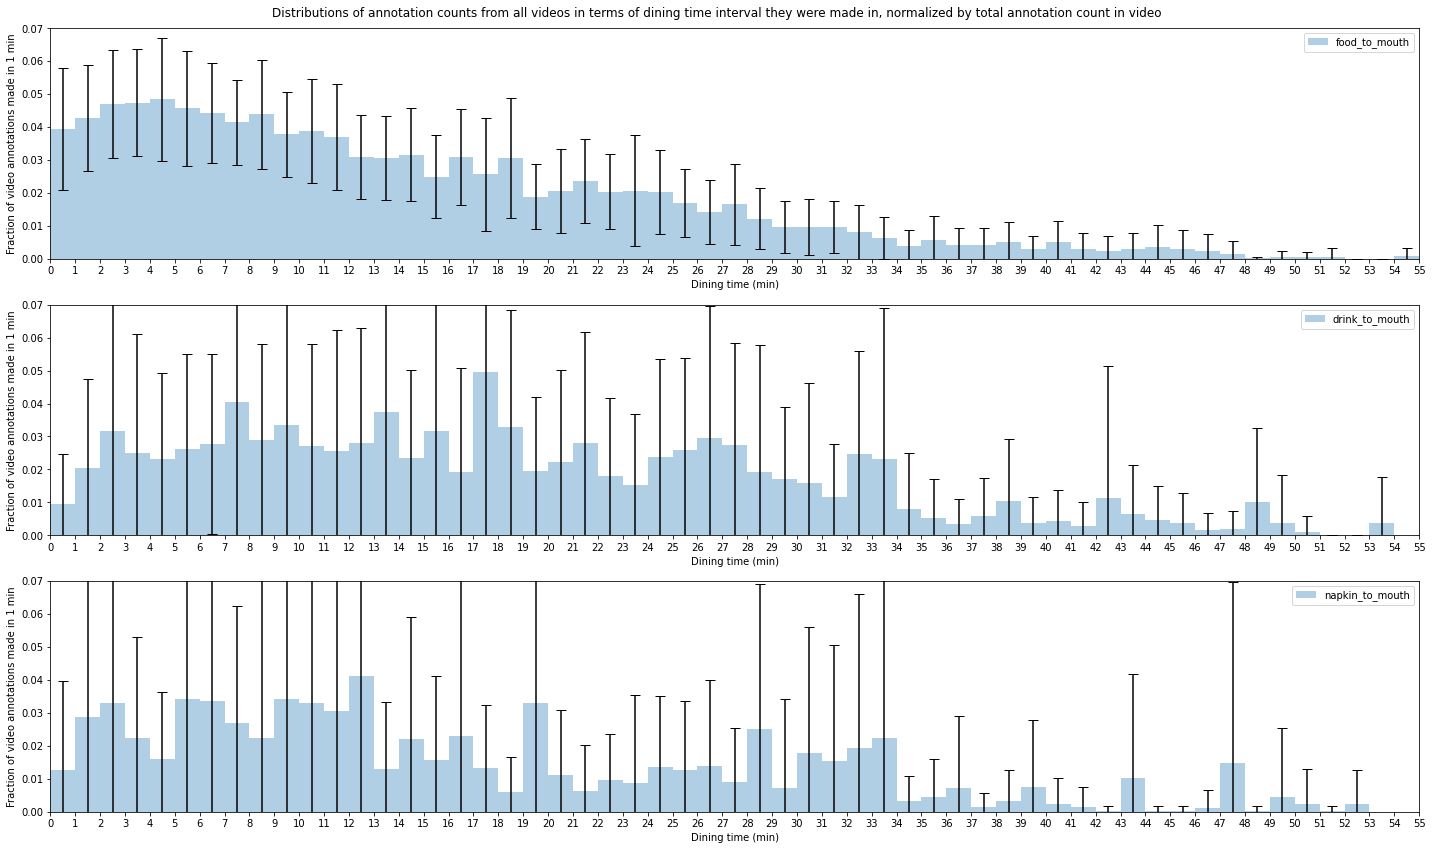

In [32]:
normalize = True
bin_width = 1 # in minutes
print(f"Bin width: {bin_width} minutes")
print('Error bars correspond to 1 std')
x_ticks = []
plt.figure(figsize=(20,12))
for i, tier_name in enumerate(tier_names):
    all_video_bin_counts = []
    for video_id in video_ids:
        bins_range = np.arange(0, max(start_times_by_type[video_id][tier_name], default=0) + bin_width, bin_width)
        bin_counts, _ = np.histogram(start_times_by_type[video_id][tier_name], bins=bins_range)
        if normalize:
            # Normalize by the total annotation count in that video
            all_video_bin_counts.append(bin_counts / len(start_times_by_type[video_id][tier_name]))
        else:
            all_video_bin_counts.append(bin_counts)

    aggregated_bin_counts = list(zip_longest(*all_video_bin_counts, fillvalue=0))
    x_positions = (bin_width / 2) + np.arange(0, len(aggregated_bin_counts) * bin_width, step=bin_width)
    if 1 + len(aggregated_bin_counts) > len(x_ticks):
        x_ticks = np.arange(0, (1 + len(aggregated_bin_counts)) * bin_width, step=bin_width)
    plt.subplot(3, 1, i + 1)
    plt.bar(x_positions, np.mean(aggregated_bin_counts, axis=1), yerr=np.std(aggregated_bin_counts, axis=1) / 2, capsize=5, width=bin_width, alpha=0.35, label=tier_name)
    plt.xticks(x_ticks, x_ticks)
    plt.xlabel('Dining time (min)')
    plt.xlim(0, x_ticks[-1])
    plt.ylim(0, 0.07)
    if normalize:
        plt.ylabel(f'Fraction of video annotations made in {bin_width} min')
    else:
        plt.ylabel(f'# annotations made in {bin_width} min')
    plt.legend()
if normalize:
    plt.suptitle(f'Distributions of annotation counts from all videos in terms of dining time interval they were made in, normalized by total annotation count in video')
else:
    plt.suptitle(f'Distributions of annotation counts from all videos in terms of dining time interval they were made in')
plt.tight_layout()
plt.show()


### 5.1.3 By annotation value

In [35]:
tier_names = [
    # 'mouth_open',

    # 'food_entered',
    # 'food_lifted',
    'food_to_mouth',

    # 'drink_entered',
    # 'drink_lifted',
    'drink_to_mouth',

    # 'napkin_entered',
    # 'napkin_lifted',
    # 'napkin_to_mouth',

    # 'disruption'
]

video_ids = []
annotation_values = { tier_name: set() for tier_name in tier_names }
start_times_by_value = {}
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    video_id = annotation_file.split('/')[-1].split('.')[0]
    video_ids.append(video_id)

    eaf_obj1 = pympi.Elan.Eaf(annotation_file)
    start_times_by_value[video_id] = {}
    for tier_name in tier_names:
        start_times_by_value[video_id][tier_name] = defaultdict(list)
        for start_time, _, annotation_value in eaf_obj1.get_annotation_data_for_tier(tier_name):
            start_times_by_value[video_id][tier_name][annotation_value].append( start_time / 60000. )
        annotation_values[tier_name].update(start_times_by_value[video_id][tier_name].keys())


Bin width: 1 minutes
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


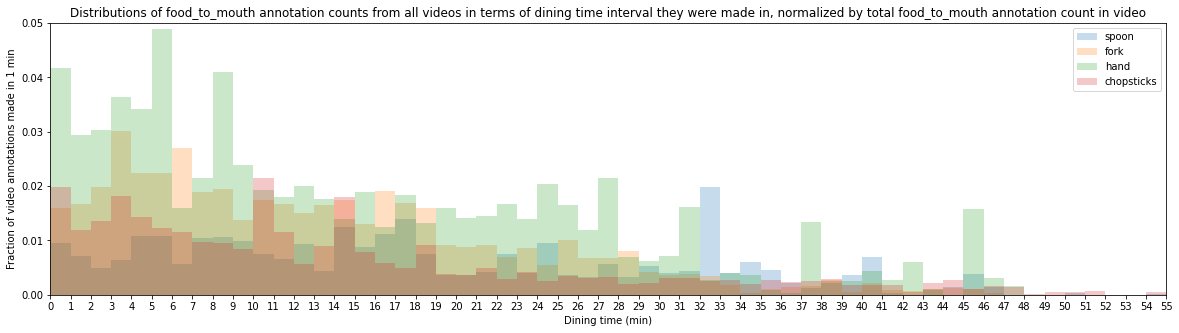

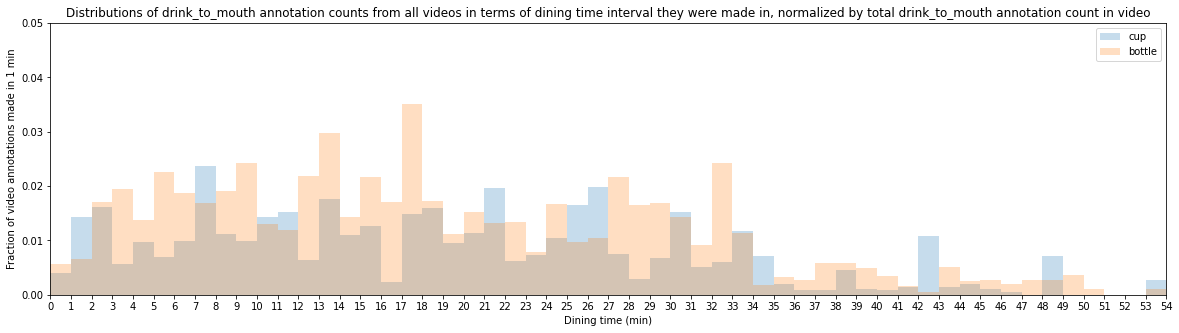

In [40]:
normalize = True
bin_width = 1 # in minutes
print(f"Bin width: {bin_width} minutes")
for tier_name in tier_names:
    x_ticks = []
    plt.figure(figsize=(20,5))
    for annotation_value in annotation_values[tier_name]:
        # Skip 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and tier_name == 'food_to_mouth'):
            print("Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations")
            continue
        all_video_bin_counts = []
        for video_id in video_ids:
            bins_range = np.arange(0, max(start_times_by_value[video_id][tier_name][annotation_value], default=0) + bin_width, bin_width)
            bin_counts, _ = np.histogram(start_times_by_value[video_id][tier_name][annotation_value], bins=bins_range)
            if normalize:
                # Normalize by the total annotation count in that video
                all_video_bin_counts.append(bin_counts / len(start_times_by_value[video_id][tier_name][annotation_value]))
            else:
                all_video_bin_counts.append(bin_counts)

        aggregated_bin_counts = list(zip_longest(*all_video_bin_counts, fillvalue=0))
        x_positions = (bin_width / 2) + np.arange(0, len(aggregated_bin_counts) * bin_width, step=bin_width)
        if 1 + len(aggregated_bin_counts) > len(x_ticks):
            x_ticks = np.arange(0, (1 + len(aggregated_bin_counts)) * bin_width, step=bin_width)
        plt.bar(x_positions, np.mean(aggregated_bin_counts, axis=1), width=bin_width, alpha=0.25, label=annotation_value)
    plt.xticks(x_ticks, x_ticks)
    plt.xlabel('Dining time (min)')
    plt.xlim(0, x_ticks[-1])
    if normalize:
        plt.ylabel(f'Fraction of video annotations made in {bin_width} min')
        plt.title(f'Distributions of {tier_name} annotation counts from all videos in terms of dining time interval they were made in, normalized by total {tier_name} annotation count in video')
    else:
        plt.ylabel(f'# annotations made in {bin_width} min')
        plt.title(f'Distributions of {tier_name} annotation counts from all videos in terms of dining time interval they were made in')
    plt.ylim(0, 0.05)
    plt.legend()
    plt.show()


Bin width: 1 minutes
Error bars correspond to 1 std
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


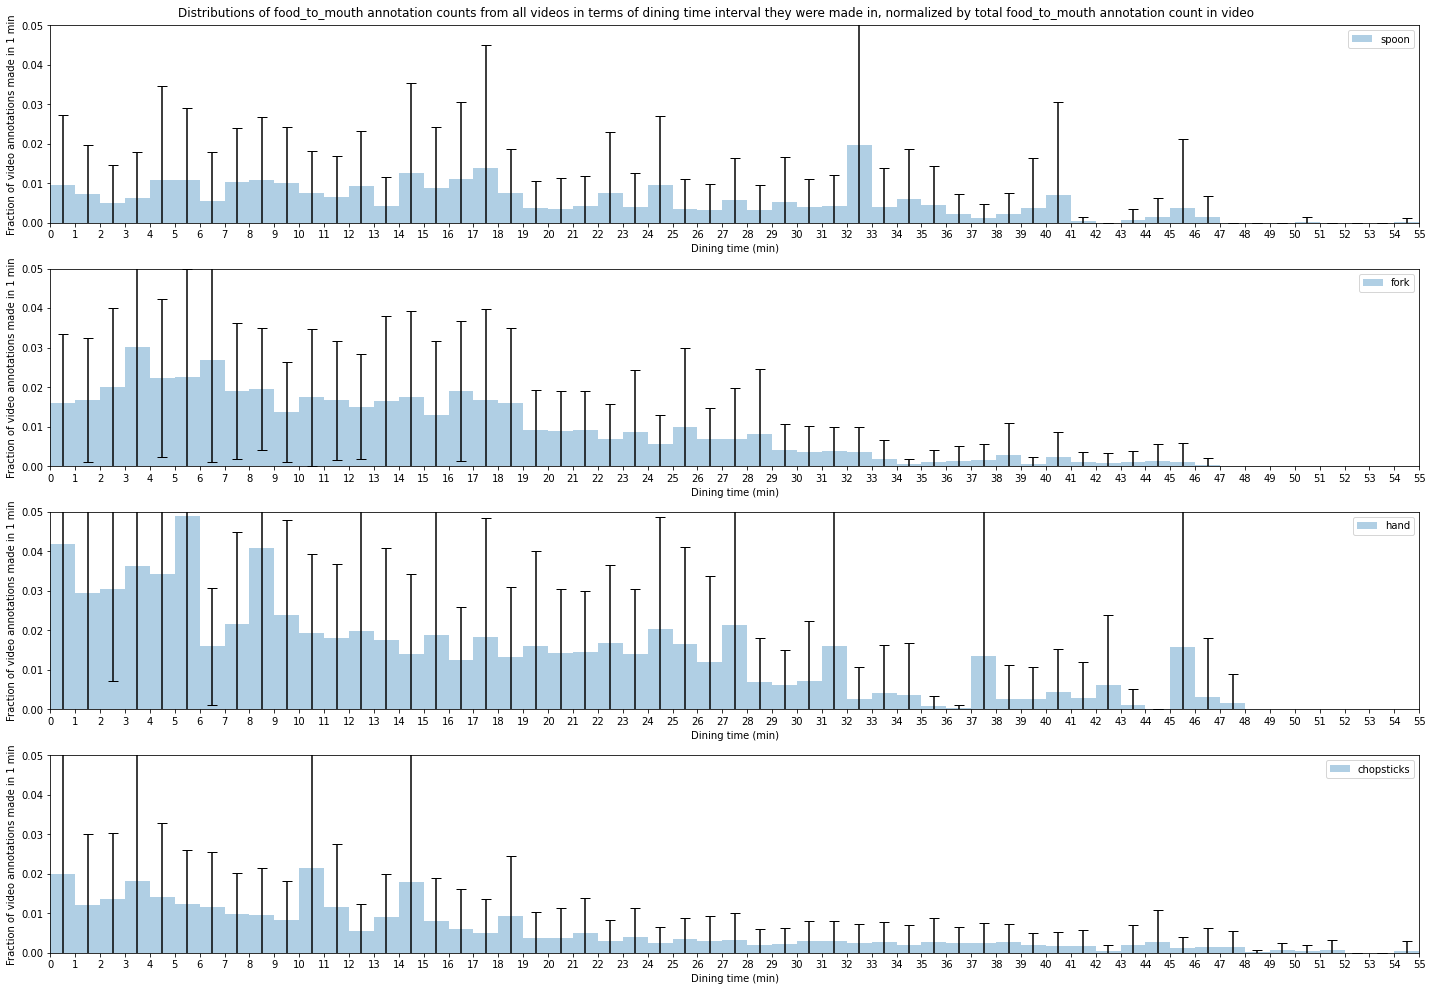

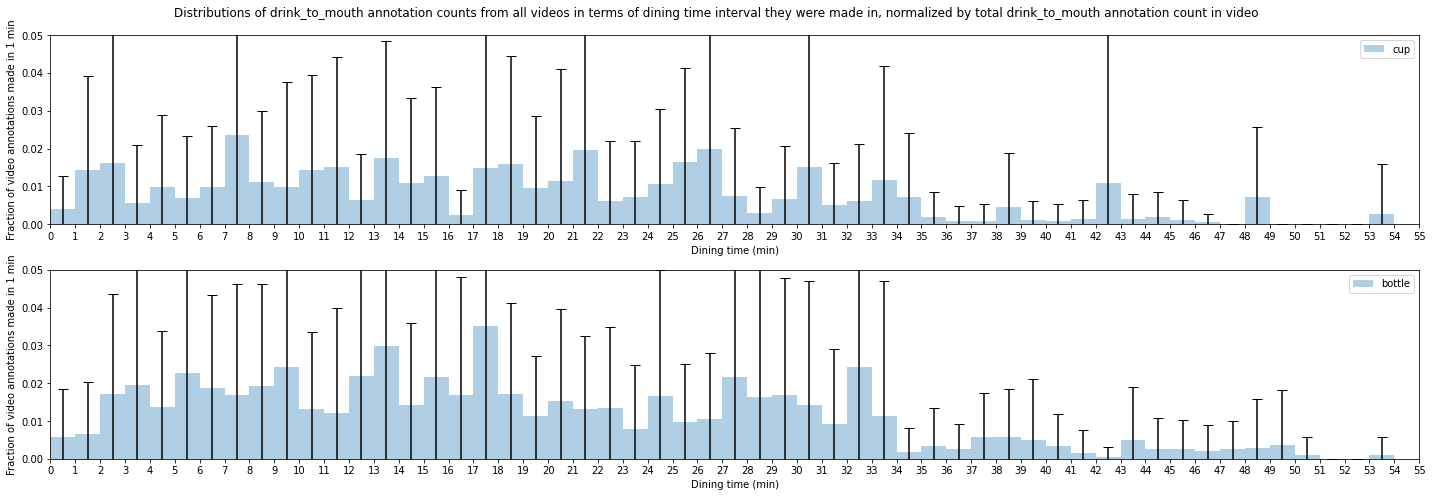

In [47]:
normalize = True
bin_width = 1 # in minutes
print(f"Bin width: {bin_width} minutes")
print('Error bars correspond to 1 std')
for tier_name, num_subplots in zip(tier_names, [4, 2]):
    plt.figure(figsize=(20, num_subplots * 3.5))
    i = 0
    for annotation_value in annotation_values[tier_name]:
        # Skip 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and tier_name == 'food_to_mouth'):
            print("Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations")
            continue
        all_video_bin_counts = []
        for video_id in video_ids:
            bins_range = np.arange(0, max(start_times_by_value[video_id][tier_name][annotation_value], default=0) + bin_width, bin_width)
            bin_counts, _ = np.histogram(start_times_by_value[video_id][tier_name][annotation_value], bins=bins_range)
            if normalize:
                # Normalize by the total annotation count in that video
                all_video_bin_counts.append(bin_counts / len(start_times_by_value[video_id][tier_name][annotation_value]))
            else:
                all_video_bin_counts.append(bin_counts)

        aggregated_bin_counts = list(zip_longest(*all_video_bin_counts, fillvalue=0))
        x_positions = (bin_width / 2) + np.arange(0, len(aggregated_bin_counts) * bin_width, step=bin_width)
        if 1 + len(aggregated_bin_counts) > len(x_ticks):
            x_ticks = np.arange(0, (1 + len(aggregated_bin_counts)) * bin_width, step=bin_width)
        plt.subplot(num_subplots, 1, i + 1)
        i += 1
        plt.bar(x_positions, np.mean(aggregated_bin_counts, axis=1), yerr=np.std(aggregated_bin_counts, axis=1) / 2, capsize=5, width=bin_width, alpha=0.35, label=annotation_value)
        plt.xticks(x_ticks, x_ticks)
        plt.xlabel('Dining time (min)')
        plt.xlim(0, x_ticks[-1])
        if normalize:
            plt.ylabel(f'Fraction of video annotations made in {bin_width} min')
        else:
            plt.ylabel(f'# annotations made in {bin_width} min')
        plt.ylim(0, 0.05)
        plt.legend()
    if normalize:
        plt.suptitle(f'Distributions of {tier_name} annotation counts from all videos in terms of dining time interval they were made in, normalized by total {tier_name} annotation count in video')
    else:
        plt.suptitle(f'Distributions of {tier_name} annotation counts from all videos in terms of dining time interval they were made in')
    plt.tight_layout()
    plt.show()


## 5.2 Annotation duration

### 5.2.1 By annotation type

In [147]:
tier_names = [
    'mouth_open',

    # 'food_entered',
    # 'food_lifted',
    'food_to_mouth',

    # 'drink_entered',
    # 'drink_lifted',
    'drink_to_mouth',

    # 'napkin_entered',
    # 'napkin_lifted',
    'napkin_to_mouth',

    # 'disruption'
]

durations = defaultdict(list)
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)
    for tier_name in tier_names:
        durations[tier_name].extend( [ (start_time/60000., (end_time - start_time)/1000.) for start_time, end_time, _ in eaf_obj1.get_annotation_data_for_tier(tier_name)] )


Bin width: 1 min


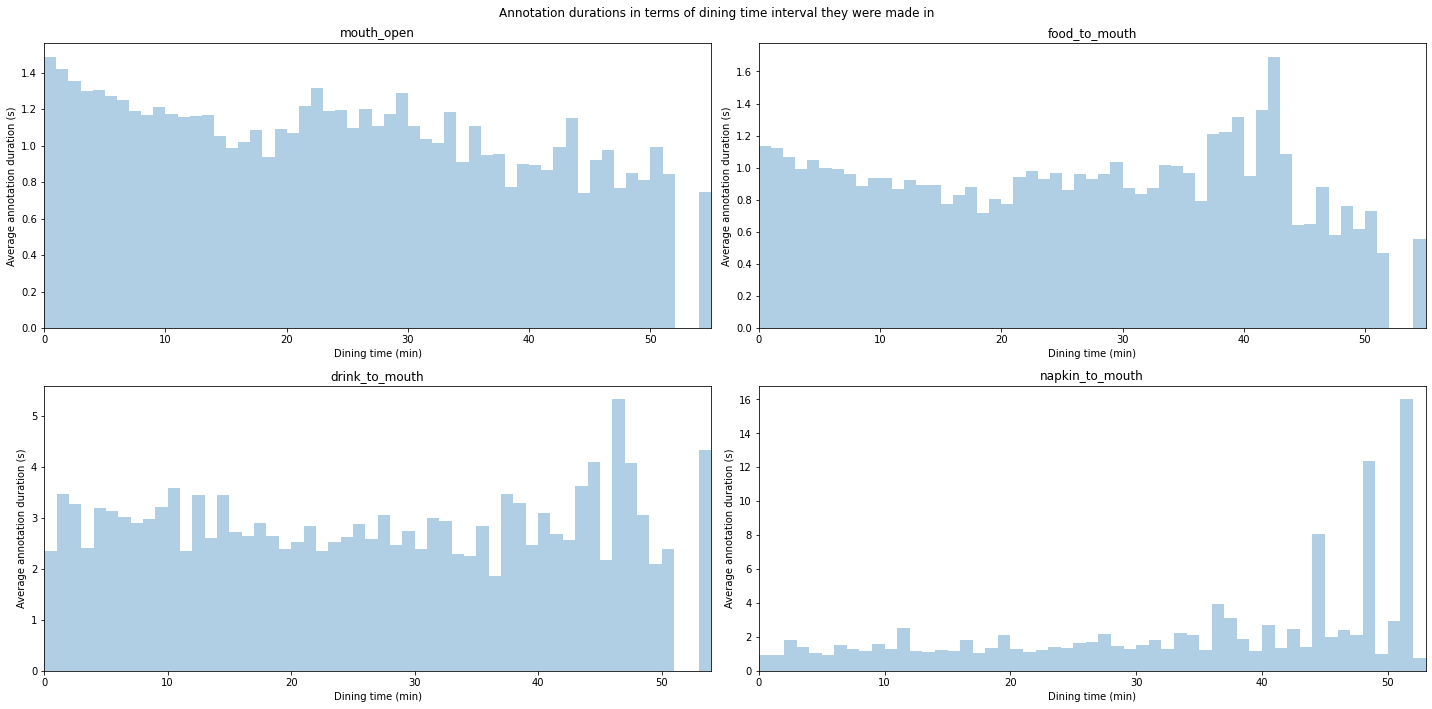

In [152]:
bin_width = 1 # in minutes
print(f"Bin width: {bin_width} min")
plt.figure(figsize=(20,10))
for i, tier_name in enumerate(tier_names):
    start_times_list, durations_list = list(zip(*durations[tier_name]))
    bins_range = np.arange(0, max(start_times_list) + bin_width, bin_width)
    y = list(map(np.nan_to_num, binned_statistic(start_times_list, durations_list, bins=bins_range, statistic='mean')[0]))
    plt.subplot(2, 2, i + 1)
    plt.bar(bins_range[:-1], y, width=bin_width, alpha=0.35, align='edge')
    plt.xlim(0, bins_range[-1])
    plt.xlabel('Dining time (min)')
    plt.ylabel(f'Average annotation duration (s)')
    plt.title(tier_name)
plt.suptitle('Annotation durations in terms of dining time interval they were made in')
plt.tight_layout()
plt.show()


Bin width: 1 min


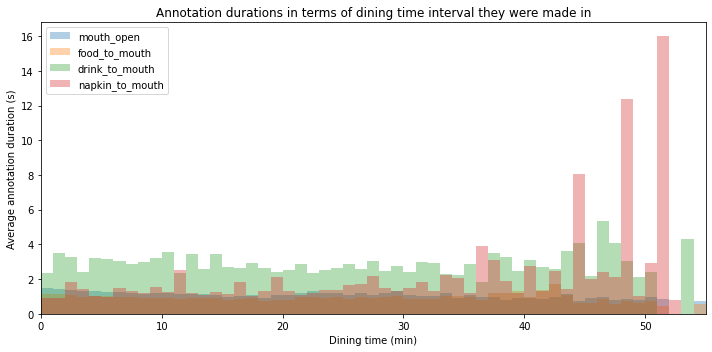

In [150]:
bin_width = 1 # in minutes
print(f"Bin width: {bin_width} min")
plt.figure(figsize=(10,5))
xmax = 0
for tier_name in tier_names:
    start_times_list, durations_list = list(zip(*durations[tier_name]))
    bins_range = np.arange(0, max(start_times_list) + bin_width, bin_width)
    xmax = max(xmax, bins_range[-1])
    y = list(map(np.nan_to_num, binned_statistic(start_times_list, durations_list, bins=bins_range, statistic='mean')[0]))
    plt.bar(bins_range[:-1], y, width=bin_width, alpha=0.35, align='edge', label=tier_name)
plt.xlim(0, xmax)
plt.xlabel('Dining time (min)')
plt.ylabel(f'Average annotation duration (s)')
plt.title('Annotation durations in terms of dining time interval they were made in')
plt.legend()
plt.tight_layout()
plt.show()


### 5.2.2 By annotation value

In [153]:
tier_names = [
    'mouth_open',

    # 'food_entered',
    # 'food_lifted',
    'food_to_mouth',

    # 'drink_entered',
    # 'drink_lifted',
    'drink_to_mouth',

    # 'napkin_entered',
    # 'napkin_lifted',
    # 'napkin_to_mouth',

    # 'disruption'
]

durations_by_value = {}
for tier_name in tier_names:
    durations_by_value[tier_name] = defaultdict(list)
    
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)

    for ((mo_start_time, mo_end_time, _), 
         (ftm_start_time, ftm_end_time, annotation_value)) in zip(sorted(eaf_obj1.get_annotation_data_for_tier('mouth_open'), key=lambda x: x[0]),
                                                                  sorted(eaf_obj1.get_annotation_data_for_tier('food_to_mouth'), key=lambda x: x[0])):
        durations_by_value['mouth_open'][annotation_value].append( (mo_start_time/60000., (mo_end_time - mo_start_time)/1000.) )
        durations_by_value['food_to_mouth'][annotation_value].append( (ftm_start_time/60000., (ftm_end_time - ftm_start_time)/1000.) )

    for start_time, end_time, annotation_value in eaf_obj1.get_annotation_data_for_tier('drink_to_mouth'):
        durations_by_value['drink_to_mouth'][annotation_value].append( (start_time/60000., (end_time - start_time)/1000.) )


Bin width: 1 min
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


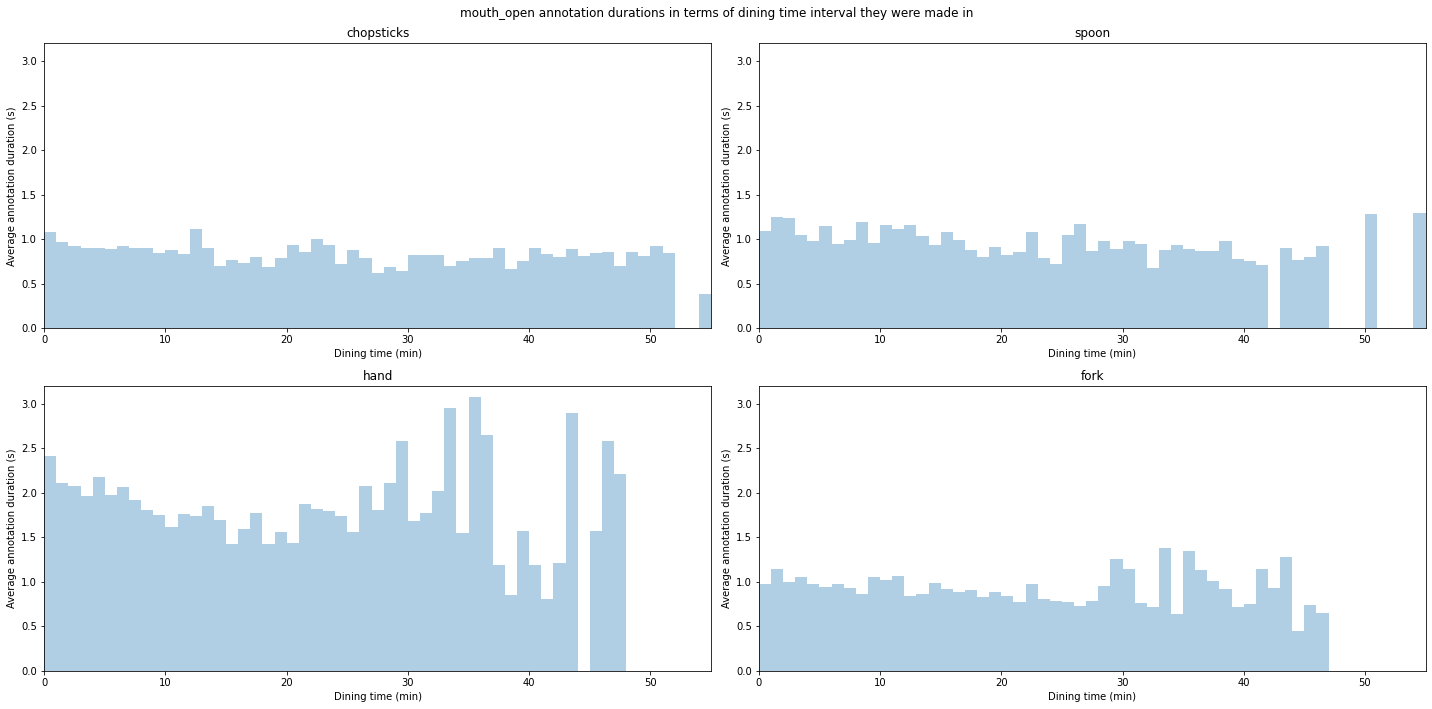

Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


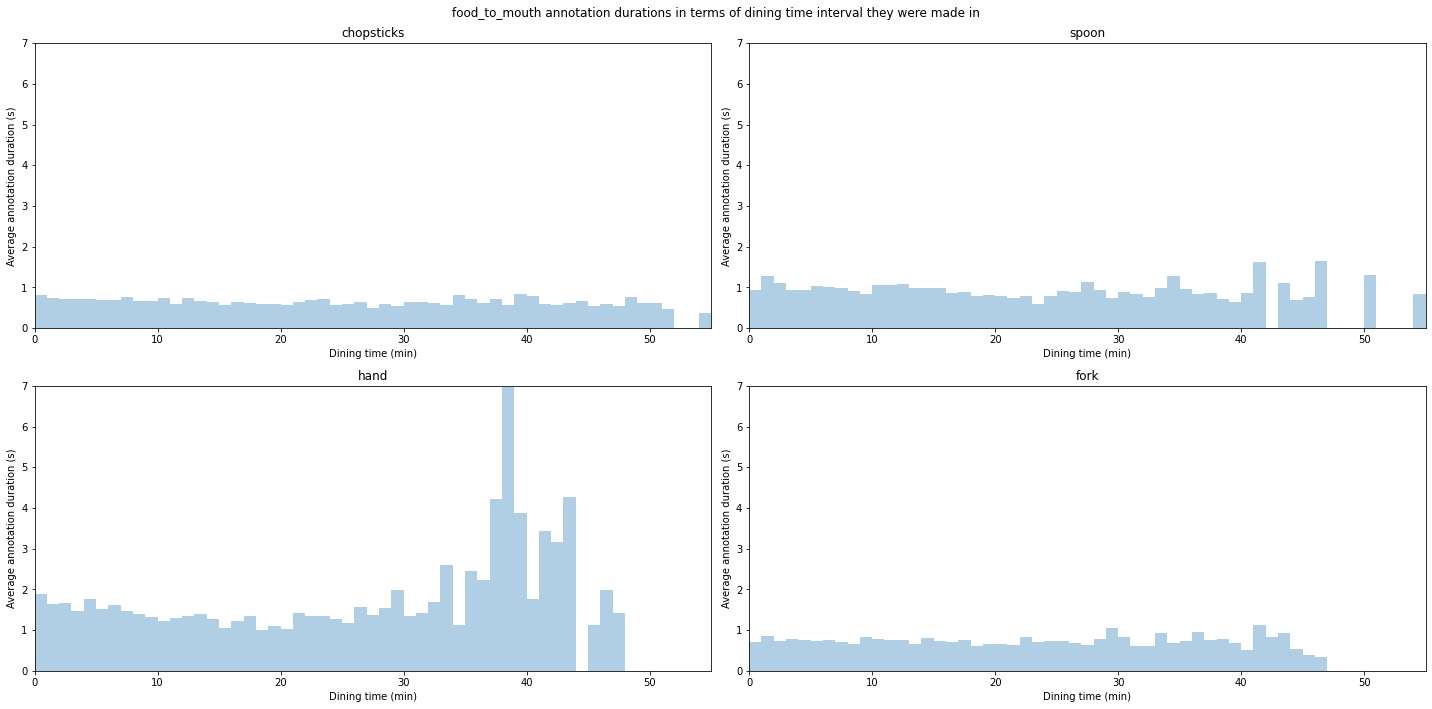

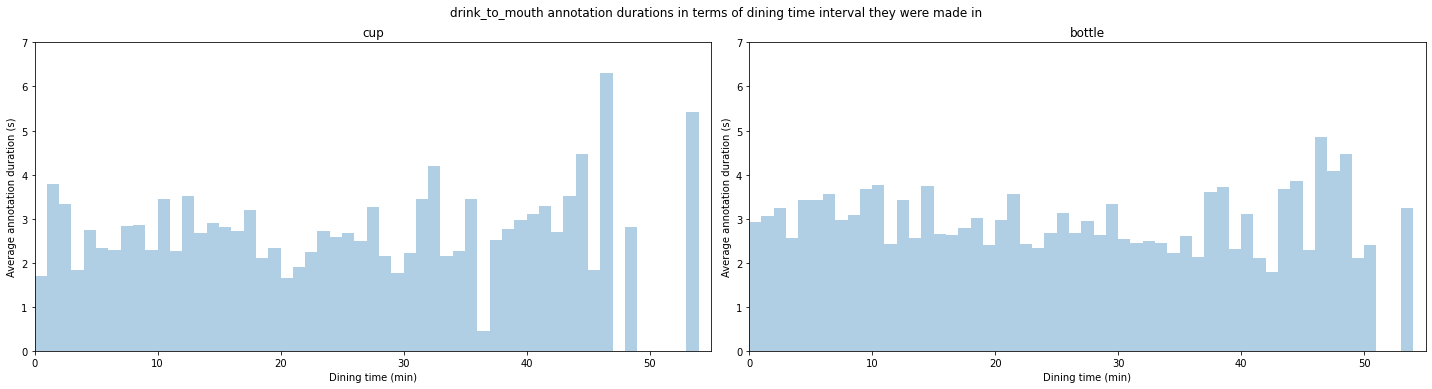

In [154]:
bin_width = 1 # in minutes
print(f"Bin width: {bin_width} min")
for tier_name, ymax in zip(tier_names, [3.2, 7, 7]):
    plt.figure(figsize=(20,10))
    i = 1
    for annotation_value in durations_by_value[tier_name].keys():
        # Skip 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and (tier_name == 'mouth_open' or tier_name == 'food_to_mouth')):
            print("Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations")
            continue
        start_times_list, durations_list = list(zip(*durations_by_value[tier_name][annotation_value]))
        bins_range = np.arange(0, max(start_times_list) + bin_width, bin_width)
        y = list(map(np.nan_to_num, binned_statistic(start_times_list, durations_list, bins=bins_range, statistic='mean')[0]))
        plt.subplot(2, 2, i)
        i += 1
        plt.bar(bins_range[:-1], y, width=bin_width, alpha=0.35, align='edge')
        plt.xlabel('Dining time (min)')
        plt.ylabel(f'Average annotation duration (s)')
        plt.xlim(0, 55)
        plt.ylim(0, ymax)
        plt.title(annotation_value)
    plt.suptitle(f'{tier_name} annotation durations in terms of dining time interval they were made in')
    plt.tight_layout()
    plt.show()


Bin width: 1 min
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


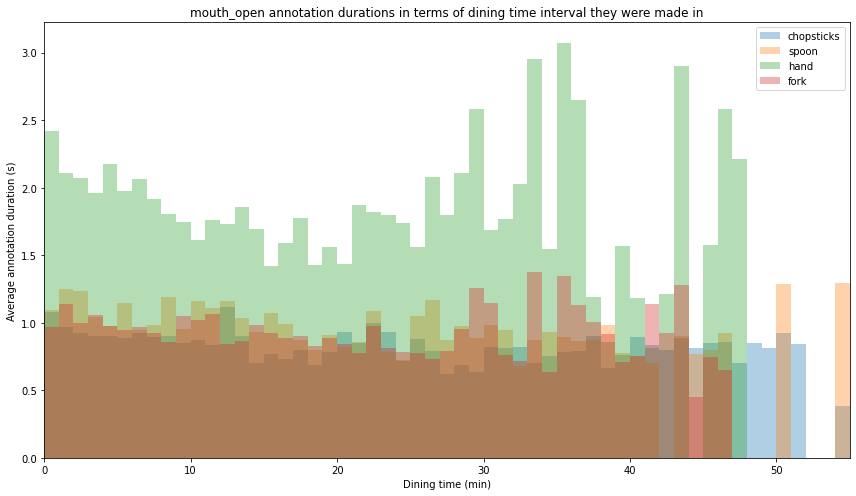

Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


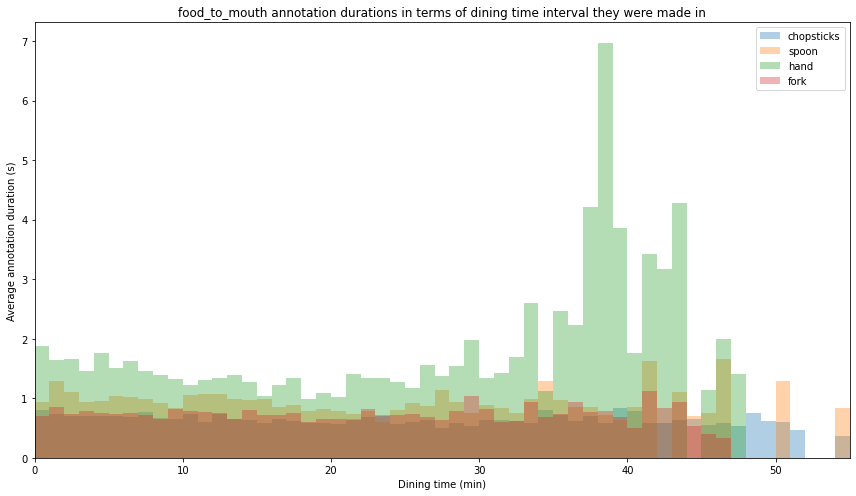

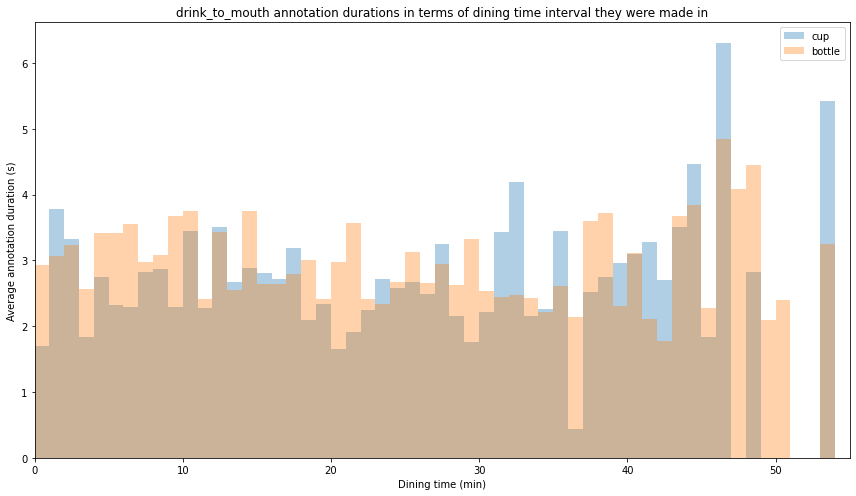

In [155]:
bin_width = 1 # in minutes
print(f"Bin width: {bin_width} min")
for tier_name in tier_names:
    plt.figure(figsize=(12,7))
    for annotation_value in durations_by_value[tier_name].keys():
        # Skip 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and (tier_name == 'mouth_open' or tier_name == 'food_to_mouth')):
            print("Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations")
            continue
        start_times_list, durations_list = list(zip(*durations_by_value[tier_name][annotation_value]))
        bins_range = np.arange(0, max(start_times_list) + bin_width, bin_width)
        y = list(map(np.nan_to_num, binned_statistic(start_times_list, durations_list, bins=bins_range, statistic='mean')[0]))
        plt.bar(bins_range[:-1], y, width=bin_width, alpha=0.35, align='edge', label=annotation_value)
        plt.xlabel('Dining time (min)')
        plt.ylabel(f'Average annotation duration (s)')
    plt.xlim(0, 55)
    plt.title(f'{tier_name} annotation durations in terms of dining time interval they were made in')
    plt.legend()
    plt.tight_layout()
    plt.show()


## 5.3 Time between annotations

### 5.3.1 Of the same annotation type

#### 5.3.1.1 By annotation type

In [156]:
tier_names = [
    'mouth_open',

    'food_entered',
    'food_lifted',
    'food_to_mouth',

    'drink_entered',
    'drink_lifted',
    'drink_to_mouth',

    'napkin_entered',
    'napkin_lifted',
    'napkin_to_mouth',

    # 'disruption'
]

spacings = defaultdict(list)
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)
    for tier_name in tier_names:
        annotations = sorted(eaf_obj1.get_annotation_data_for_tier(tier_name), key=lambda x: x[0])
        for i in range(len(annotations) - 1):
            spacings[tier_name].append( (annotations[i][0]/60000., (annotations[i + 1][0] - annotations[i][0])/1000.) )


In [157]:
def plot_4_hist_over_time(data, tier_names, ymax=None):
    bin_width = 1 # in minutes
    print(f"Bin width: {bin_width} min")
    plt.figure(figsize=(20,10))
    for i, tier_name in enumerate(tier_names):
        start_times_list, spacings_list = list(zip(*data[tier_name]))
        bins_range = np.arange(0, max(start_times_list) + bin_width, bin_width)
        y = list(map(np.nan_to_num, binned_statistic(start_times_list, spacings_list, bins=bins_range, statistic='mean')[0]))
        plt.subplot(2, 2, i + 1)
        plt.bar(bins_range[:-1], y, width=bin_width, alpha=0.35, align='edge')
        plt.xlim(0, 55)
        if ymax:
            plt.ylim(0, ymax)
        plt.xlabel('Dining time (min)')
        plt.ylabel(f'Average time between annotations (s)')
        plt.title(tier_name)
    plt.suptitle('Time between annotations of the same type in terms of dining time interval they were made in')
    plt.tight_layout()
    plt.show()


def plot_4_in_1_hist_over_time(data, tier_names):
    bin_width = 1 # in minutes
    print(f"Bin width: {bin_width} min")
    plt.figure(figsize=(12,7))
    for tier_name in tier_names:
        start_times_list, spacings_list = list(zip(*data[tier_name]))
        bins_range = np.arange(0, max(start_times_list) + bin_width, bin_width)
        y = list(map(np.nan_to_num, binned_statistic(start_times_list, spacings_list, bins=bins_range, statistic='mean')[0]))
        plt.bar(bins_range[:-1], y, width=bin_width, alpha=0.35, align='edge', label=tier_name)
    plt.xlim(0, 55)
    plt.xlabel('Dining time (min)')
    plt.ylabel(f'Average time between annotations (s)')
    plt.title('Time between annotations of the same type in terms of dining time interval they were made in')
    plt.legend()
    plt.tight_layout()
    plt.show()

Bin width: 1 min


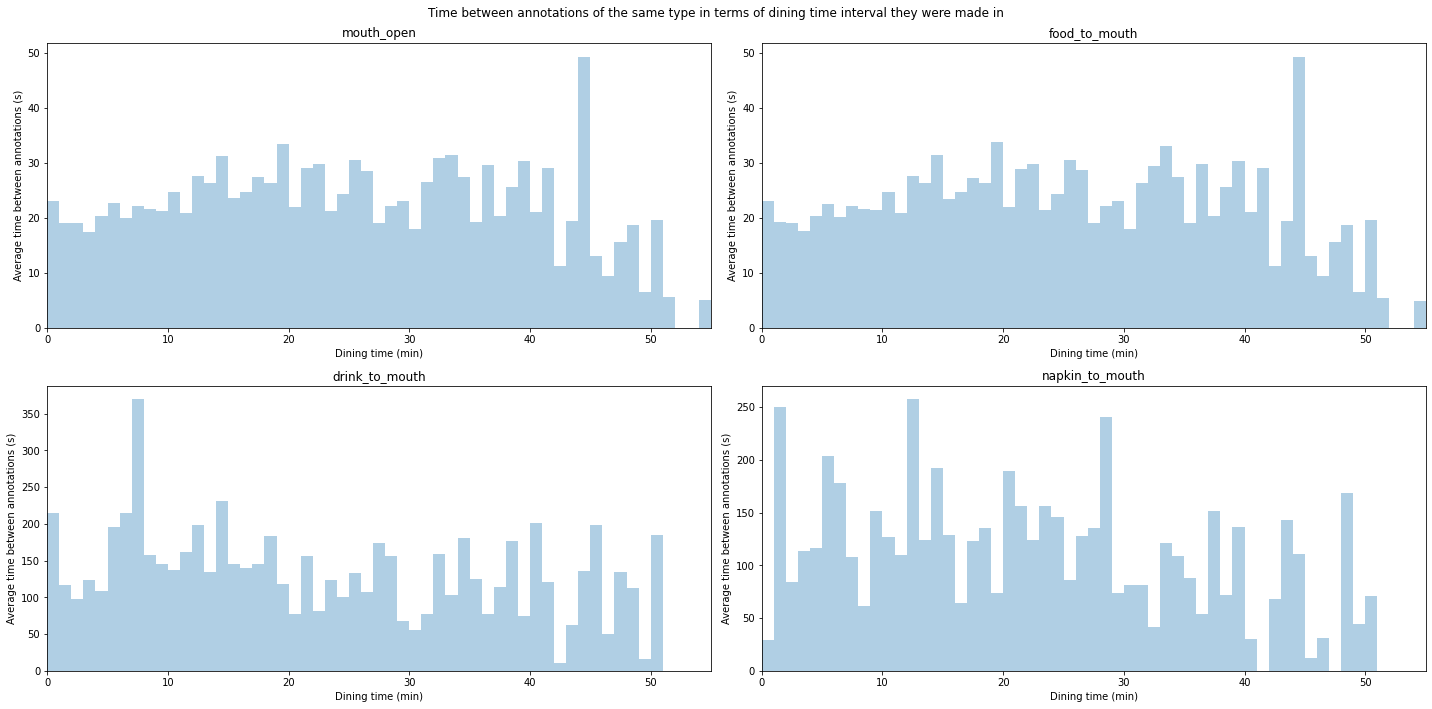

Bin width: 1 min


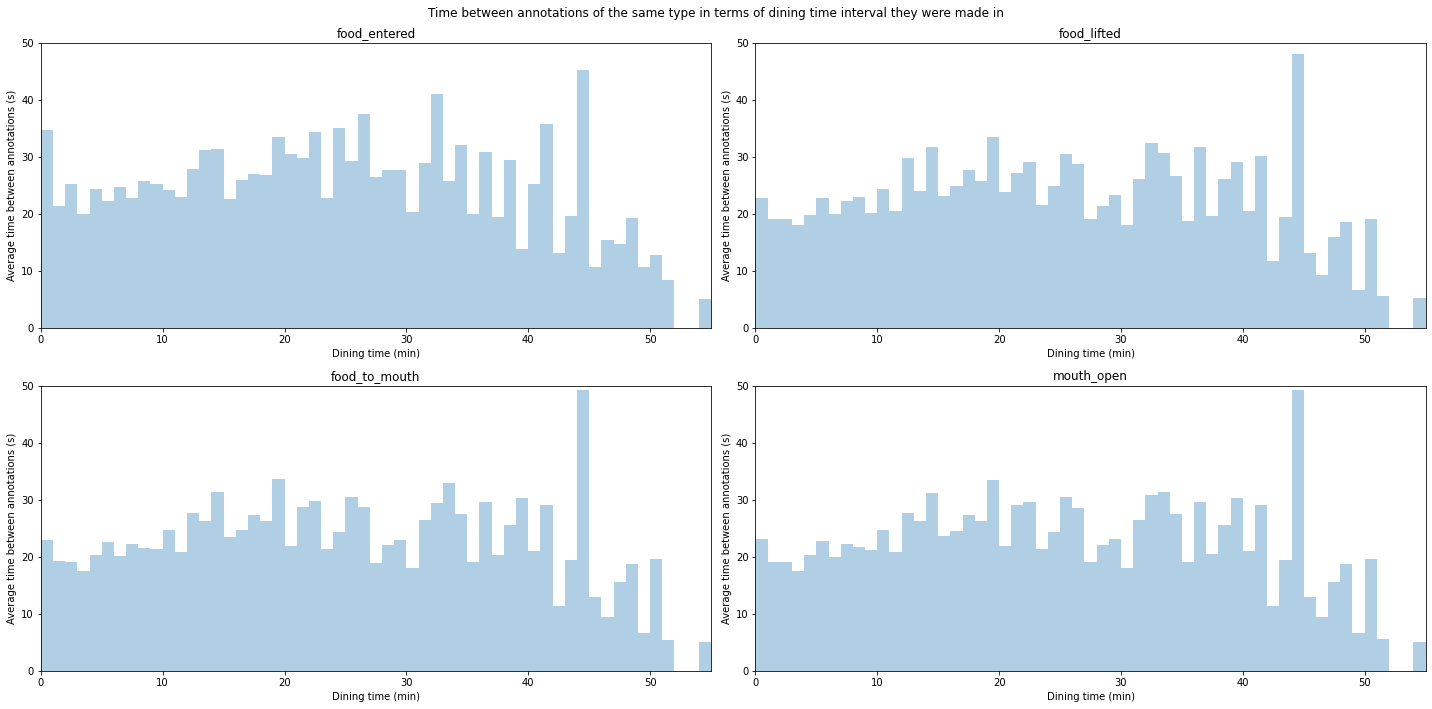

Bin width: 1 min


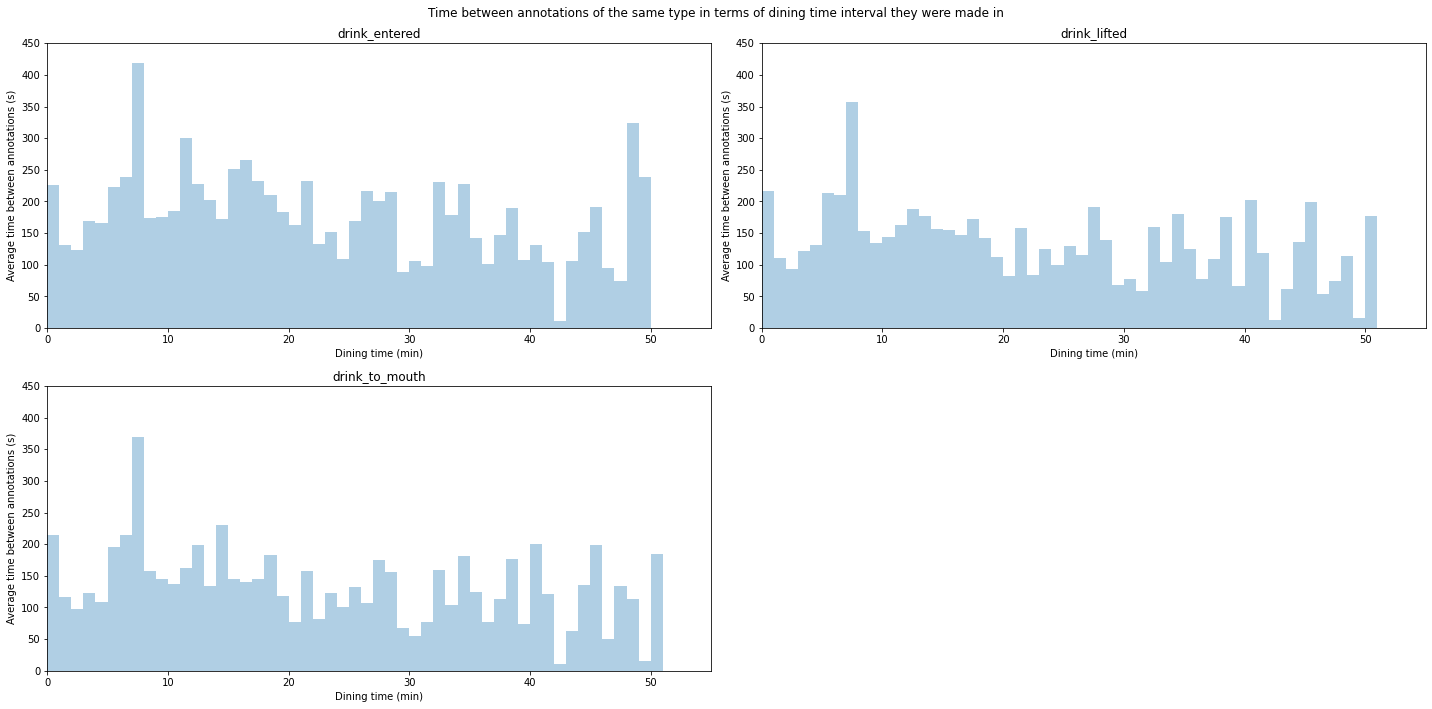

Bin width: 1 min


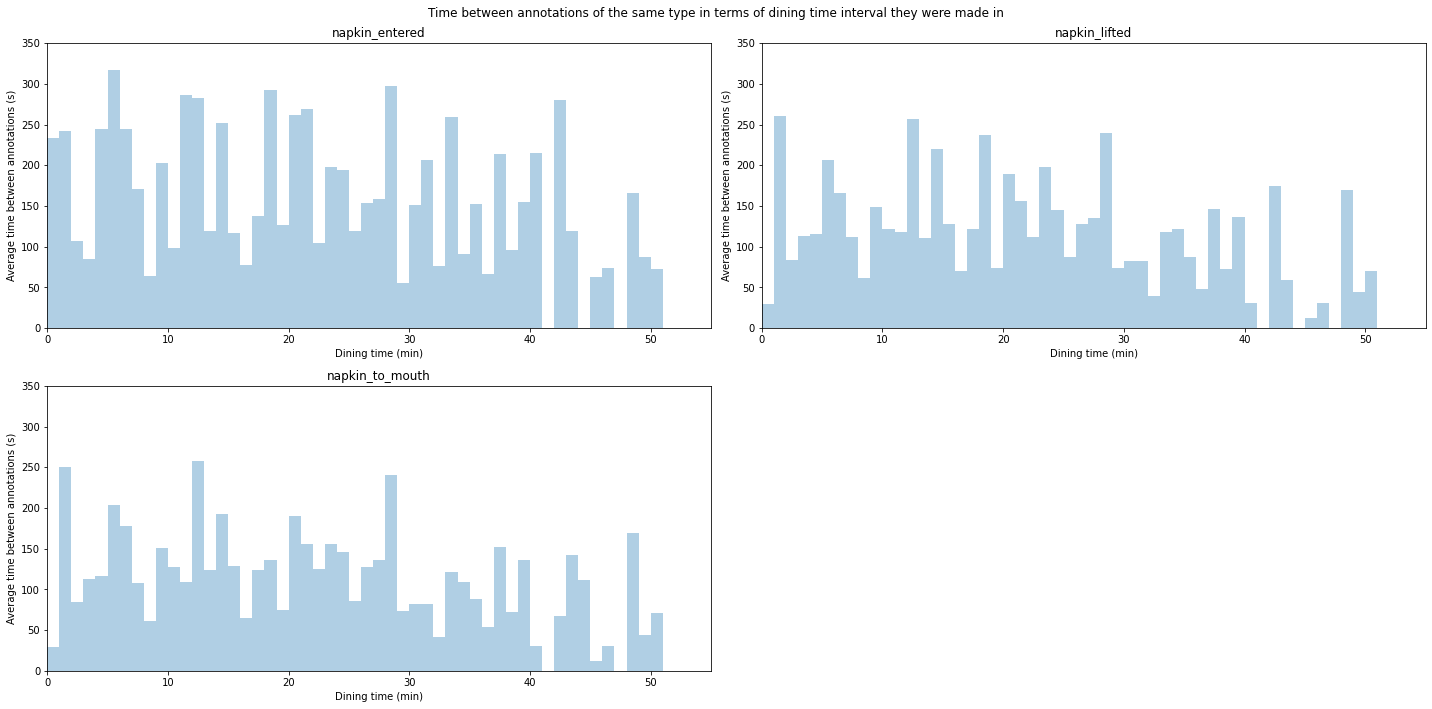

In [158]:
plot_4_hist_over_time(spacings, ['mouth_open', 'food_to_mouth', 'drink_to_mouth', 'napkin_to_mouth'])
plot_4_hist_over_time(spacings, ['food_entered', 'food_lifted', 'food_to_mouth', 'mouth_open'], ymax=50)
plot_4_hist_over_time(spacings, ['drink_entered', 'drink_lifted', 'drink_to_mouth'], ymax=450)
plot_4_hist_over_time(spacings, ['napkin_entered', 'napkin_lifted', 'napkin_to_mouth'], ymax=350)


Bin width: 1 min


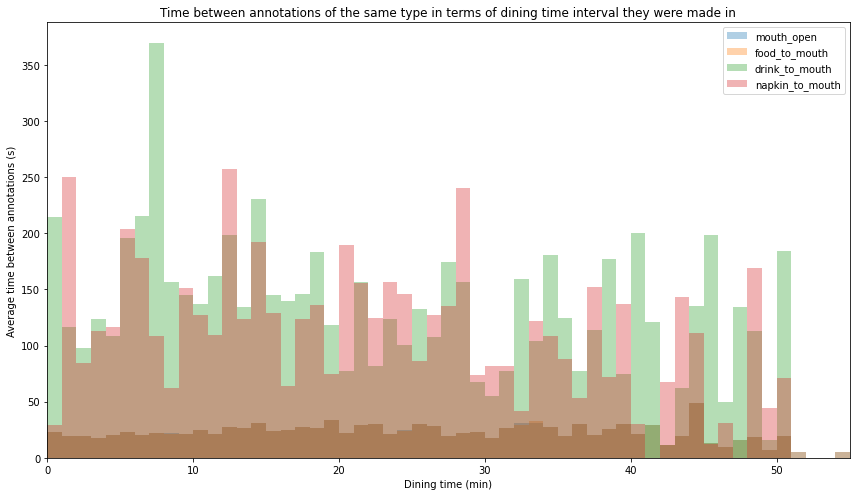

Bin width: 1 min


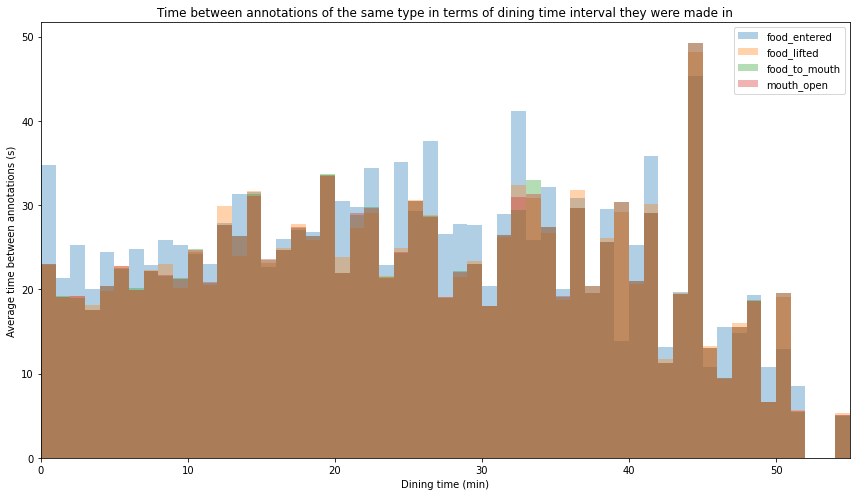

Bin width: 1 min


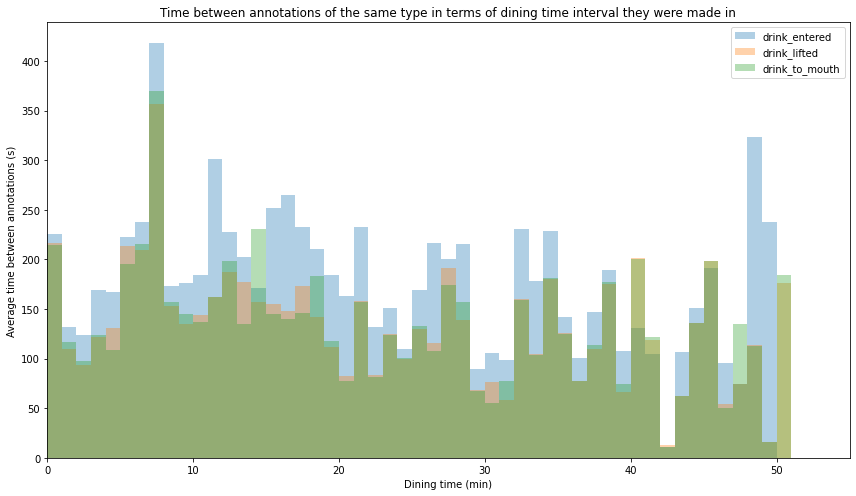

Bin width: 1 min


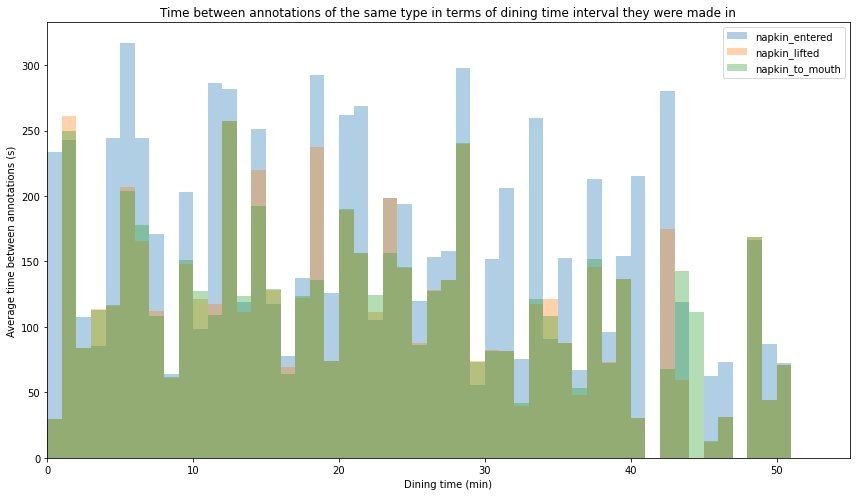

In [159]:
plot_4_in_1_hist_over_time(spacings, ['mouth_open', 'food_to_mouth', 'drink_to_mouth', 'napkin_to_mouth'])
plot_4_in_1_hist_over_time(spacings, ['food_entered', 'food_lifted', 'food_to_mouth', 'mouth_open'])
plot_4_in_1_hist_over_time(spacings, ['drink_entered', 'drink_lifted', 'drink_to_mouth'])
plot_4_in_1_hist_over_time(spacings, ['napkin_entered', 'napkin_lifted', 'napkin_to_mouth'])


#### 5.3.1.2 By annotation value

In [160]:
tier_names = [
    'mouth_open',

    # 'food_entered',
    # 'food_lifted',
    'food_to_mouth',

    # 'drink_entered',
    # 'drink_lifted',
    'drink_to_mouth',

    # 'napkin_entered',
    # 'napkin_lifted',
    # 'napkin_to_mouth',

    # 'disruption'
]

spacings_by_value = {}
for tier_name in tier_names:
    spacings_by_value[tier_name] = defaultdict(list)
    
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)

    prev_mo_start_time = -1
    prev_ftm_start_time = -1
    for ((mo_start_time, _, _), 
         (ftm_start_time, _, annotation_value)) in zip(sorted(eaf_obj1.get_annotation_data_for_tier('mouth_open'), key=lambda x: x[0]),
                                                       sorted(eaf_obj1.get_annotation_data_for_tier('food_to_mouth'), key=lambda x: x[0])):
        if prev_mo_start_time != -1:
            spacings_by_value['mouth_open'][annotation_value].append( (prev_mo_start_time/60000., (mo_start_time - prev_mo_start_time) / 1000.) )
            spacings_by_value['food_to_mouth'][annotation_value].append( (prev_ftm_start_time/60000., (ftm_start_time - prev_ftm_start_time) / 1000.) )
        prev_mo_start_time = mo_start_time
        prev_ftm_start_time = ftm_start_time

    prev_start_time = -1
    for start_time, _, annotation_value in sorted(eaf_obj1.get_annotation_data_for_tier('drink_to_mouth'), key=lambda x: x[0]):
        if prev_start_time != -1:
            spacings_by_value['drink_to_mouth'][annotation_value].append( (prev_start_time/60000., (start_time - prev_start_time) / 1000.) )
        prev_start_time = start_time


Bin width: 1 min
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


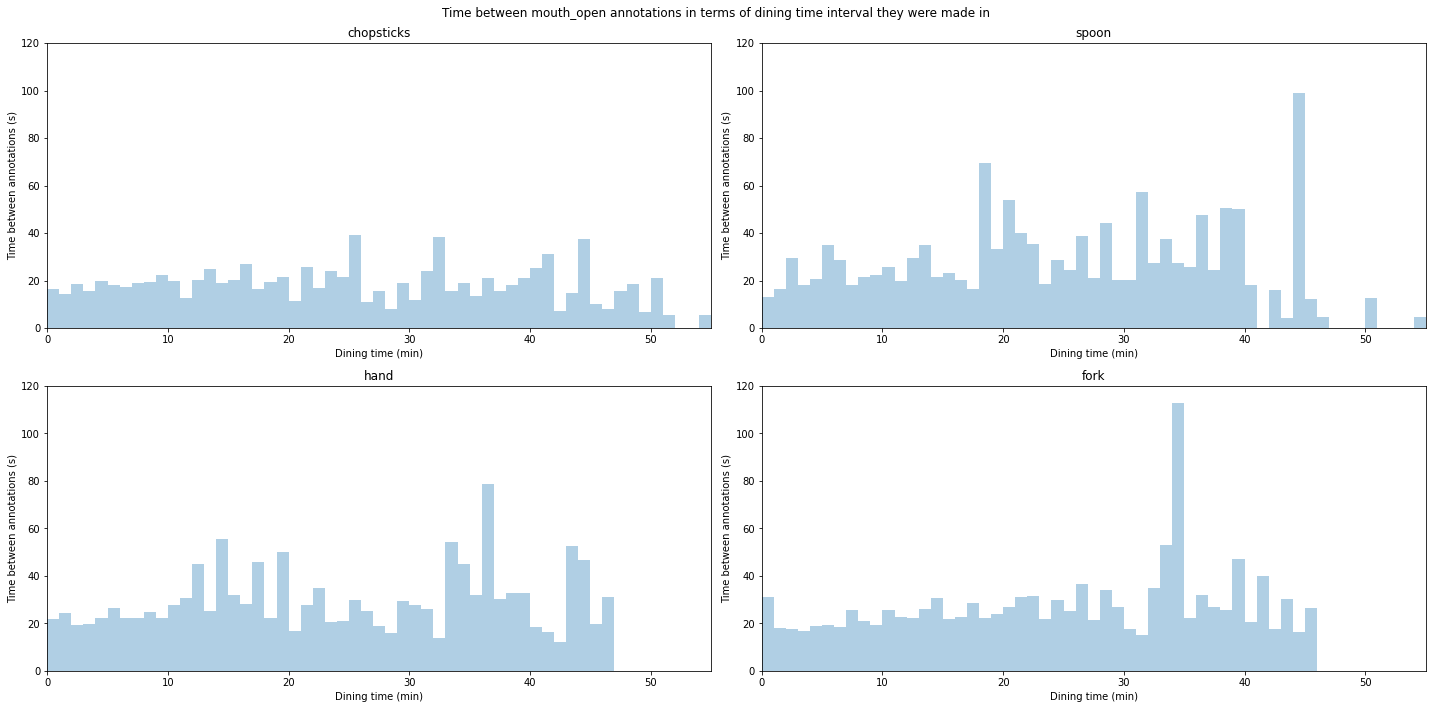

Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


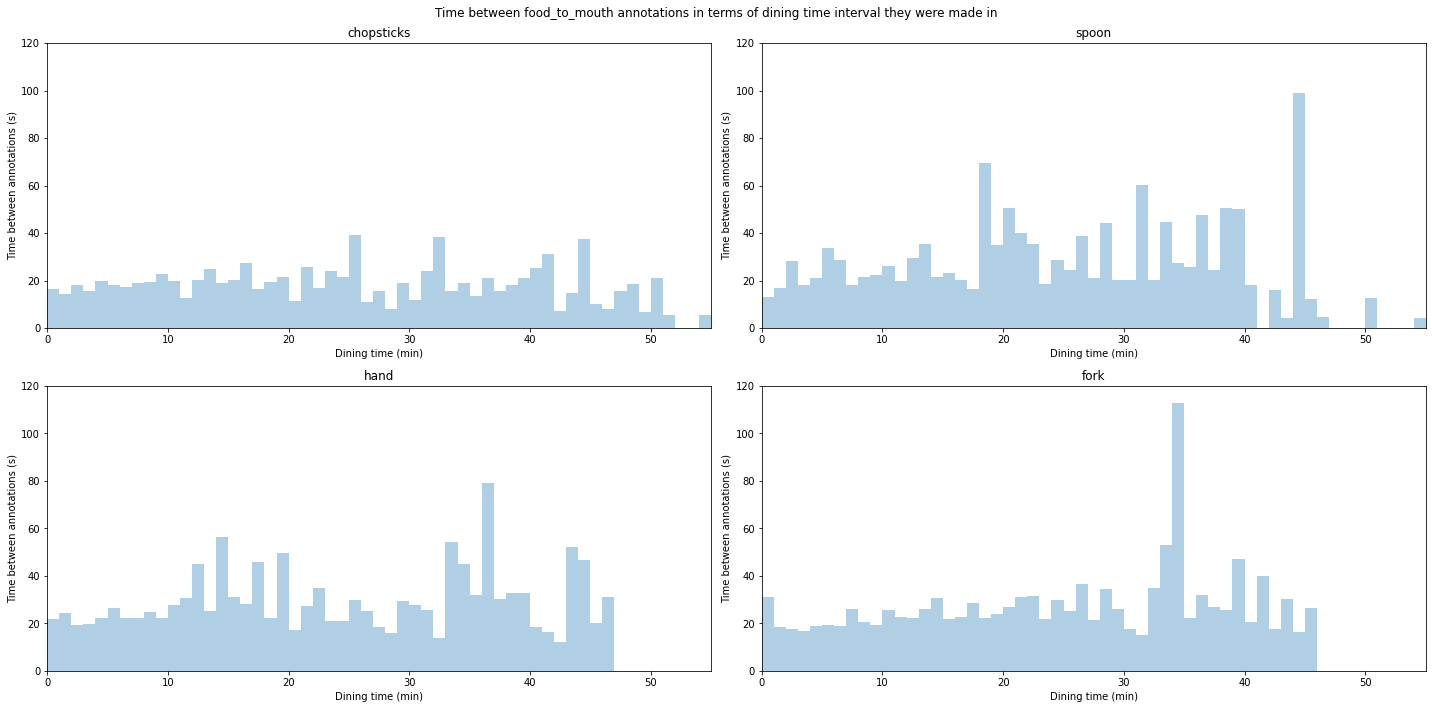

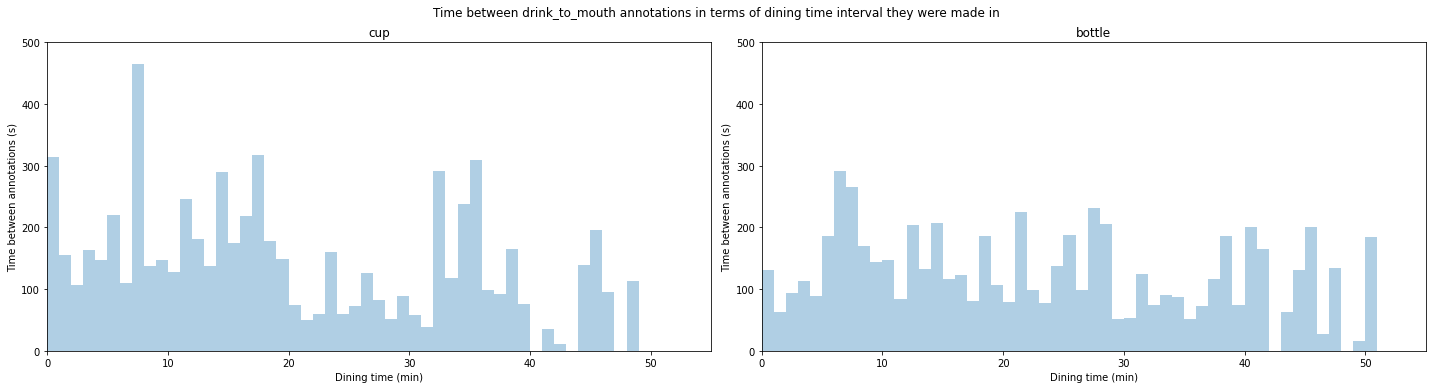

In [161]:
bin_width = 1 # in minutes
print(f"Bin width: {bin_width} min")
for tier_name, ymax in zip(tier_names, [120, 120, 500]):
    plt.figure(figsize=(20,10))
    i = 1
    for annotation_value in spacings_by_value[tier_name].keys():
        # Skip 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and (tier_name == 'mouth_open' or tier_name == 'food_to_mouth')):
            print("Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations")
            continue
        start_times_list, spacings_list = list(zip(*spacings_by_value[tier_name][annotation_value]))
        bins_range = np.arange(0, max(start_times_list) + bin_width, bin_width)
        y = list(map(np.nan_to_num, binned_statistic(start_times_list, spacings_list, bins=bins_range, statistic='mean')[0]))
        plt.subplot(2, 2, i)
        i += 1
        plt.bar(bins_range[:-1], y, width=bin_width, alpha=0.35, align='edge')
        plt.xlabel('Dining time (min)')
        plt.ylabel(f'Time between annotations (s)')
        plt.xlim(0, 55)
        plt.ylim(0, ymax)
        plt.title(annotation_value)
    plt.suptitle(f'Time between {tier_name} annotations in terms of dining time interval they were made in')
    plt.tight_layout()
    plt.show()


Bin width: 1 min
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


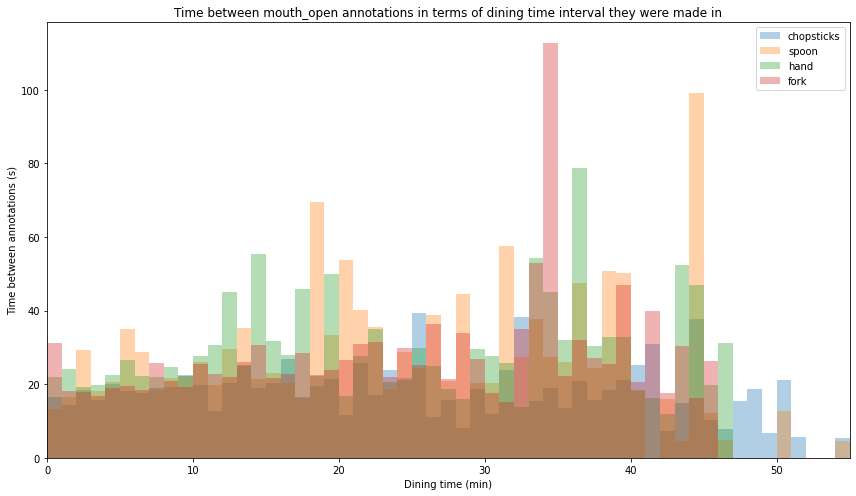

Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


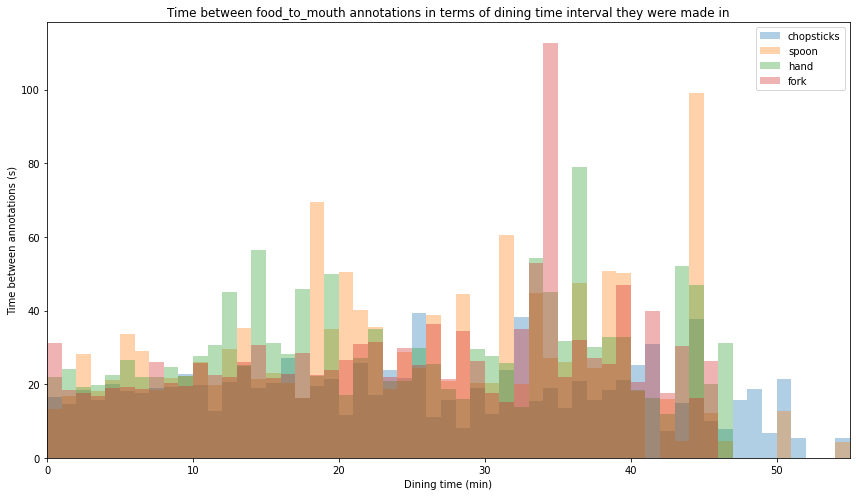

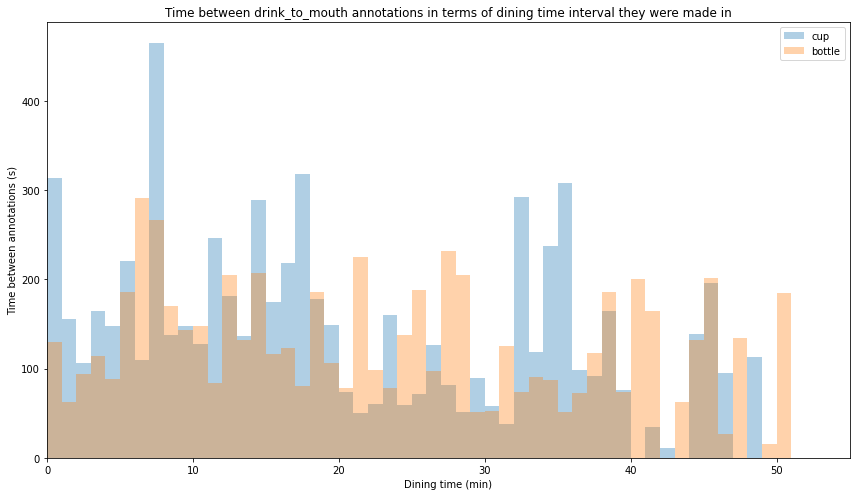

In [162]:
bin_width = 1 # in minutes
print(f"Bin width: {bin_width} min")
for tier_name in tier_names:
    plt.figure(figsize=(12,7))
    for annotation_value in spacings_by_value[tier_name].keys():
        # Skip 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and (tier_name == 'mouth_open' or tier_name == 'food_to_mouth')):
            print("Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations")
            continue
        start_times_list, spacings_list = list(zip(*spacings_by_value[tier_name][annotation_value]))
        bins_range = np.arange(0, max(start_times_list) + bin_width, bin_width)
        y = list(map(np.nan_to_num, binned_statistic(start_times_list, spacings_list, bins=bins_range, statistic='mean')[0]))
        plt.bar(bins_range[:-1], y, width=bin_width, alpha=0.35, align='edge', label=annotation_value)
        plt.xlabel('Dining time (min)')
        plt.ylabel(f'Time between annotations (s)')
    plt.xlim(0, 55)
    plt.title(f'Time between {tier_name} annotations in terms of dining time interval they were made in')
    plt.legend()
    plt.tight_layout()
    plt.show()


### 5.3.2 Of a different annotation type

#### 5.3.2.1 By annotation type

In [163]:
tier_names = [
    'mouth_open',
    'food_lifted',
    'food_to_mouth',

    'drink_lifted',
    'drink_to_mouth',

    'napkin_lifted',
    'napkin_to_mouth'
]

delays = defaultdict(list)
for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)

    annotations = {}
    for tier_name in tier_names:
        annotations[tier_name] = sorted(eaf_obj1.get_annotation_data_for_tier(tier_name), key=lambda x: x[0])

    # The food_lifted annotation must precede the food_to_mouth annotation unless the food is already lifted at the beginning of the video
    # The mouth_open annotation must precede the food_to_mouth annotation
    i1, i2 = 0, 0
    while i2 < len(annotations['food_to_mouth']):
        if not (i1 == 0 and annotations['food_lifted'][i1][0] > annotations['food_to_mouth'][i2][0]):
            delays['fl->ftm'].append( (annotations['food_lifted'][i1][0]/60000., (annotations['food_to_mouth'][i2][0] - annotations['food_lifted'][i1][0]) / 1000.) )
            i1 += 1
        delays['mo->ftm'].append( (annotations['mouth_open'][i2][0]/60000., (annotations['food_to_mouth'][i2][0] - annotations['mouth_open'][i2][0]) / 1000.) )
        i2 += 1

    # The drink_lifted annotation must precede the drink_to_mouth annotation unless the drink is already lifted at the beginning of the video
    i1, i2 = 0, 0
    while i2 < len(annotations['drink_to_mouth']):
        if not (i1 == 0 and annotations['drink_lifted'][i1][0] > annotations['drink_to_mouth'][i2][0]):
            delays['dl->dtm'].append( (annotations['drink_lifted'][i1][0]/60000., (annotations['drink_to_mouth'][i2][0] - annotations['drink_lifted'][i1][0]) / 1000.) )
            i1 += 1
        i2 += 1

    # The napkin_lifted annotation must precede the napkin_to_mouth annotation unless the napkin is already lifted at the beginning of the video.    
    i1, i2 = 0, 0
    while i2 < len(annotations['napkin_to_mouth']):
        if not (i1 == 0 and annotations['napkin_lifted'][i1][0] > annotations['napkin_to_mouth'][i2][0]):
            delays['nl->ntm'].append( (annotations['napkin_lifted'][i1][0]/60000., (annotations['napkin_to_mouth'][i2][0] - annotations['napkin_lifted'][i1][0]) / 1000.) )
            i1 += 1
        i2 += 1


Bin width: 1 min


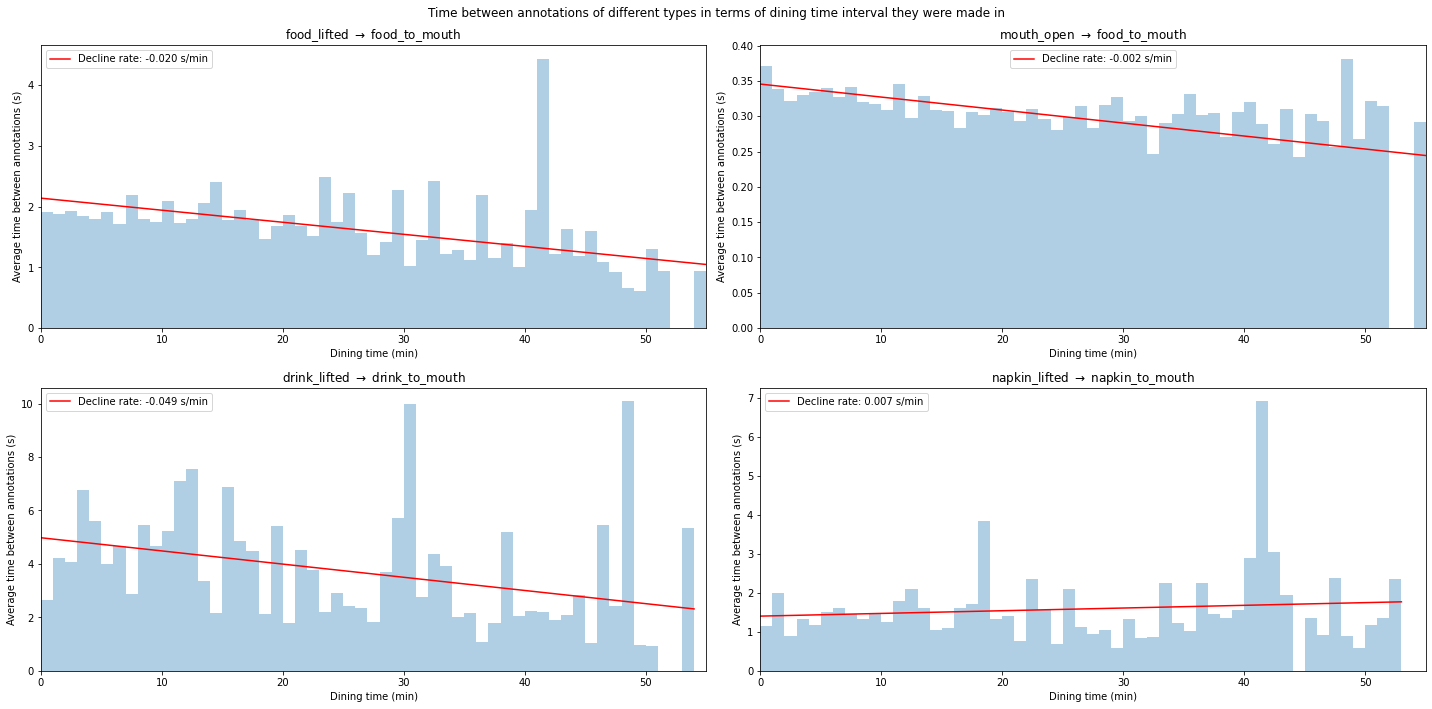

In [164]:
delay_labels = {
    'fl->ftm': fr'food_lifted $\rightarrow$ food_to_mouth',
    'mo->ftm': fr'mouth_open $\rightarrow$ food_to_mouth',
    'dl->dtm': fr'drink_lifted $\rightarrow$ drink_to_mouth',
    'nl->ntm': fr'napkin_lifted $\rightarrow$ napkin_to_mouth',
}

bin_width = 1 # in minutes
print(f"Bin width: {bin_width} min")
plt.figure(figsize=(20,10))
for i, delay_label_key in enumerate(delay_labels.keys()):
    start_times_list, spacings_list = list(zip(*delays[delay_label_key]))
    bins_range = np.arange(0, max(start_times_list) + bin_width, bin_width)
    y = list(map(np.nan_to_num, binned_statistic(start_times_list, spacings_list, bins=bins_range, statistic='mean')[0]))
    plt.subplot(2, 2, i + 1)
    plt.bar(bins_range[:-1], y, width=bin_width, alpha=0.35, align='edge')
    theta = np.polyfit(bins_range[:-1], y, 1)
    plt.plot(bins_range, theta[1] + theta[0] * bins_range, 'r', label=fr'Decline rate: {theta[0]:.3f} s/min')
    plt.xlim(0, 55)
    # if ymax:
    #     plt.ylim(0, ymax)
    plt.xlabel('Dining time (min)')
    plt.ylabel(f'Average time between annotations (s)')
    plt.title(delay_labels[delay_label_key])
    plt.legend()
plt.suptitle('Time between annotations of different types in terms of dining time interval they were made in')
plt.tight_layout()
plt.show()


#### 5.3.2.2 By annotation value

In [165]:
tier_names = [
    'mouth_open',
    'food_lifted',
    'food_to_mouth',

    'drink_lifted',
    'drink_to_mouth',

    'napkin_lifted',
    'napkin_to_mouth'
]
delay_labels = {
    'fl->ftm': fr'food_lifted $\rightarrow$ food_to_mouth',
    'mo->ftm': fr'mouth_open $\rightarrow$ food_to_mouth',
    'dl->dtm': fr'drink_lifted $\rightarrow$ drink_to_mouth',
    'nl->ntm': fr'napkin_lifted $\rightarrow$ napkin_to_mouth',
}

delays_by_value = {}
for delay_label_key in delay_labels.keys():
    delays_by_value[delay_label_key] = defaultdict(list)

for annotation_file in glob.glob(f'{annotations_folder}/*.eaf'):
    eaf_obj1 = pympi.Elan.Eaf(annotation_file)

    annotations = {}
    for tier_name in tier_names:
        annotations[tier_name] = sorted(eaf_obj1.get_annotation_data_for_tier(tier_name), key=lambda x: x[0])

    # The food_lifted annotation must precede the food_to_mouth annotation unless the food is already lifted at the beginning of the video
    # The mouth_open annotation must precede the food_to_mouth annotation
    i1, i2 = 0, 0
    while i2 < len(annotations['food_to_mouth']):
        annotation_value = annotations['food_to_mouth'][i2][2]
        if not (i1 == 0 and annotations['food_lifted'][i1][0] > annotations['food_to_mouth'][i2][0]):
            delays_by_value['fl->ftm'][annotation_value].append( (annotations['food_lifted'][i1][0]/60000., (annotations['food_to_mouth'][i2][0] - annotations['food_lifted'][i1][0]) / 1000.) )
            i1 += 1
        delays_by_value['mo->ftm'][annotation_value].append( (annotations['mouth_open'][i2][0]/60000., (annotations['food_to_mouth'][i2][0] - annotations['mouth_open'][i2][0]) / 1000.) )
        i2 += 1

    # The drink_lifted annotation must precede the drink_to_mouth annotation unless the drink is already lifted at the beginning of the video
    i1, i2 = 0, 0
    while i2 < len(annotations['drink_to_mouth']):
        annotation_value = annotations['drink_to_mouth'][i2][2]
        if not (i1 == 0 and annotations['drink_lifted'][i1][0] > annotations['drink_to_mouth'][i2][0]):
            delays_by_value['dl->dtm'][annotation_value].append( (annotations['drink_lifted'][i1][0]/60000., (annotations['drink_to_mouth'][i2][0] - annotations['drink_lifted'][i1][0]) / 1000.) )
            i1 += 1
        i2 += 1

    # The napkin_lifted annotation must precede the napkin_to_mouth annotation unless the napkin is already lifted at the beginning of the video.    
    i1, i2 = 0, 0
    while i2 < len(annotations['napkin_to_mouth']):
        annotation_value = annotations['napkin_to_mouth'][i2][2]
        if not (i1 == 0 and annotations['napkin_lifted'][i1][0] > annotations['napkin_to_mouth'][i2][0]):
            delays_by_value['nl->ntm'][annotation_value].append( (annotations['napkin_lifted'][i1][0]/60000., (annotations['napkin_to_mouth'][i2][0] - annotations['napkin_lifted'][i1][0]) / 1000.) )
            i1 += 1
        i2 += 1


Bin width: 1 min
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


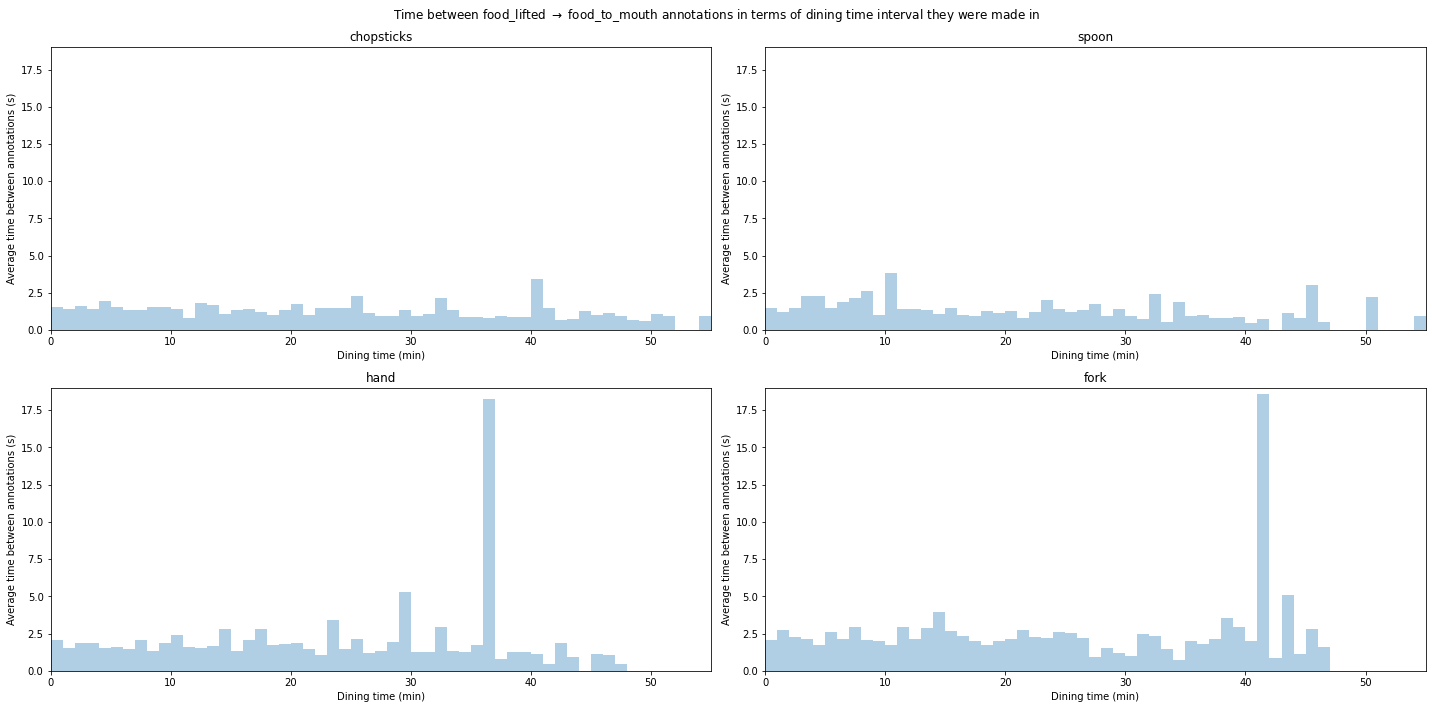

Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations


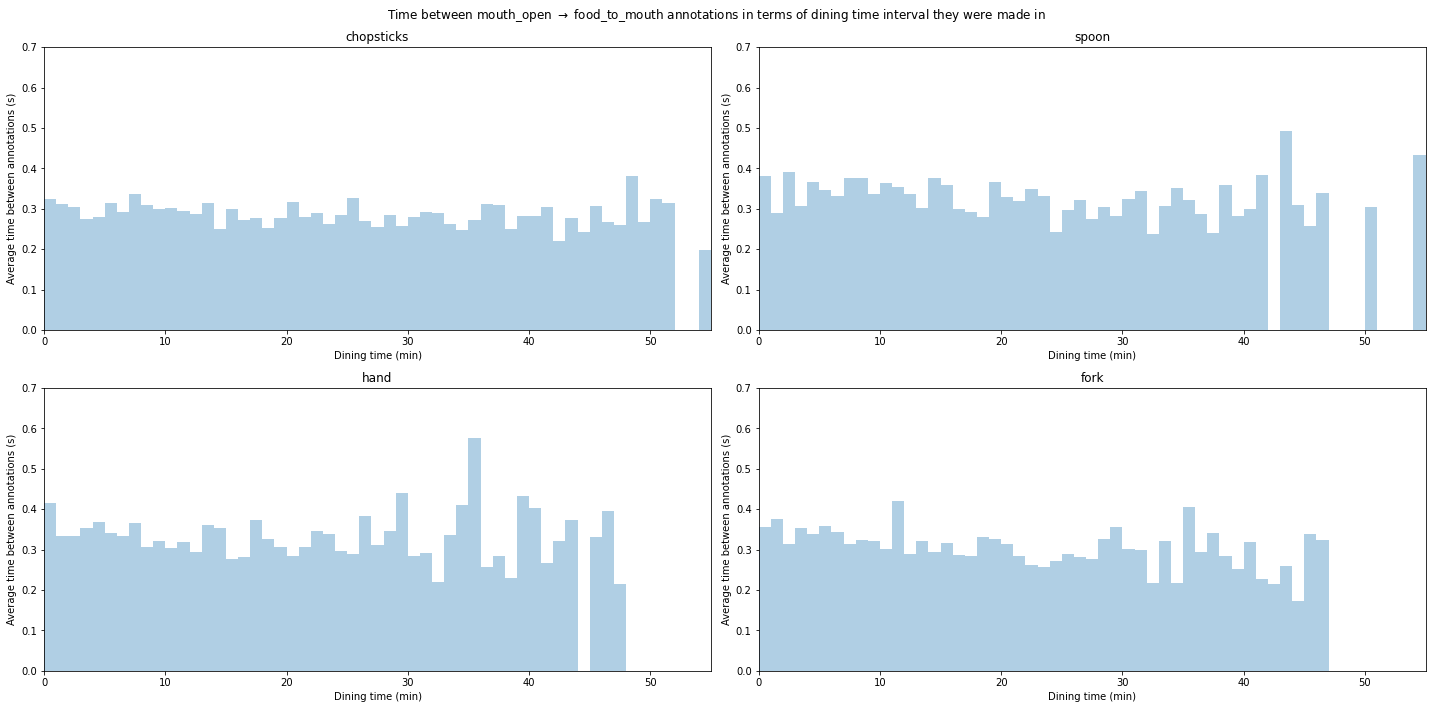

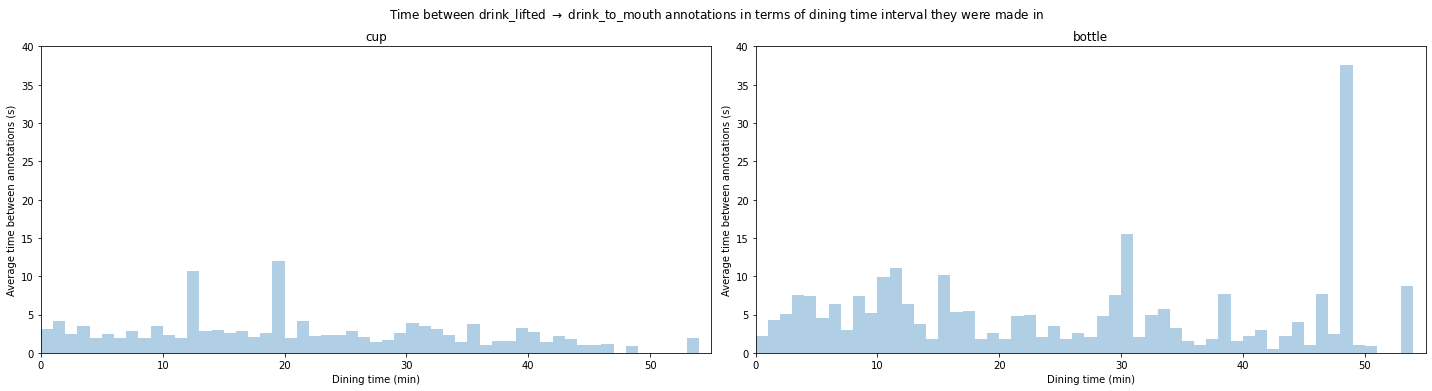

In [180]:
delay_labels = {
    'fl->ftm': fr'food_lifted $\rightarrow$ food_to_mouth',
    'mo->ftm': fr'mouth_open $\rightarrow$ food_to_mouth',
    'dl->dtm': fr'drink_lifted $\rightarrow$ drink_to_mouth',
    'nl->ntm': fr'napkin_lifted $\rightarrow$ napkin_to_mouth',
}
bin_width = 1 # in minutes
print(f"Bin width: {bin_width} min")
for delay_label_key, ymax in zip(delay_labels.keys(), [19, 0.7, 40]):
    plt.figure(figsize=(20,10))
    i = 0
    for annotation_value in delays_by_value[delay_label_key].keys():
        # Skip 'knife' and empty annotation values for mouth_open and food_to_mouth annotations
        if annotation_value == 'knife' or (annotation_value == '' and (delay_label_key == 'fl->ftm' or delay_label_key == 'mo->ftm')):
            print("Skipping 'knife' and empty annotation values for mouth_open and food_to_mouth annotations")
            continue
        start_times_list, spacings_list = list(zip(*delays_by_value[delay_label_key][annotation_value]))
        bins_range = np.arange(0, max(start_times_list) + bin_width, bin_width)
        y = list(map(np.nan_to_num, binned_statistic(start_times_list, spacings_list, bins=bins_range, statistic='mean')[0]))
        plt.subplot(2, 2, i + 1)
        i += 1
        plt.bar(bins_range[:-1], y, width=bin_width, alpha=0.35, align='edge')
        plt.xlim(0, 55)
        plt.ylim(0, ymax)
        plt.xlabel('Dining time (min)')
        plt.ylabel(f'Average time between annotations (s)')
        plt.title(annotation_value)
    plt.suptitle(f'Time between {delay_labels[delay_label_key]} annotations in terms of dining time interval they were made in')
    plt.tight_layout()
    plt.show()


get maximum of histogram for other histograms
